In [1]:
import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
import tqdm
### notebook specific configuration ###
from os.path import basename
mpl.style.use('fivethirtyeight')

In [2]:
from Modules.Homer import *

/home/isshamie/software/NGS-Pipeline/Modules/Homer.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/isshamie/software/anaconda2/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/isshamie/software/anaconda2/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/isshamie/software/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/isshamie/software/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/isshamie/software/anacond

In [3]:
sys.path.append('/home/isshamie/software/NGS-Pipeline')

In [4]:
data_folder = '/data/isshamie/CH_tissue_TSS/'

In [5]:
ref_fa = '/data/genome/hamster/picr/picr.fa'
annotation = '/data/genome/hamster/picr/updated_final_sort.gff3'

mrna_peak = '/data/isshamie/TSS_CHO/mRNA.peak'

In [6]:
tissues = ['BloondnegSpleen','BMDM1hKLA1','BMDMwt','Brain','Brain7neg1',
          'FemaleReproductive','Heart','Intestine','Kidney','Liver','Lung',
           'MiscOrgans','Muscle','Pancreas','Skin','Spleen','Total','CHO']

In [7]:
len(tissues)

18

### Load in meta_sampe

In [8]:
meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)
meta_samples.head()

,Experiment,Short,Tissue
BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak,GRO,BloondnegSpleen_GRO,BloondnegSpleen
BloondnegSpleen/mSTART/f04_peaks/merge_bg_2.peak,mSTART,BloondnegSpleen_mSTART,BloondnegSpleen
BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak,GRO,BMDM1hKLA1_GRO,BMDM1hKLA1
BMDMwt/GRO/f04_peaks/merge_bg_2.peak,GRO,BMDMwt_GRO,BMDMwt
Brain/GRO/f04_peaks/merge_bg_2.peak,GRO,Brain_GRO,Brain


## Create Peaks by Sample matrix

#### Load in merged peak file 

In [10]:
peaks_merged = pd.read_csv('Results/merged_samples/duplicates_separate_peaks_merged.tsv',sep='\t',index_col=0)


## Drop duplicates
dups = peaks_merged[peaks_merged.index.duplicated(keep=False)]
print 'Number of duplicate indices (having same index name, happens bc both +/- strand on exact same bp): ', len(dups)/2
peaks_merged = peaks_merged[~peaks_merged.index.isin(dups.index)]

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of duplicate indices (having same index name, happens bc both +/- strand on exact same bp):  16


In [11]:
peaks_merged.head()

,Chr,Start,End,Strand,Stat,Parent files,Total subpeaks,BloondnegSpleen/GRO/f04_peaks/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001_and_trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001_bg_2.peak,BMDM1hKLA1/GRO/f04_peaks/trim_CHBMDM1hKLA_5GRO_JHS1034_SD_AGTCAA_S49_L003_R1_001_and_trim_CHBMDM1hKLA_GRO_JHS1027_SD_CAAAAG_S42_L003_R1_001_bg_2.peak,BMDMwt/GRO/f04_peaks/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001_and_trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001_bg_2.peak,...,Muscle/mSTART/f04_peaks/trim_CHMuscle_mSTART_JHS1019_SD_GTGGCC_S31_L002_R1_001_and_trim_CHMuscle_mSTARTinput_JHS1079_SD_CAAAAG_S101_L005_R1_001_bg_2.peak,Muscle/mSTART/f04_peaks/trim_CHMuscle_mSTART_JHS1058_SD_CAAAAG_S80_L004_R1_001_and_trim_CHMuscle_mSTARTinput_JHS1079_SD_CAAAAG_S101_L005_R1_001_bg_2.peak,Pancreas/mSTART/f04_peaks/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001_and_trim_CHPancreas_mSTARTinput_JHS1072_SD_GTTTCG_S94_L005_R1_001_bg_2.peak,Pancreas/mSTART/f04_peaks/trim_CHPancreas_mSTART_JHS1051_SD_GTTTCG_S73_L004_R1_001_and_trim_CHPancreas_mSTARTinput_JHS1072_SD_GTTTCG_S94_L005_R1_001_bg_2.peak,Spleen/mSTART/f04_peaks/trim_CHSpleen_mSTART_JHS1053_SD_GAGTGG_S75_L004_R1_001_and_trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD371_S10_R1_001_and_trim_CHO-GRO-SD369_S8_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD367_S6_R1_001_and_trim_CHO-GRO-SD370_S9_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD367_S6_R1_001_and_trim_CHO-GRO-SD369_S8_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD371_S10_R1_001_and_trim_CHO-GRO-SD370_S9_R1_001_bg_2.peak,CHO/mSTART/f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_and_trim_CHO--mSTART_input-JHS802_S11_R1_001_bg_2.peak
ID,,,,,,,,,,,,,,,,,,,,,
Merged-picr_14-20792484-12,picr_14,20792409,20792559,+,61.408333,FemaleReproductive/mSTART/f04_peaks/trim_CHFem...,12,NaN,NaN,NaN,...,NaN,picr_14-227,NaN,NaN,picr_14-210,picr_14-218,picr_14-240,picr_14-240,picr_14-218,picr_14-180
Merged-picr_1-16178956-12,picr_1,16178860,16179050,+,42.008331,FemaleReproductive/mSTART/f04_peaks/trim_CHFem...,12,NaN,NaN,NaN,...,NaN,picr_1-1093,NaN,NaN,picr_1-1336,picr_1-920,picr_1-908,picr_1-908,picr_1-920,picr_1-271
Merged-picr_113-1468320-12,picr_113,1468223,1468427,+,39.291668,FemaleReproductive/mSTART/f04_peaks/trim_CHFem...,12,NaN,NaN,NaN,...,picr_113-72,NaN,NaN,NaN,picr_113-46,picr_113-35,picr_113-34,picr_113-34,picr_113-35,picr_113-37
Merged-picr_5-20237660-13,picr_5,20237573,20237740,+,72.646156,FemaleReproductive/mSTART/f04_peaks/trim_CHFem...,13,NaN,NaN,NaN,...,picr_5-98,picr_5-338,NaN,NaN,picr_5-569,NaN,NaN,NaN,NaN,NaN
Merged-picr_139-2077513-14,picr_139,2077420,2077602,-,94.578575,BloondnegSpleen/GRO/f04_peaks/trim_CHBloondneg...,14,picr_139-183,NaN,picr_139-44,...,NaN,picr_139-33,NaN,NaN,picr_139-136,picr_139-44,picr_139-39,picr_139-39,picr_139-44,picr_139-63


In [12]:
ls {data_folder}/BloondnegSpleen/GRO/f04_peaks/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001_and_trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001_bg_2.peak

/data/isshamie/CH_tissue_TSS//BloondnegSpleen/GRO/f04_peaks/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001_and_trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001_bg_2.peak


In [13]:
col = 'BloondnegSpleen/GRO/f04_peaks/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001_and_trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001_bg_2.peak'
pd.read_csv(data_folder + col,sep='\t',skiprows=36,index_col=0) #comment='#'

,chr,start,end,strand,Normalized Tag Count,focus ratio,findPeaks Score,Total Tags (normalized to Control Experiment),Control Tags,Fold Change vs Control,p-value vs Control,Fold Change vs Local,p-value vs Local,Dispersion Ratio,Periodic Ratio
#PeakID,,,,,,,,,,,,,,,
picr_13-1,picr_13,30535313,30535463,+,119630.60,0.998,151386.0,96610.6,964.0,100.22,0.000000,26349.93,0.000000e+00,0.998579,0.572093
picr_56-1,picr_56,12595434,12595584,+,64609.90,1.000,81783.0,52177.3,61.0,855.37,0.000000,17032.06,0.000000e+00,0.997797,0.244444
picr_8-1,picr_8,32678234,32678384,-,40099.10,0.993,50712.0,32383.0,1739.0,18.62,0.000000,9172.89,0.000000e+00,0.991264,0.372460
picr_8-2,picr_8,32696172,32696322,+,27534.90,0.976,34819.0,22236.5,866.0,25.68,0.000000,17191.34,0.000000e+00,0.778569,0.681193
picr_8-3,picr_8,29065707,29065857,-,23867.90,0.997,30182.0,19275.1,575.0,33.52,0.000000,4336.87,0.000000e+00,0.995527,0.659259
picr_87-1,picr_87,754291,754441,+,22158.20,0.980,28020.0,17894.4,841.0,21.28,0.000000,13333.19,0.000000e+00,0.993897,0.502924
picr_8-4,picr_8,39295352,39295502,-,20488.80,0.994,25909.0,16546.3,1370.0,12.08,0.000000,14794.41,0.000000e+00,0.987765,0.555205
picr_54-1,picr_54,7265426,7265576,-,19256.00,0.998,24350.0,15550.6,159.0,97.80,0.000000,2095.65,0.000000e+00,0.998604,0.794118
picr_36-1,picr_36,10050654,10050804,-,18517.40,0.989,23420.0,14954.2,1331.0,11.24,0.000000,1038.95,0.000000e+00,0.986804,0.336570


In [14]:
peak_tissue_matrix = pd.DataFrame(np.zeros([peaks_merged.shape[0],len(peaks_merged.columns.values[7:])],dtype='int64'),
             columns=peaks_merged.columns.values[7:])
peak_tissue_matrix = peak_tissue_matrix[~peak_tissue_matrix.index.duplicated(False)]
peak_tissue_matrix.set_index(peaks_merged.index.values,inplace=True)
for col in peak_tissue_matrix.columns.values:
    print col
    
    try:
        curr_peaks = pd.read_csv(data_folder + col,sep='\t',skiprows=36,index_col=0) #36 bc of the comments. Weird commenting where header also has # 
    except:
        print 'File couldnt be loaded!'
        continue
    
    # Load in the column file and get the peak values
    filt = peaks_merged.loc[~peaks_merged.loc[:,col].isnull()] ## Get rows where the column had a peak
    curr_AI = filt.index.values
    curr_keys = np.array(filt[col])
    #Filter curr_peaks to only with keys
    curr_peaks = curr_peaks.loc[curr_keys]
    #Save duplicates to deal with later
    curr_dups = curr_peaks[curr_peaks.loc[curr_keys].index.duplicated(keep=False)]
    #Drop the duplicates and assign the non-duplicate values
    curr_peaks = curr_peaks.drop(curr_dups.index)
    print('curr_dups',len(curr_dups))
    vals = np.array(curr_peaks.loc[curr_keys,'findPeaks Score'])
    vals = np.nan_to_num(vals) #Turn Stat into 0
    peak_tissue_matrix.loc[curr_AI,col] = vals
    #peak_tissue_matrix.loc[curr_AI,col] = (curr_peaks.loc[curr_keys,'Stat'])
    
# In case any peaks have No tissues with the expression, which shouldn't really happen
peak_tissue_matrix = peak_tissue_matrix.loc[:,np.sum(peak_tissue_matrix > 0)!=0]
peak_tissue_matrix = peak_tissue_matrix.loc[np.sum(peak_tissue_matrix > 0,axis=1)!=0,:]

BloondnegSpleen/GRO/f04_peaks/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001_and_trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001_bg_2.peak
('curr_dups', 0)
BMDM1hKLA1/GRO/f04_peaks/trim_CHBMDM1hKLA_5GRO_JHS1034_SD_AGTCAA_S49_L003_R1_001_and_trim_CHBMDM1hKLA_GRO_JHS1027_SD_CAAAAG_S42_L003_R1_001_bg_2.peak
('curr_dups', 0)
BMDMwt/GRO/f04_peaks/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001_and_trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001_bg_2.peak
('curr_dups', 0)
Brain/GRO/f04_peaks/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001_and_trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001_bg_2.peak
('curr_dups', 0)
Brain/mSTART/f04_peaks/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001_and_trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001_bg_2.peak
('curr_dups', 0)
Brain/mSTART/f04_peaks/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001_and_trim_CHBrainnegmaybe7neg1_mSTARTinput_JHS1082_SD_CACGAT_S104_L005_R1_001_bg_2.peak
('curr

In [15]:
## Save peaks_merged_tissue_matrix
peak_tissue_matrix.to_csv('Results/merged_samples/duplicatesSeparate_peaks_tissues.csv')

In [16]:
peak_tissue_matrix.head()

,BloondnegSpleen/GRO/f04_peaks/trim_CHBloondnegSpleen_5GRO_JHS1039_SD_GTCCGC_S54_L003_R1_001_and_trim_CHBloondnegSpleen_GRO_JHS1032_SD_TCCCGA_S47_L003_R1_001_bg_2.peak,BMDM1hKLA1/GRO/f04_peaks/trim_CHBMDM1hKLA_5GRO_JHS1034_SD_AGTCAA_S49_L003_R1_001_and_trim_CHBMDM1hKLA_GRO_JHS1027_SD_CAAAAG_S42_L003_R1_001_bg_2.peak,BMDMwt/GRO/f04_peaks/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001_and_trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001_bg_2.peak,Brain/GRO/f04_peaks/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001_and_trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001_bg_2.peak,Brain/mSTART/f04_peaks/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001_and_trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001_bg_2.peak,Brain/mSTART/f04_peaks/trim_CHBrain_mSTART_JHS1016_SD_GTAGAG_S28_L002_R1_001_and_trim_CHBrainnegmaybe7neg1_mSTARTinput_JHS1082_SD_CACGAT_S104_L005_R1_001_bg_2.peak,Brain/mSTART/f04_peaks/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001_and_trim_CHBrain_mSTARTinput_JHS1078_SD_ATTCCT_S100_L005_R1_001_bg_2.peak,Brain/mSTART/f04_peaks/trim_CHBrain_mSTART_JHS1057_SD_ATTCCT_S79_L004_R1_001_and_trim_CHBrainnegmaybe7neg1_mSTARTinput_JHS1082_SD_CACGAT_S104_L005_R1_001_bg_2.peak,FemaleReproductive/mSTART/f04_peaks/trim_CHFemaleReproductive_mSTART_JHS1011_SD_TAGCTT_S23_L002_R1_001_and_trim_CHFemaleReproductive_mSTARTinput_JHS1073_SD_CGTACG_S95_L005_R1_001_bg_2.peak,FemaleReproductive/mSTART/f04_peaks/trim_CHFemaleReproductive_mSTART_JHS1052_SD_CGTACG_S74_L004_R1_001_and_trim_CHFemaleReproductive_mSTARTinput_JHS1073_SD_CGTACG_S95_L005_R1_001_bg_2.peak,...,Muscle/mSTART/f04_peaks/trim_CHMuscle_mSTART_JHS1019_SD_GTGGCC_S31_L002_R1_001_and_trim_CHMuscle_mSTARTinput_JHS1079_SD_CAAAAG_S101_L005_R1_001_bg_2.peak,Muscle/mSTART/f04_peaks/trim_CHMuscle_mSTART_JHS1058_SD_CAAAAG_S80_L004_R1_001_and_trim_CHMuscle_mSTARTinput_JHS1079_SD_CAAAAG_S101_L005_R1_001_bg_2.peak,Pancreas/mSTART/f04_peaks/trim_CHPancreas_mSTART_JHS1014_SD_ATGTCA_S26_L002_R1_001_and_trim_CHPancreas_mSTARTinput_JHS1072_SD_GTTTCG_S94_L005_R1_001_bg_2.peak,Pancreas/mSTART/f04_peaks/trim_CHPancreas_mSTART_JHS1051_SD_GTTTCG_S73_L004_R1_001_and_trim_CHPancreas_mSTARTinput_JHS1072_SD_GTTTCG_S94_L005_R1_001_bg_2.peak,Spleen/mSTART/f04_peaks/trim_CHSpleen_mSTART_JHS1053_SD_GAGTGG_S75_L004_R1_001_and_trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD371_S10_R1_001_and_trim_CHO-GRO-SD369_S8_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD367_S6_R1_001_and_trim_CHO-GRO-SD370_S9_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD367_S6_R1_001_and_trim_CHO-GRO-SD369_S8_R1_001_bg_2.peak,CHO/GRO/f04_peaks/trim_CHO-5GRO-SD371_S10_R1_001_and_trim_CHO-GRO-SD370_S9_R1_001_bg_2.peak,CHO/mSTART/f04_peaks/trim_CHO--mSTART-JHS823_S21_R1_001_and_trim_CHO--mSTART_input-JHS802_S11_R1_001_bg_2.peak
Merged-picr_14-20792484-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,...,0.0,25.0,0.0,0.0,18.0,153.0,157.0,157.0,153.0,163.0
Merged-picr_1-16178956-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,10.0,0.0,0.0,6.0,72.0,94.0,94.0,72.0,344.0
Merged-picr_113-1468320-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,11.0,0.0,0.0,0.0,12.0,127.0,178.0,178.0,127.0,113.0
Merged-picr_5-20237660-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,...,131.0,24.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
Merged-picr_139-2077513-14,19.0,0.0,78.0,52.0,0.0,0.0,86.0,0.0,0.0,12.0,...,0.0,77.0,0.0,0.0,7.0,370.0,573.0,573.0,370.0,168.0


# Clustering
Using all peaks, promoter peaks, binarized and unbinarized, and with and without mSTART (which had less)
Also will cluster promoter peaks with all samples (replicates treated separately) to see if clustering is working as expected

## Cluster promoter

In [17]:
### First filter peaks to only promoter
anno_peaks = pd.read_csv('Results/merged_samples/duplicates_separate_peaks_merged_anno.tsv',sep='\t',index_col=0)

anno_peaks = anno_peaks.fillna('')
promoter_peaks = anno_peaks[anno_peaks['Annotation'].str.contains('promoter')].index

promoter_tissue_matrix = peak_tissue_matrix[peak_tissue_matrix.index.isin(promoter_peaks)]

In [18]:
print 'Number of promoter peaks: ', len(promoter_tissue_matrix)

Number of promoter peaks:  135245


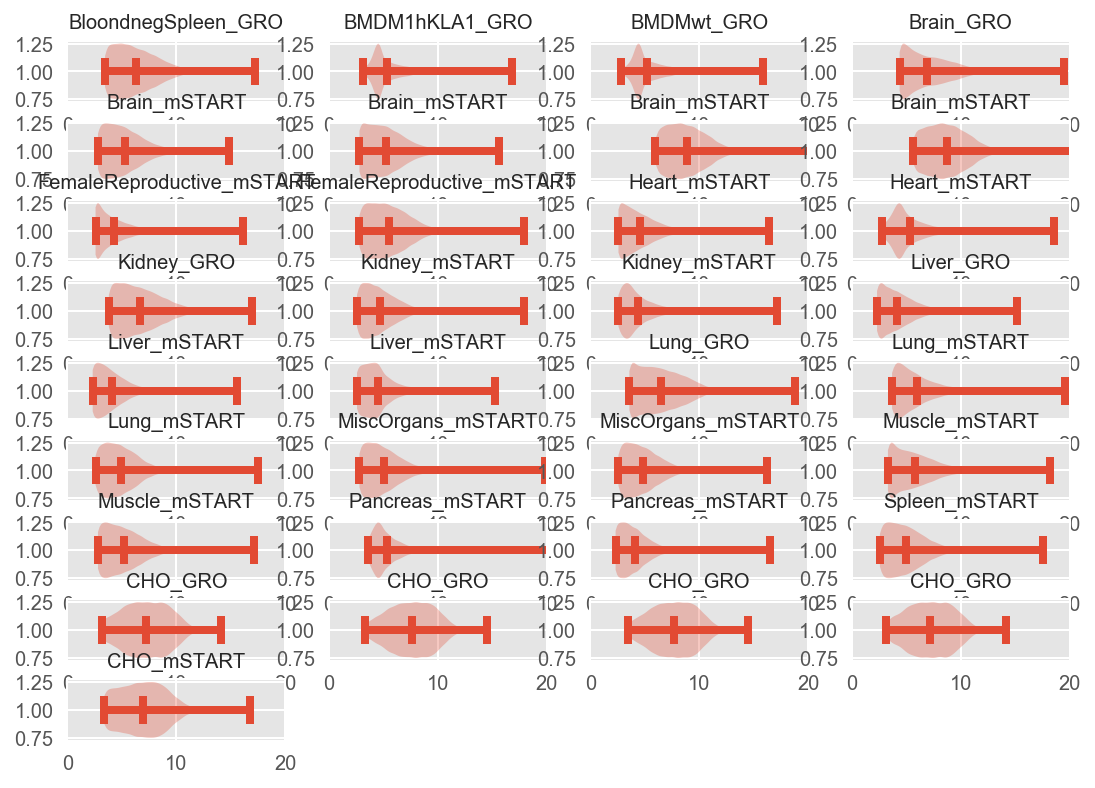

In [20]:
f = plt.figure()
promoter_tissue_log2 = np.log2(promoter_tissue_matrix + 1)

N = len(promoter_tissue_log2.columns.values)
cols = 4
rows = np.ceil(1.0*N / 4)
n = 1
for i in promoter_tissue_log2.columns.values:
    ax = f.add_subplot(rows,cols,n)
    curr = promoter_tissue_log2.loc[:,i]
    curr = curr[curr>0]
    plt.violinplot(curr,vert=False,showmeans=True)
    curr_title = i.split('/')[0] + '_' + i.split('/')[1]
    ax.set_title(curr_title,fontdict={'fontsize':10})
    ax.set_xlim([0,20])
    n += 1
    plt.grid(True)
    #tck = ax.get_xticks()
    #ax.set_xticks([])

plt.subplots_adjust(hspace=0.3)

### Binary

In [ ]:
long_meta_samples = pd.read_csv('Results/long_meta_samples.csv')

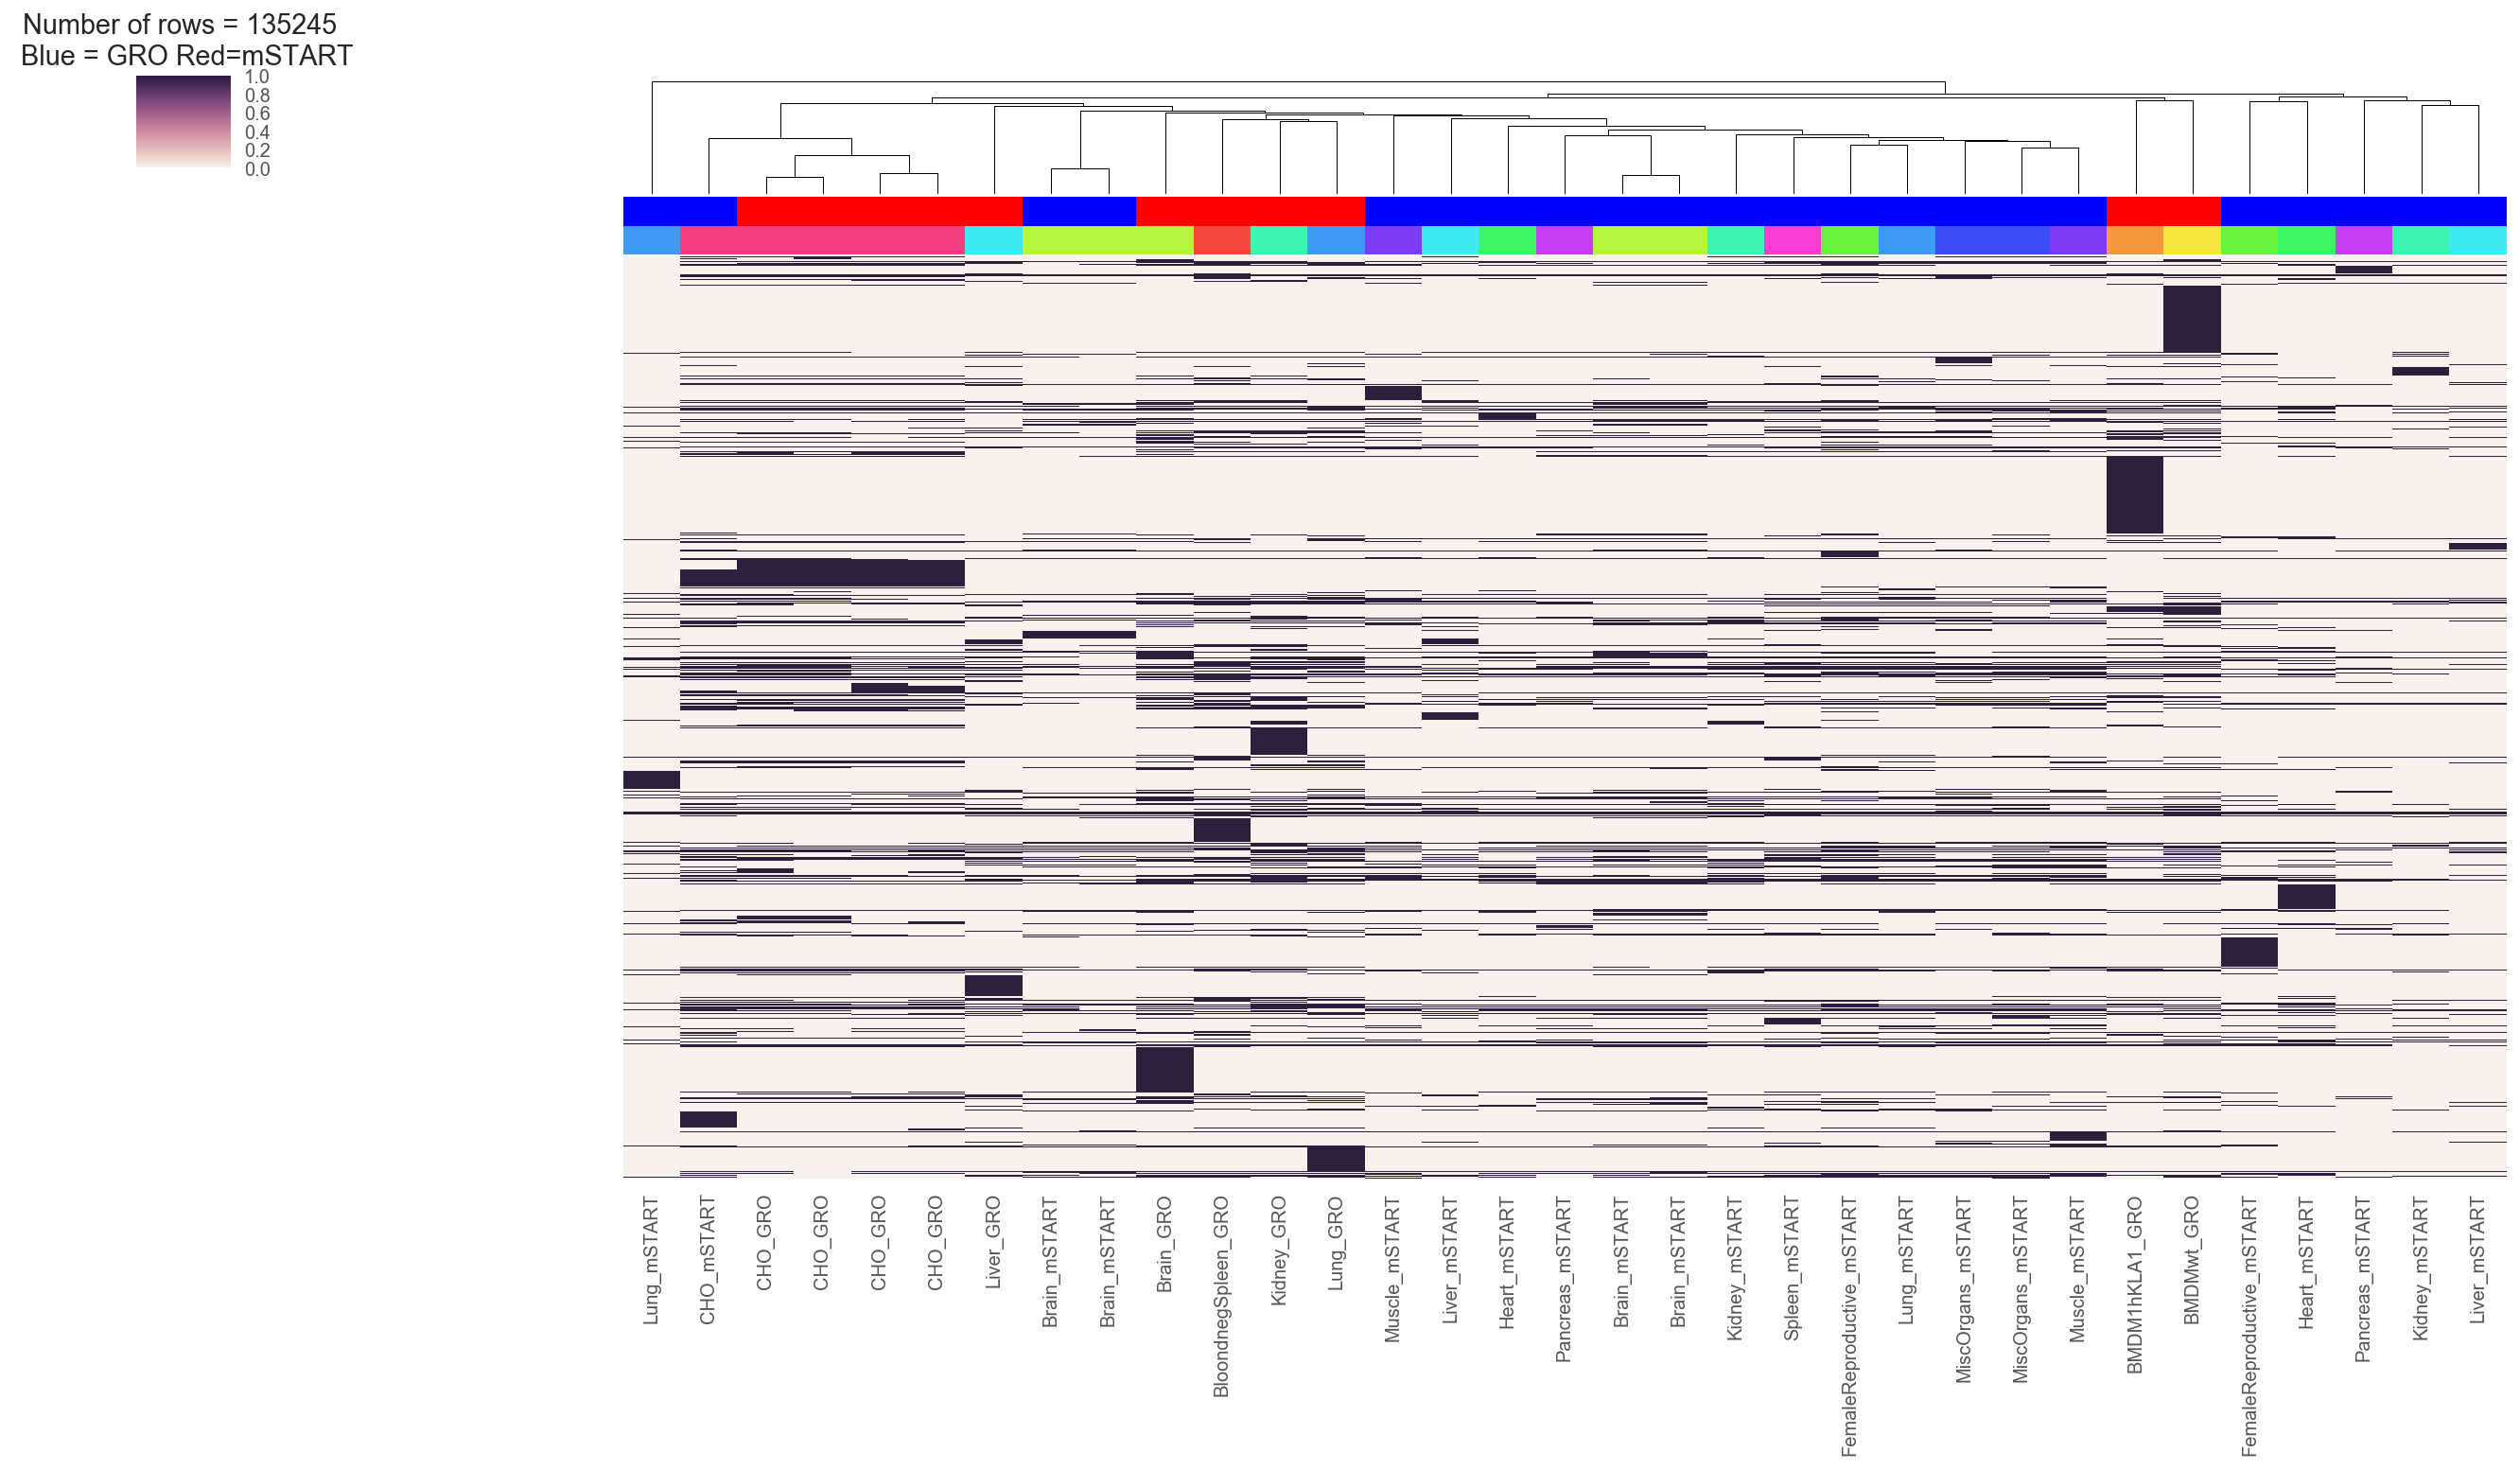

In [77]:
short_prom = promoter_tissue_matrix > 0

n_tis = len(set(long_meta_samples['Tissue']))

lut = dict(zip(long_meta_samples.loc[short_prom.columns.values,'Experiment'].unique(), "rbg"))
col_colors = long_meta_samples.loc[short_prom.columns.values,'Experiment'].map(lut)

lut2 = dict(zip(long_meta_samples.loc[short_prom.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = long_meta_samples.loc[short_prom.columns.values,'Tissue'].map(lut2)

g = sns.clustermap(short_prom,col_cluster=True,figsize=(20,10),metric='jaccard',row_cluster=False
                   ,yticklabels=False,col_colors=[col_colors,col_colors2],xticklabels=long_meta_samples.loc[short_prom.columns.values,'Short'])

# g = sns.clustermap(short_prom,col_cluster=True,figsize=(20,10),metric='jaccard',row_cluster=False
#                    ,yticklabels=False)

title = 'Number of rows = %d \n Blue = GRO Red=mSTART' % len(short_prom)
plt.title(title)
g.savefig('Results/Figures/duplicatePeaks_binary_jaccard_promoter_peak_cluster.png',bbox_inches='tight')

### log2 Real-Valued

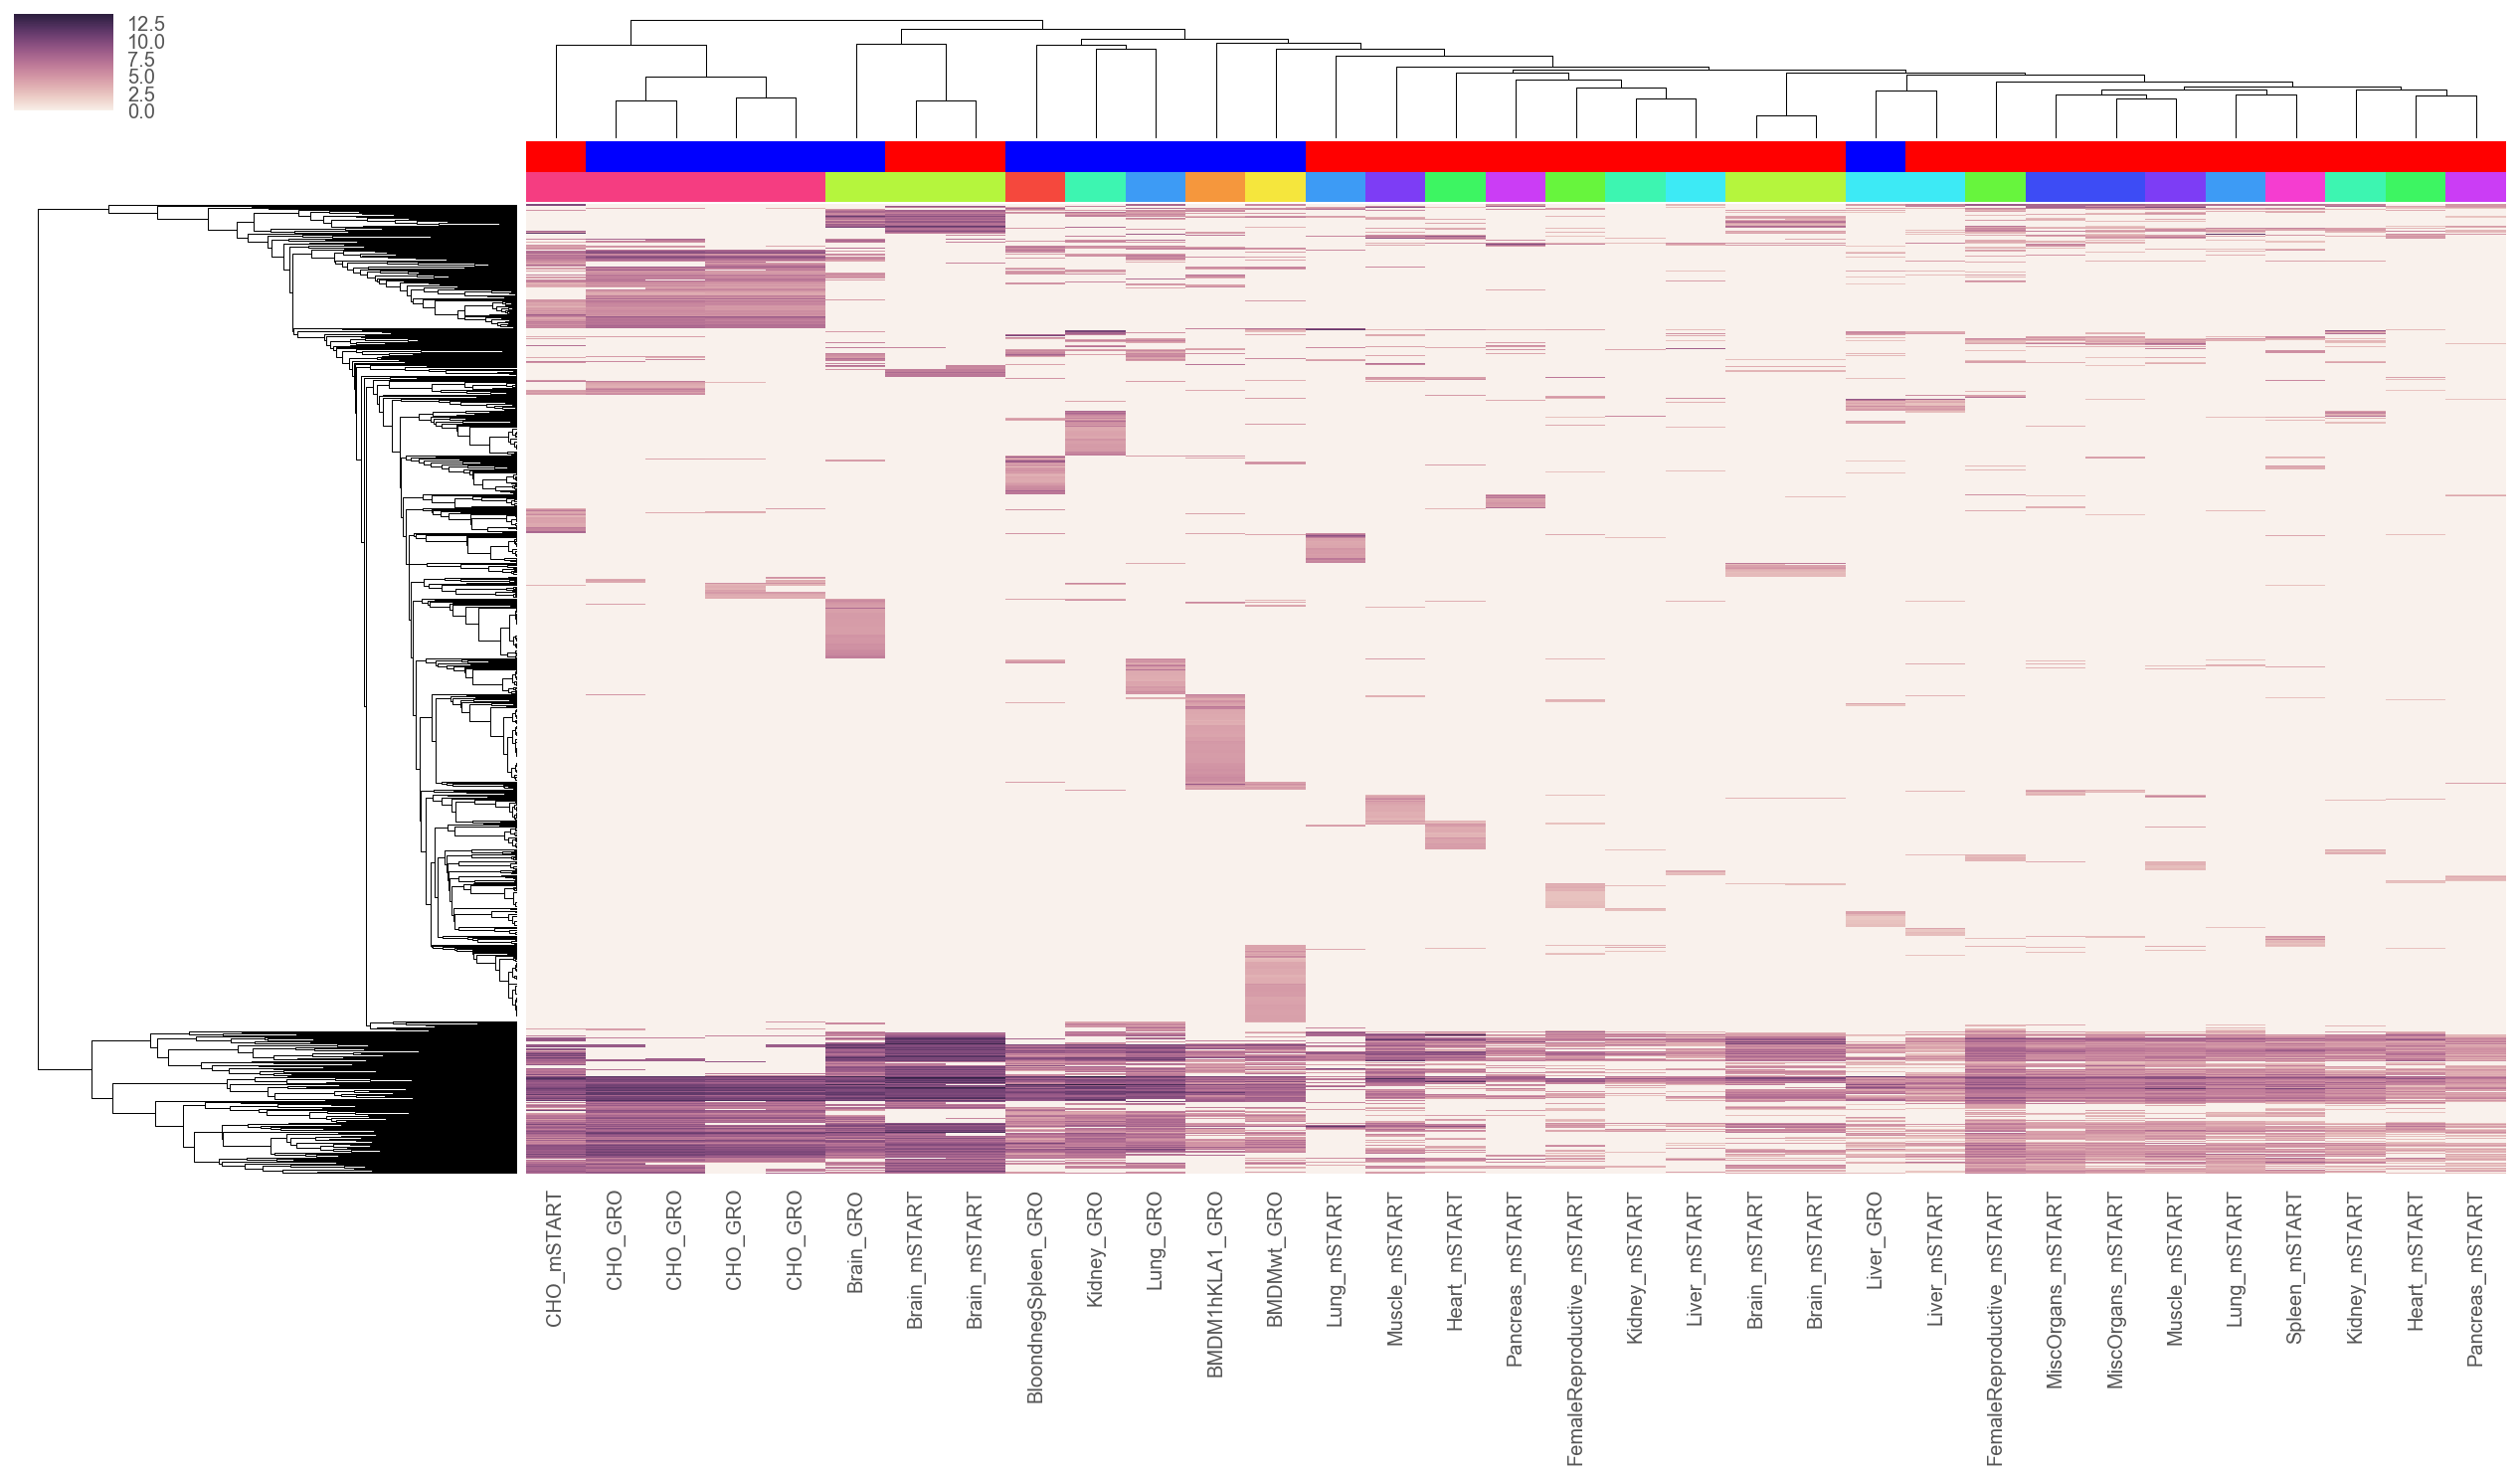

In [93]:
short_prom = promoter_tissue_matrix.iloc[np.random.choice(promoter_tissue_matrix.shape[0],1000,replace=False)]
col_colors = ["b" if i == 'GRO' else "r"  for i in np.array(long_meta_samples.loc[short_prom.columns.values,'Experiment'])]
lut2 = dict(zip(long_meta_samples.loc[short_prom.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = long_meta_samples.loc[short_prom.columns.values,'Tissue'].map(lut2)
 
f = plt.figure(dpi=300)
g = sns.clustermap(np.log2(short_prom+1),col_cluster=True,figsize=(20,10)
                   ,yticklabels=False,col_colors=[col_colors,col_colors2],xticklabels=long_meta_samples.loc[short_prom.columns.values,'Short'])
g.savefig('Results/Figures/duplicatePeaks_promoter_peak_cluster_log2.png',bbox_inches='tight')

## All peaks, not just promoter

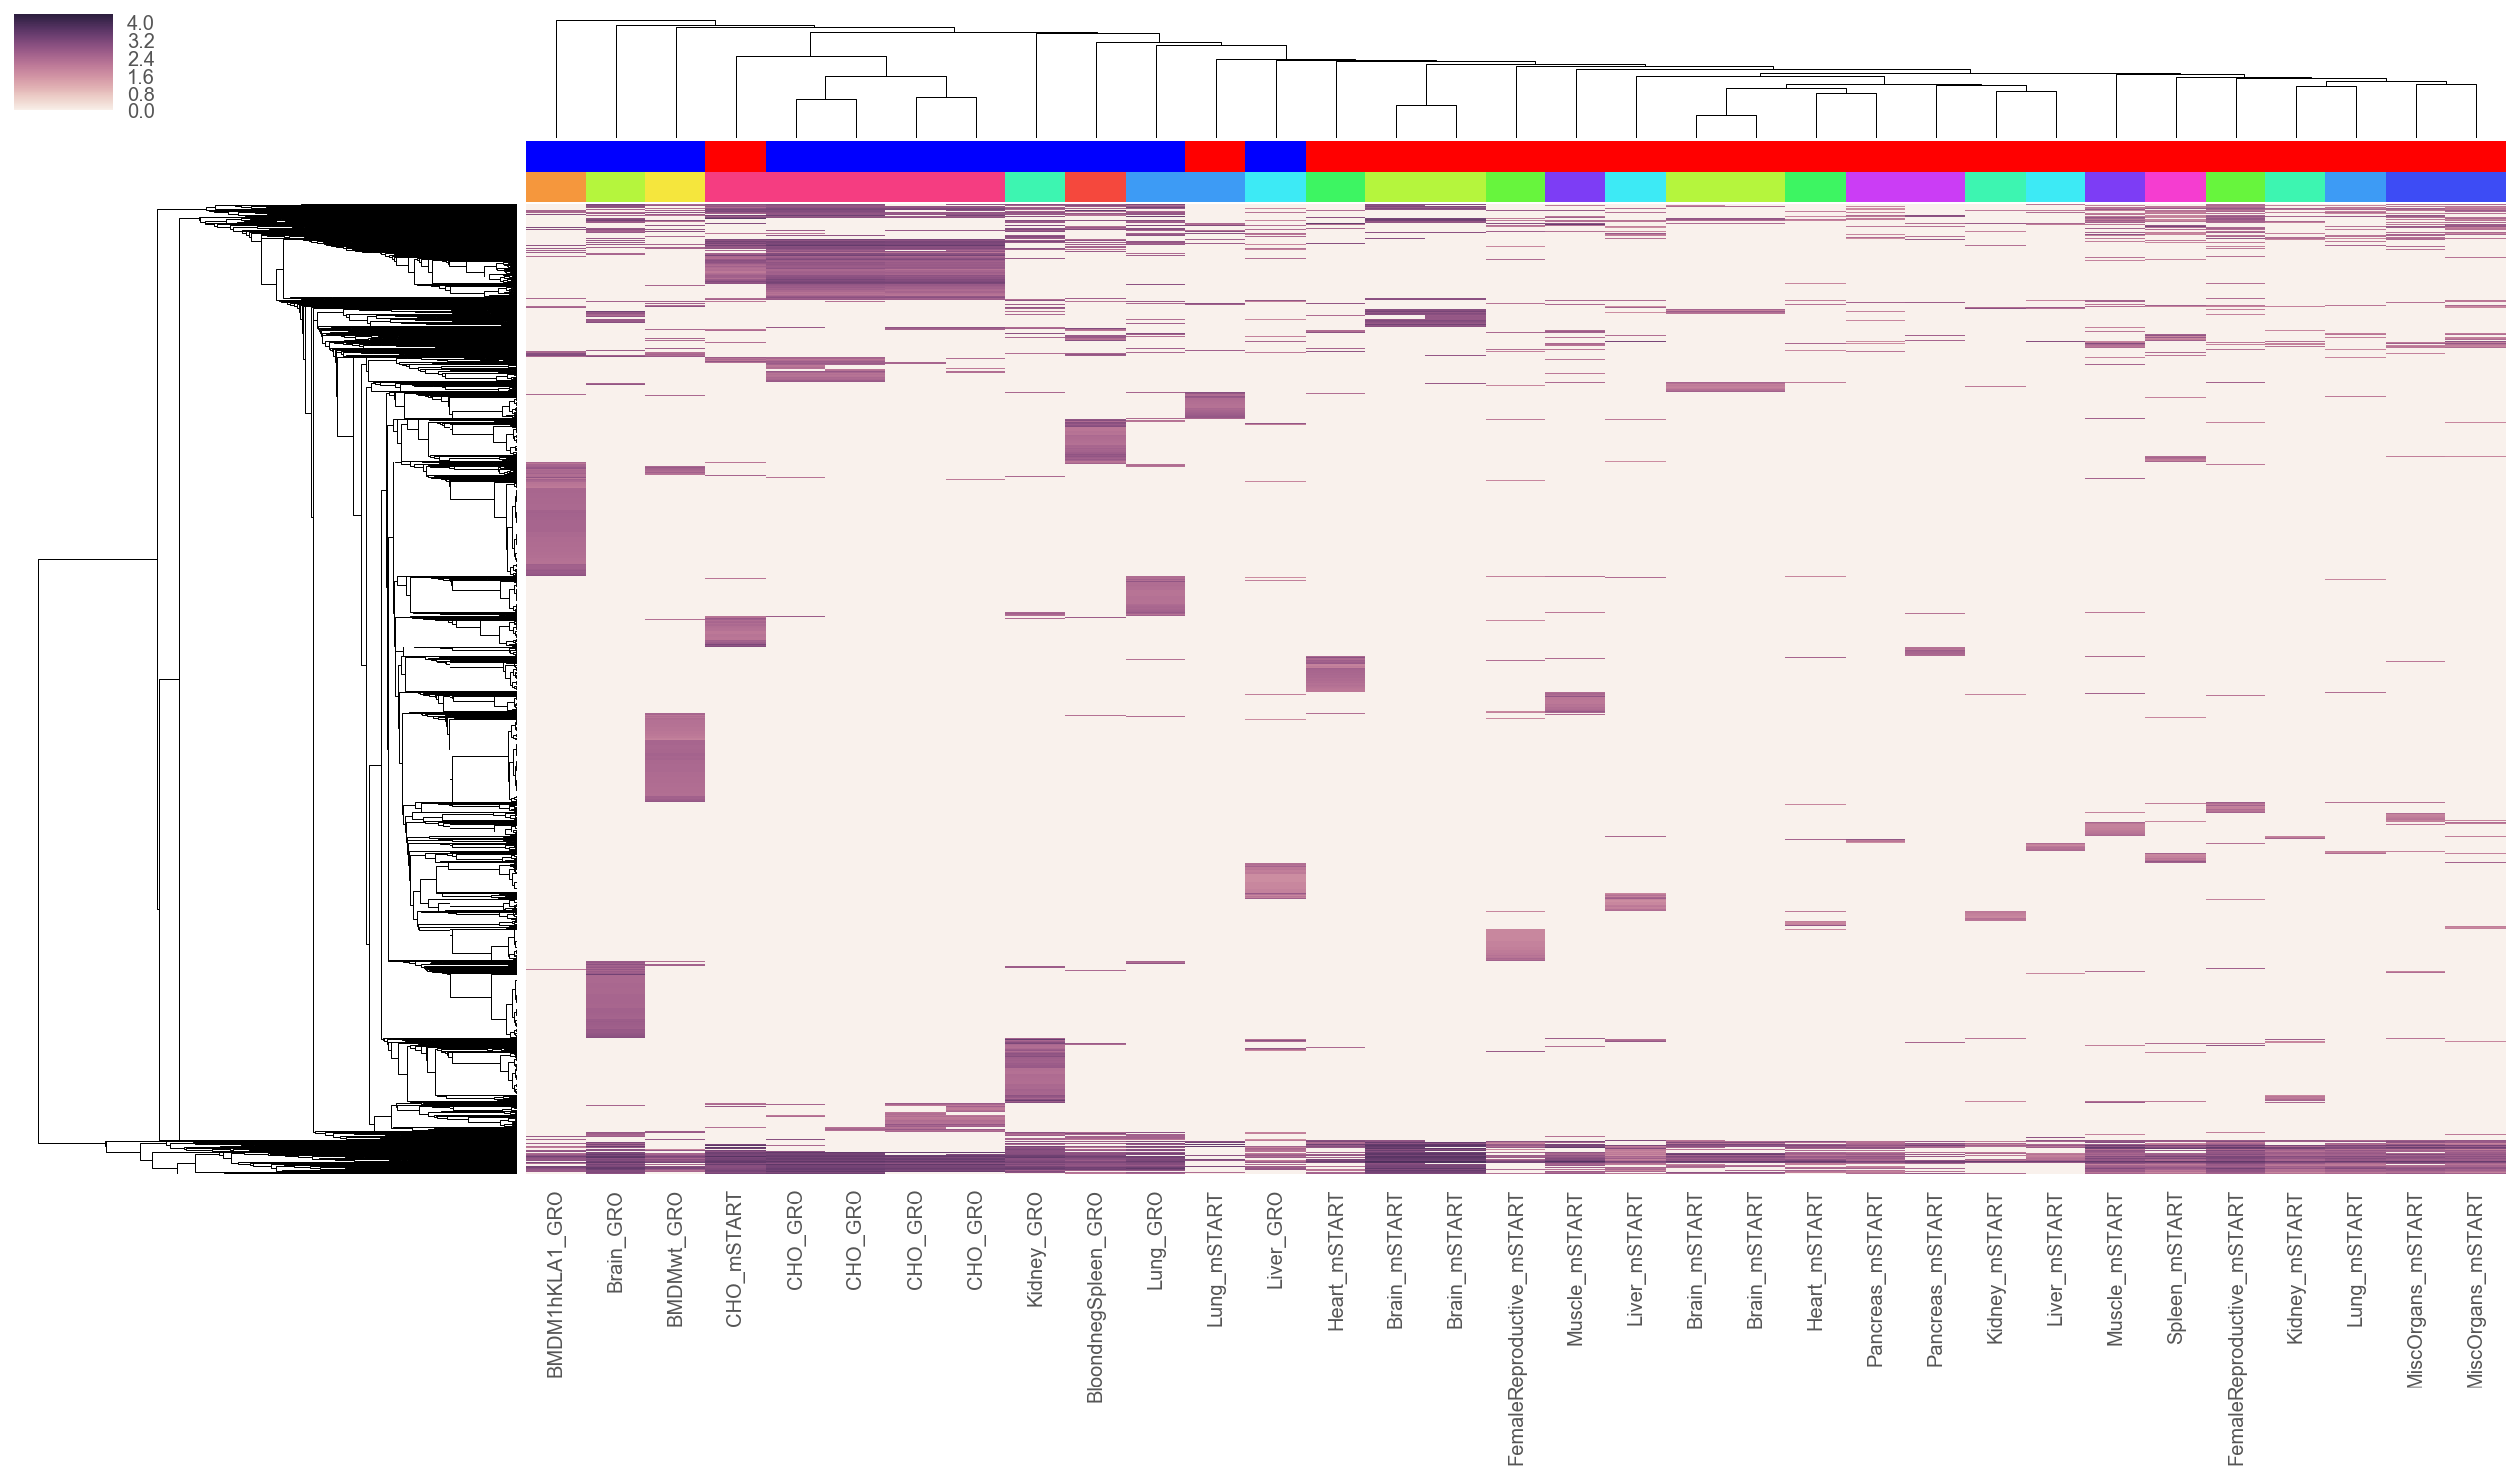

In [92]:
log2_peak_tissue_matrix = np.log2(peak_tissue_matrix+1)
log2_peak_tissue_matrix = log2_peak_tissue_matrix.iloc[np.random.choice(log2_peak_tissue_matrix.shape[0],10000,replace=False)]
col_colors = ["b" if i == 'GRO' else "r"  for i in np.array(long_meta_samples.loc[log2_peak_tissue_matrix.columns.values,'Experiment'])]
lut2 = dict(zip(long_meta_samples.loc[log2_peak_tissue_matrix.columns.values,'Tissue'].unique(), sns.hls_palette(n_tis,s=0.9)))
col_colors2 = long_meta_samples.loc[log2_peak_tissue_matrix.columns.values,'Tissue'].map(lut2)
 
f = plt.figure(dpi=300)
g = sns.clustermap(np.log2(log2_peak_tissue_matrix+1),col_cluster=True,figsize=(20,10)
                   ,yticklabels=False,col_colors=[col_colors,col_colors2],xticklabels=long_meta_samples.loc[log2_peak_tissue_matrix.columns.values,'Short'])
g.savefig('Results/Figures/duplicatePeaks_all_peak_cluster_log2.png',bbox_inches='tight')

## Venn Diagram of replicates overlap

In [9]:
import pyupset as pyu

/data/isshamie/CH_tissue_TSS/BloondnegSpleen/GRO/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/BMDM1hKLA1/GRO/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/BMDMwt/GRO/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Brain/GRO/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Brain/mSTART/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/FemaleReproductive/mSTART/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Heart/mSTART/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Kidney/GRO/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Kidney/mSTART/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Liver/GRO/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Liver/mSTART/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Lung/GRO/f04_peaks/merge_bg_2.peak_venn.tsv
/data/isshamie/CH_tissue_TSS/Lung/mSTART/f04_peaks/merge_bg_2.peak_

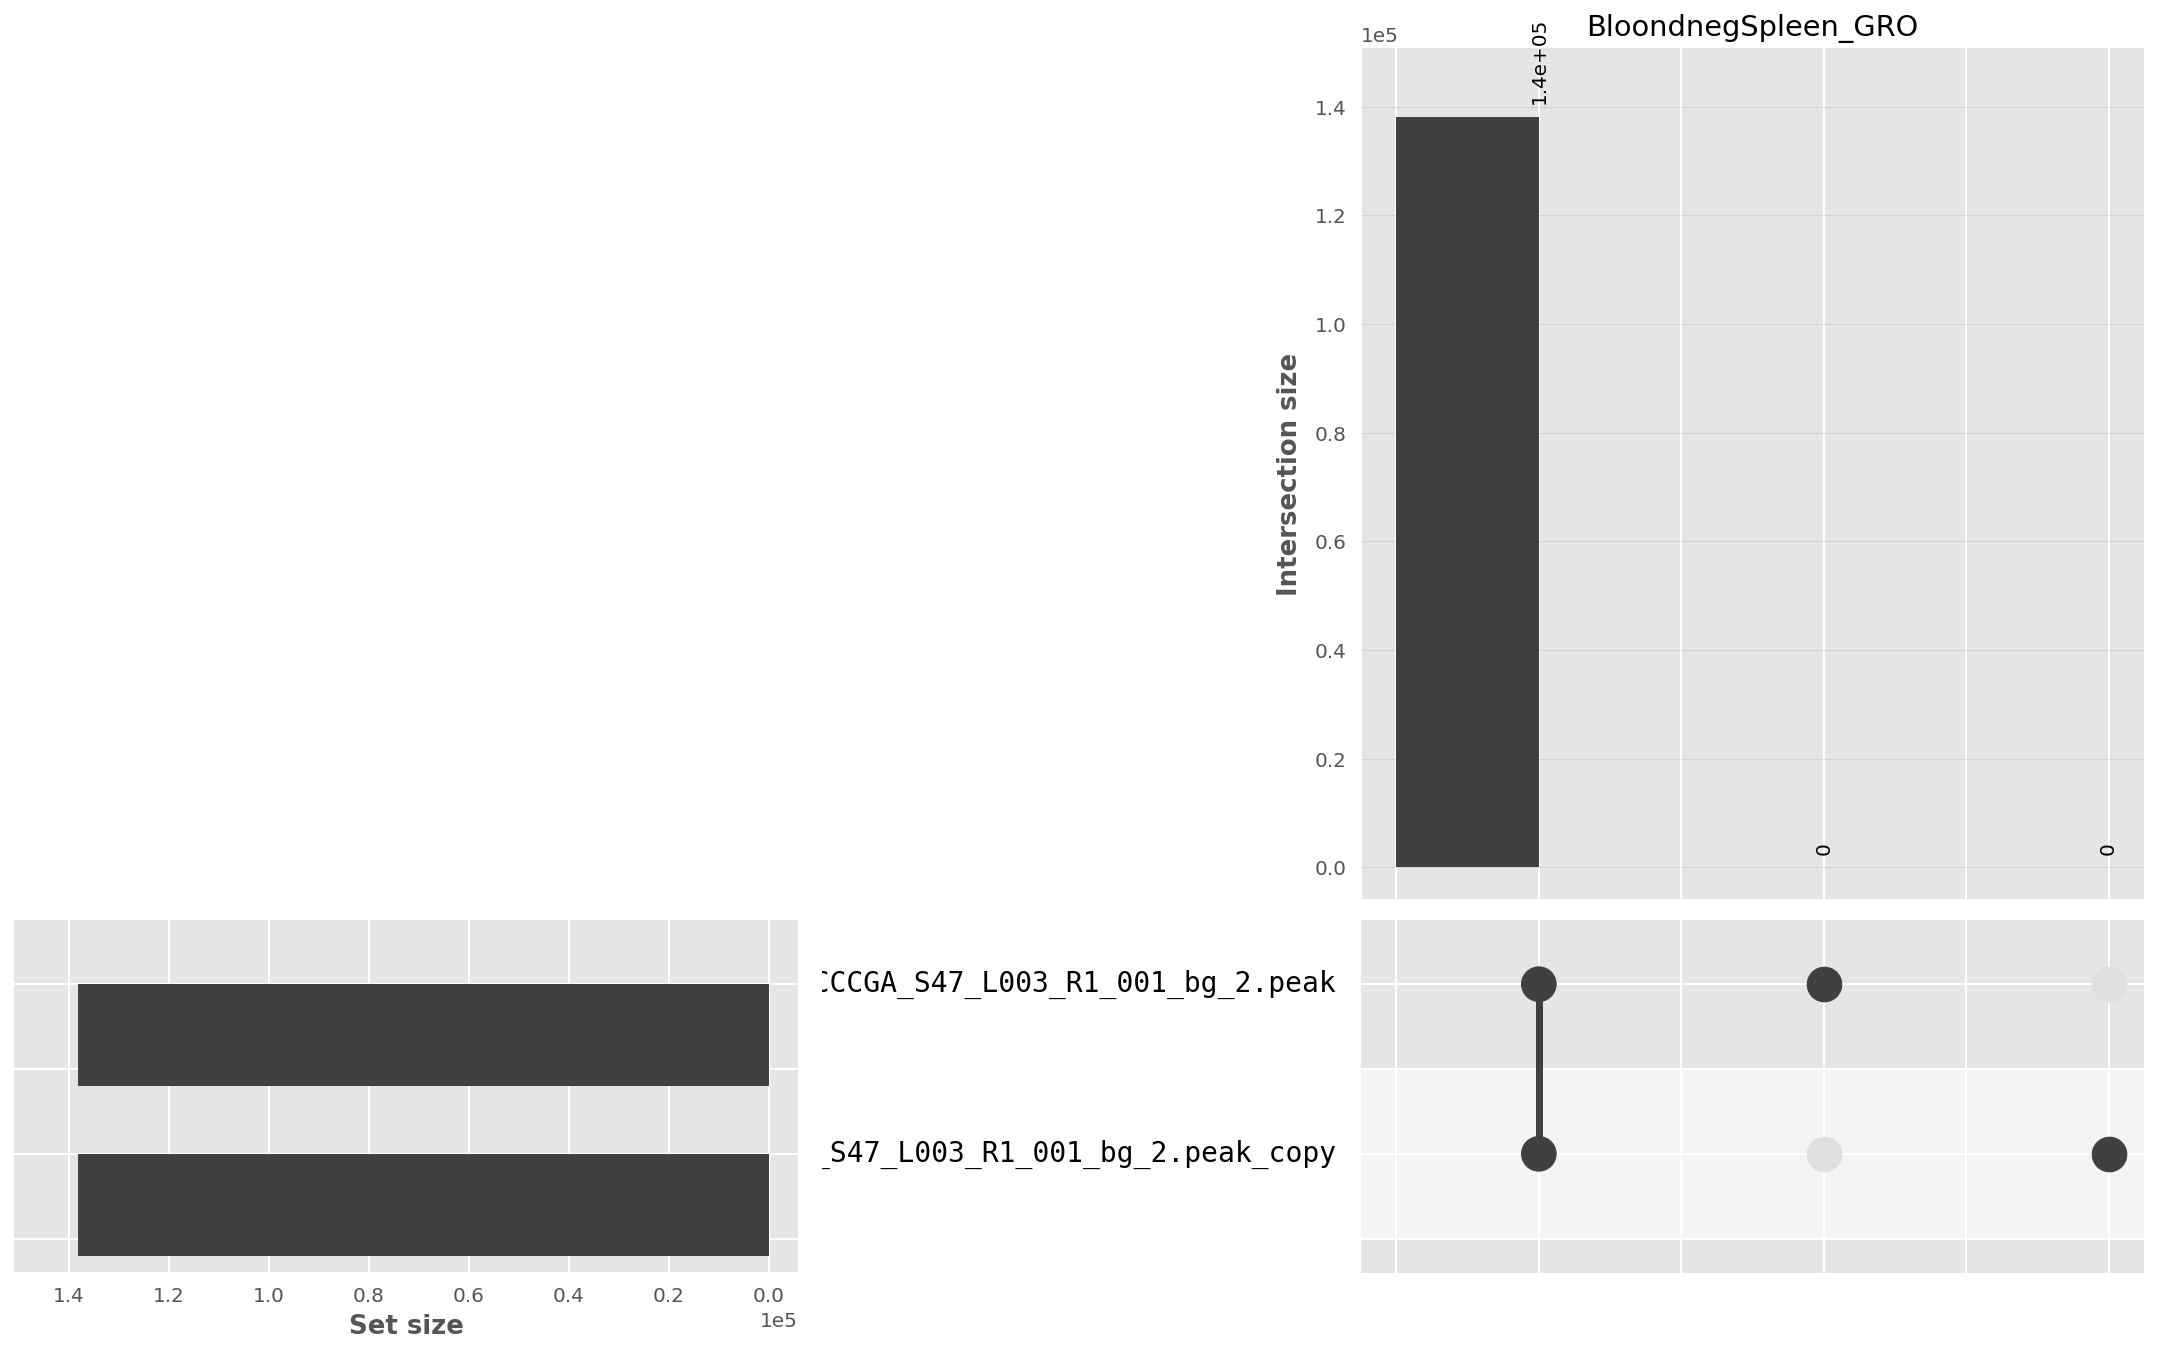

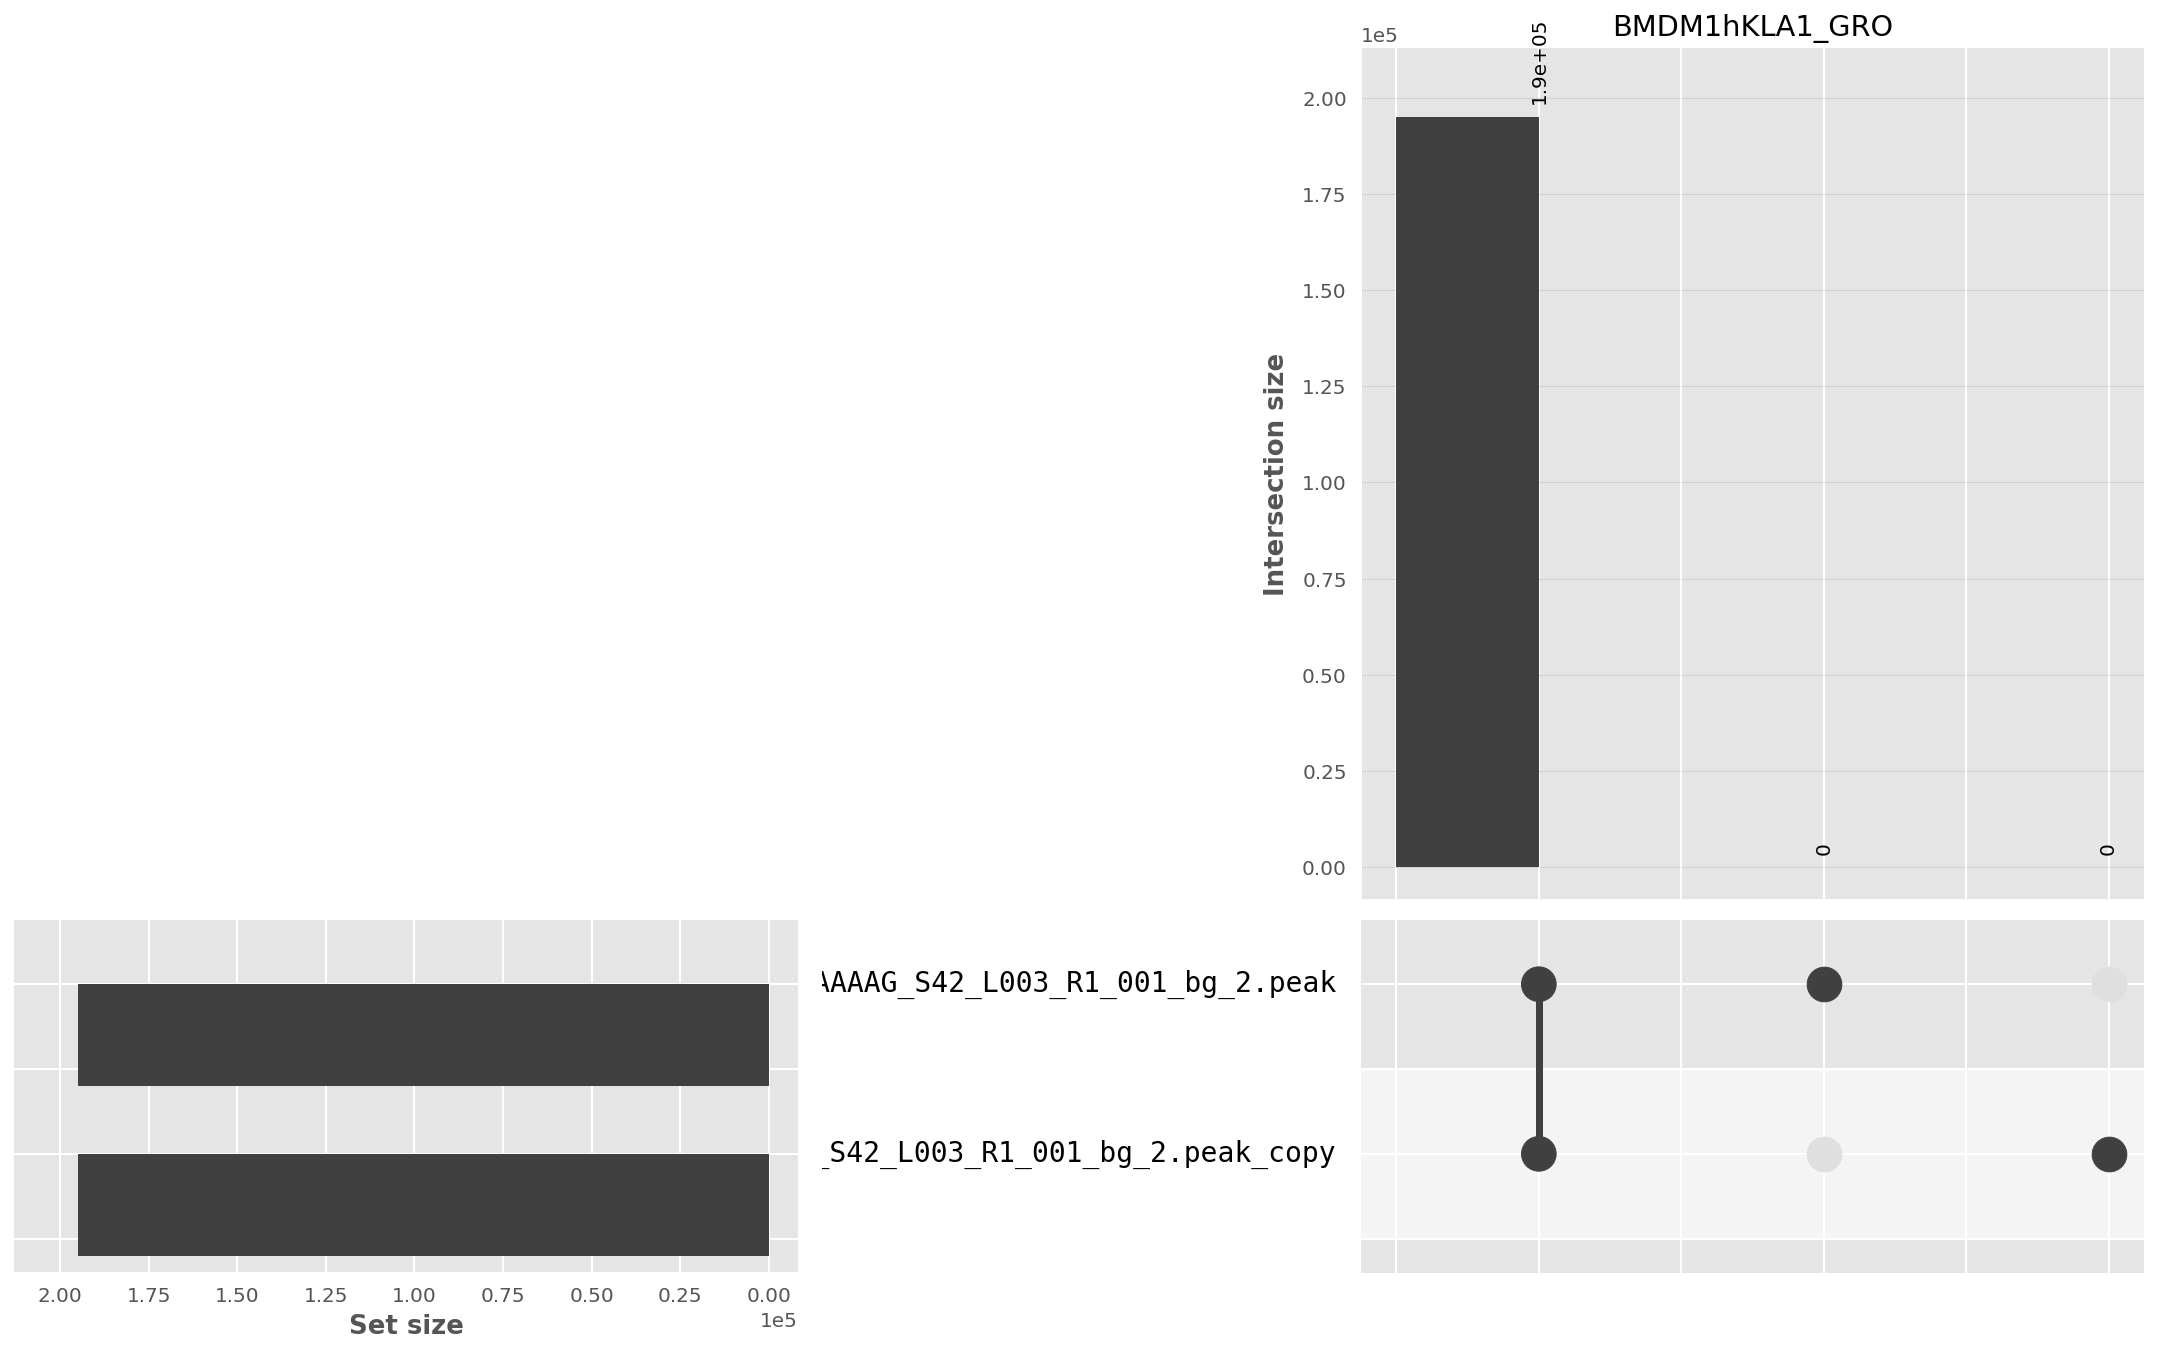

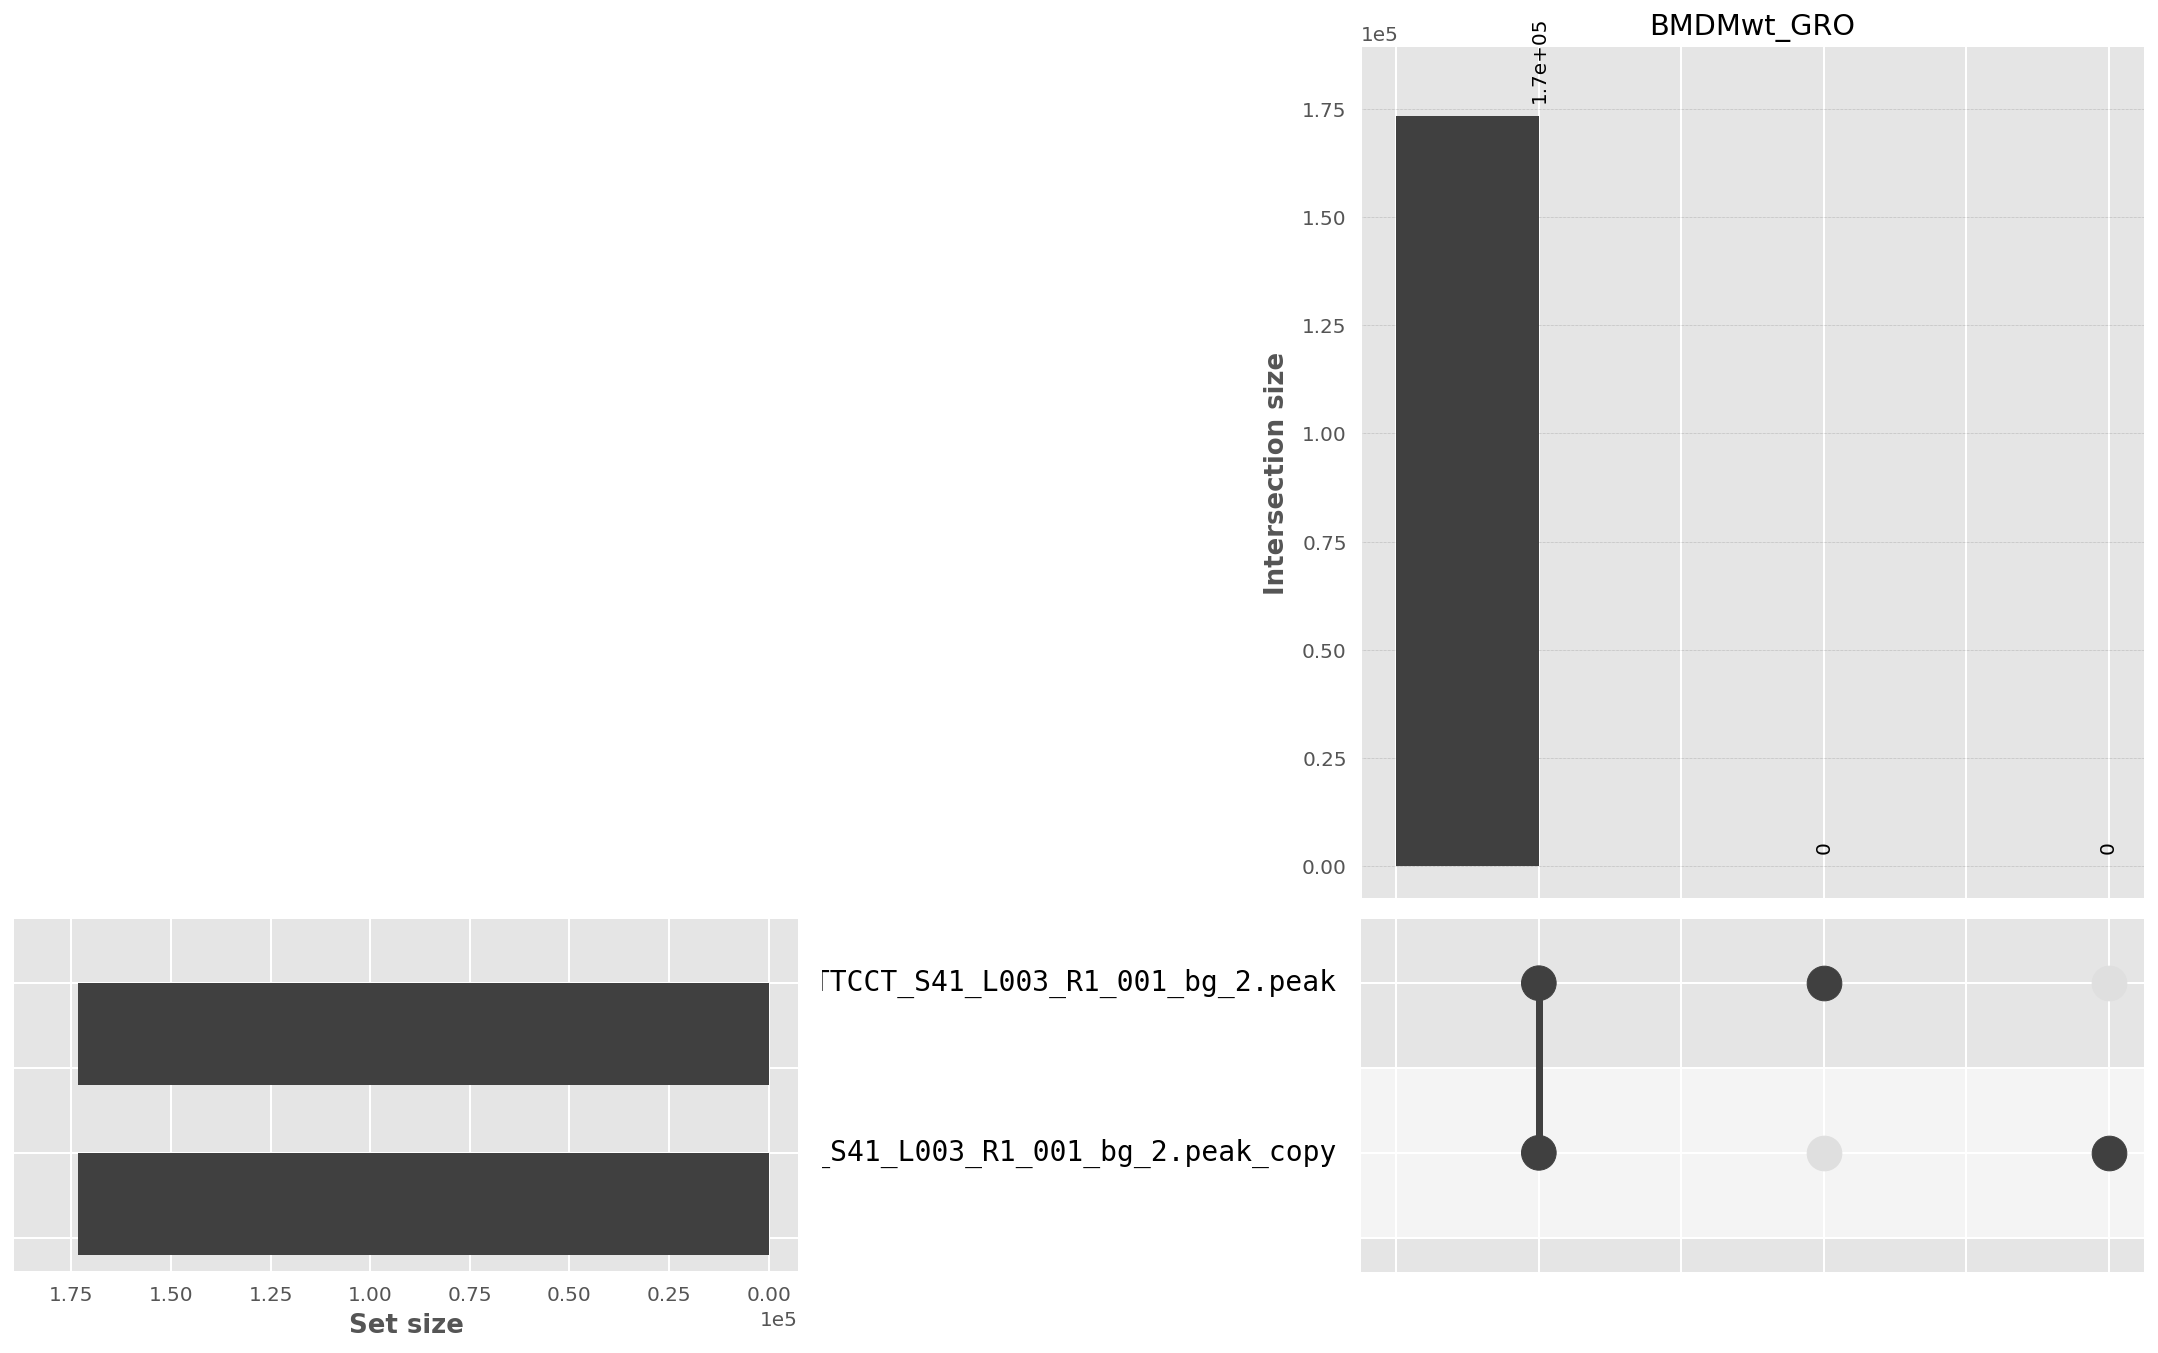

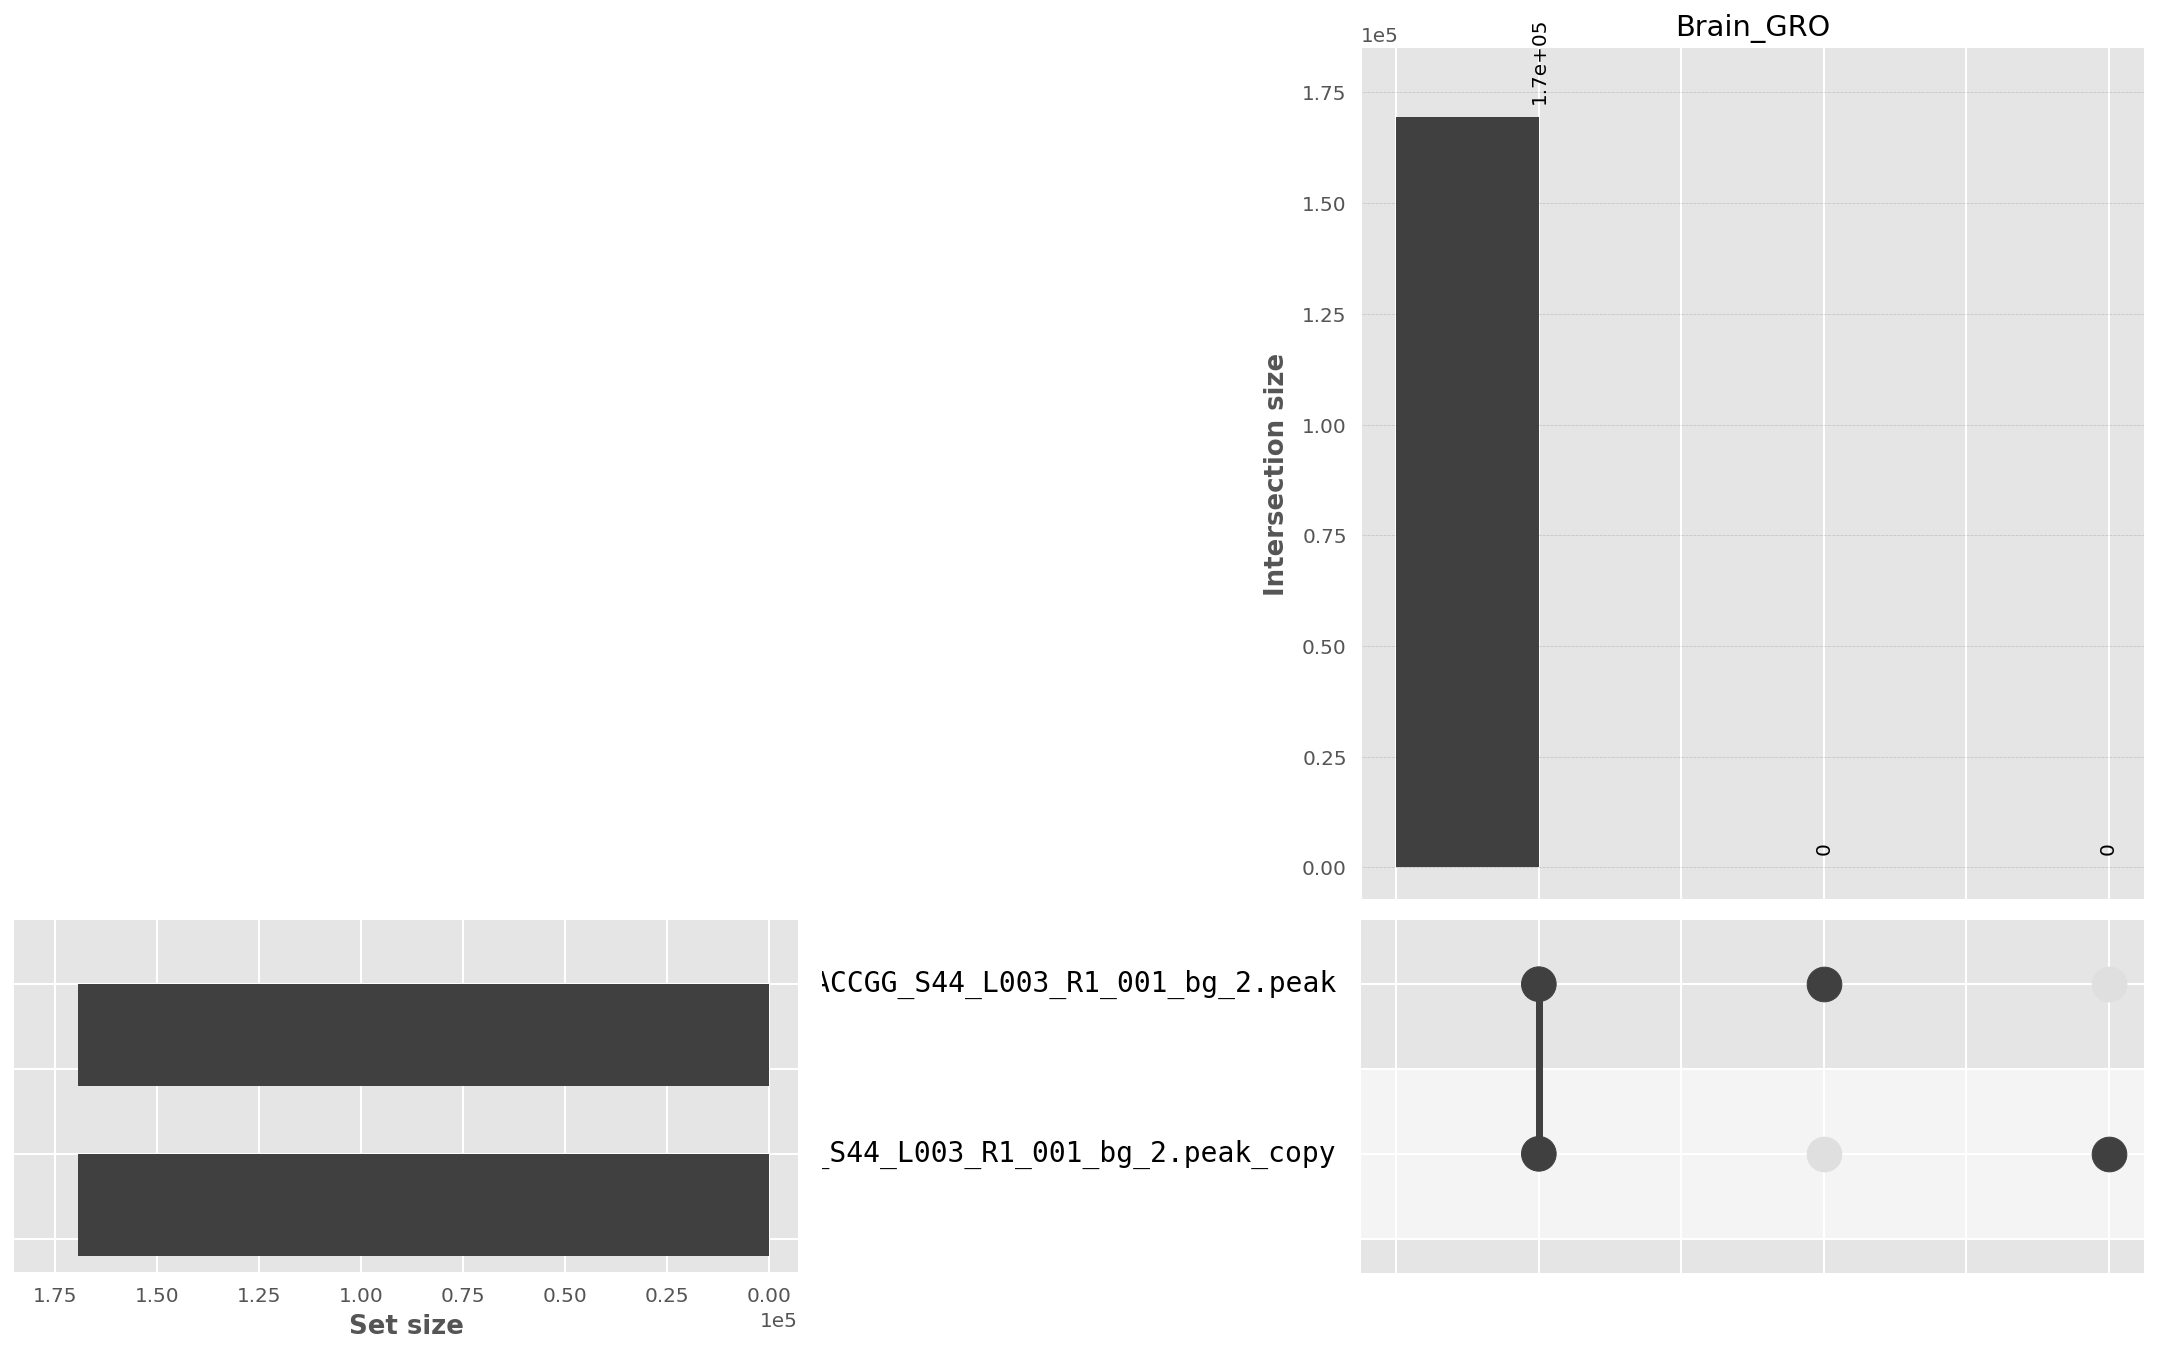

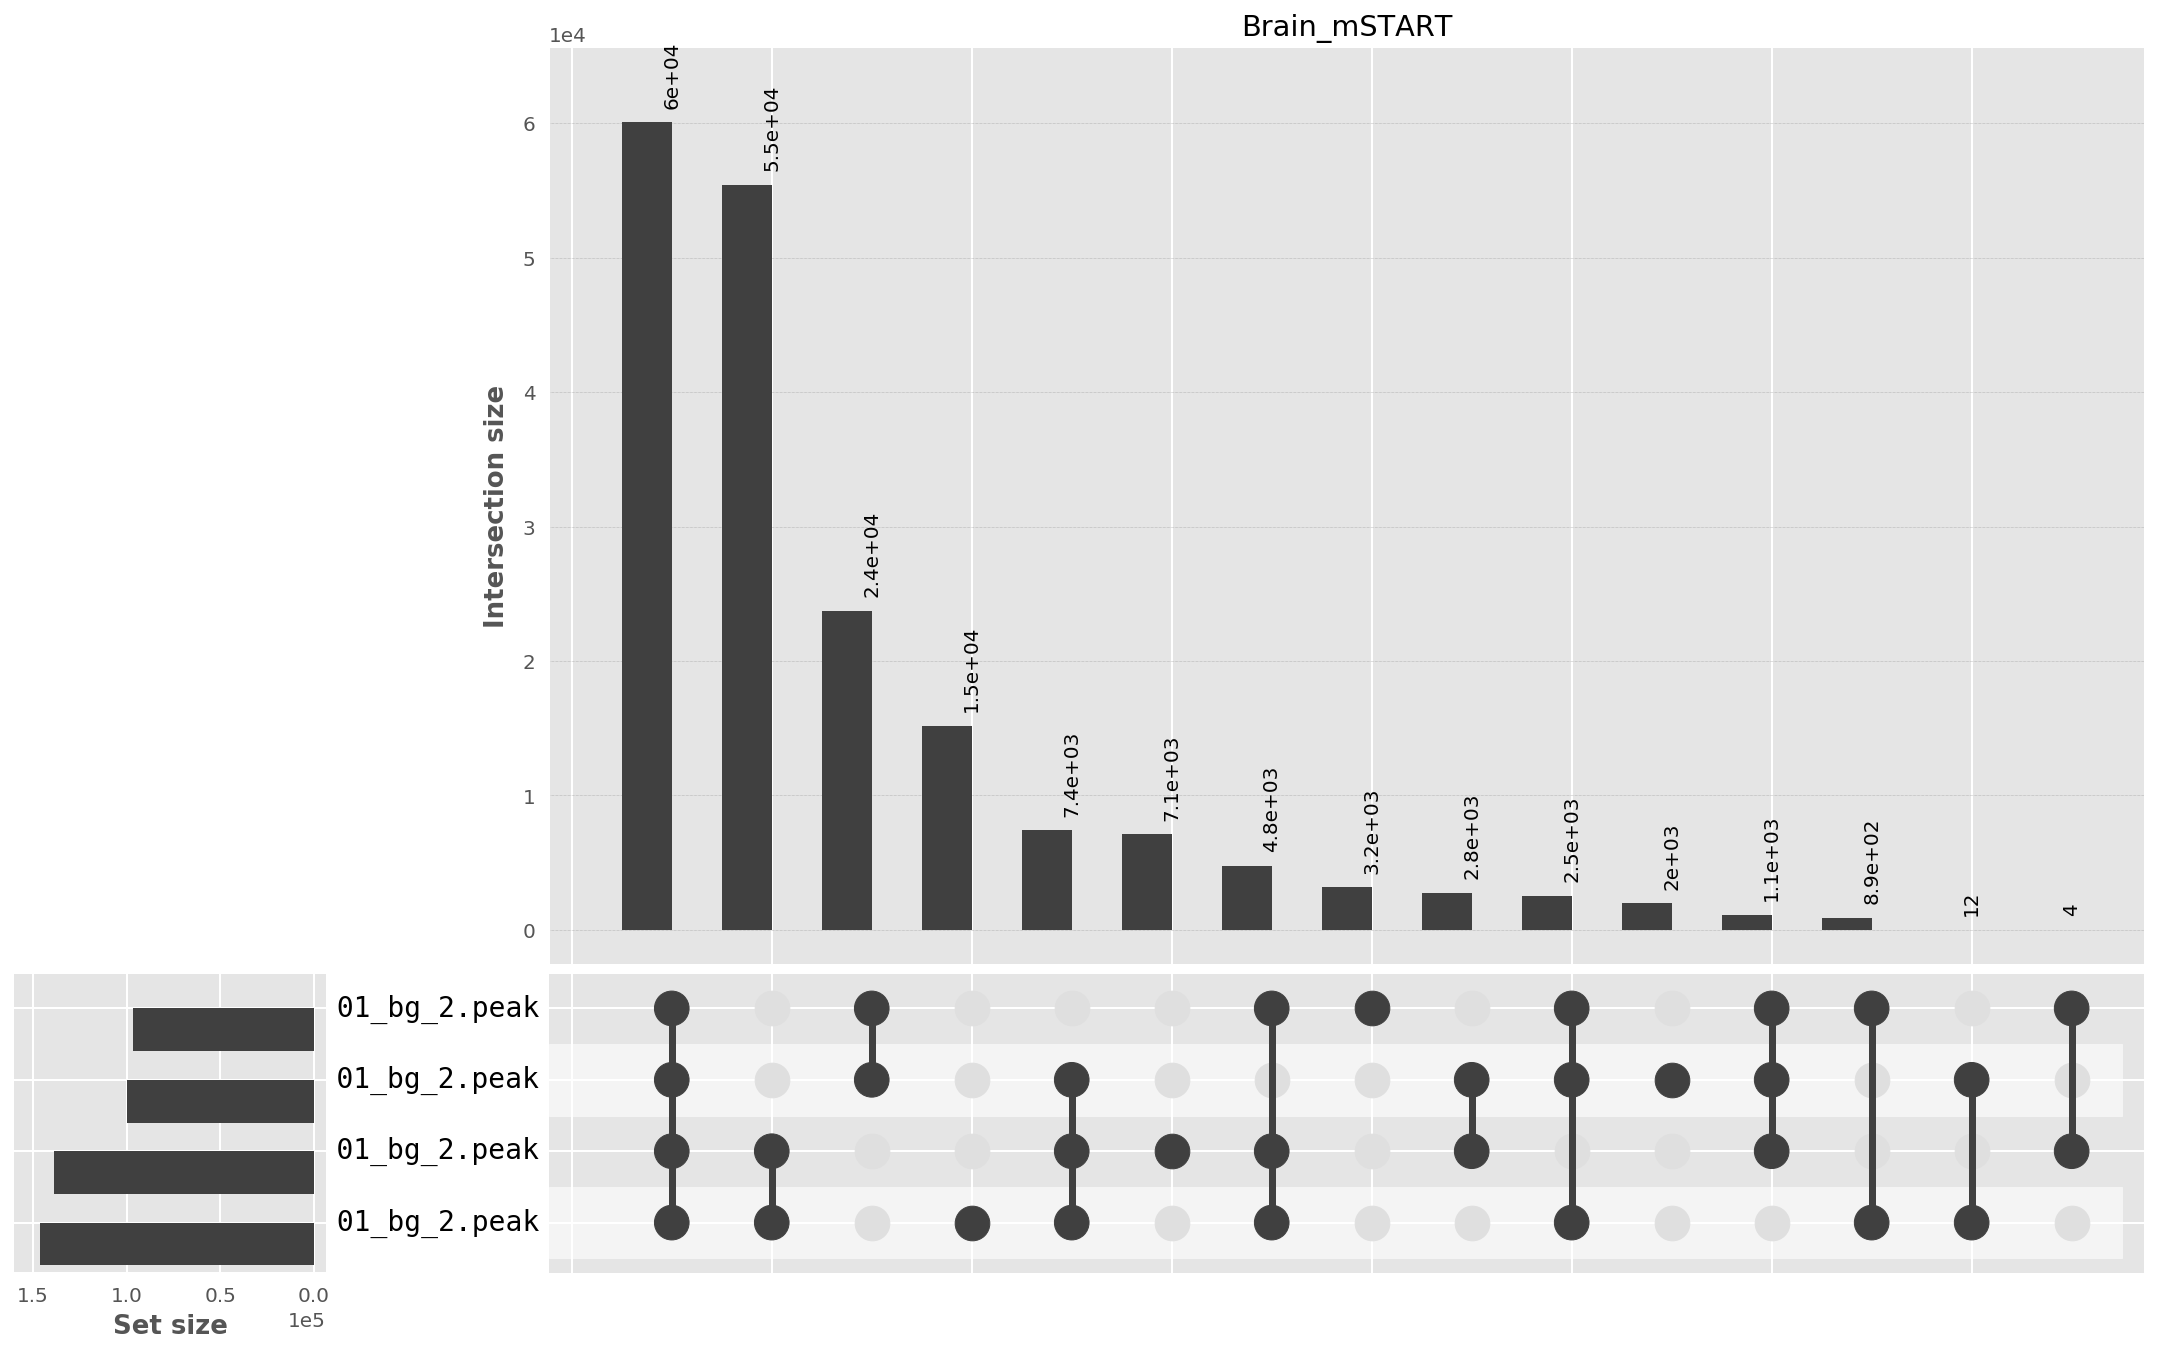

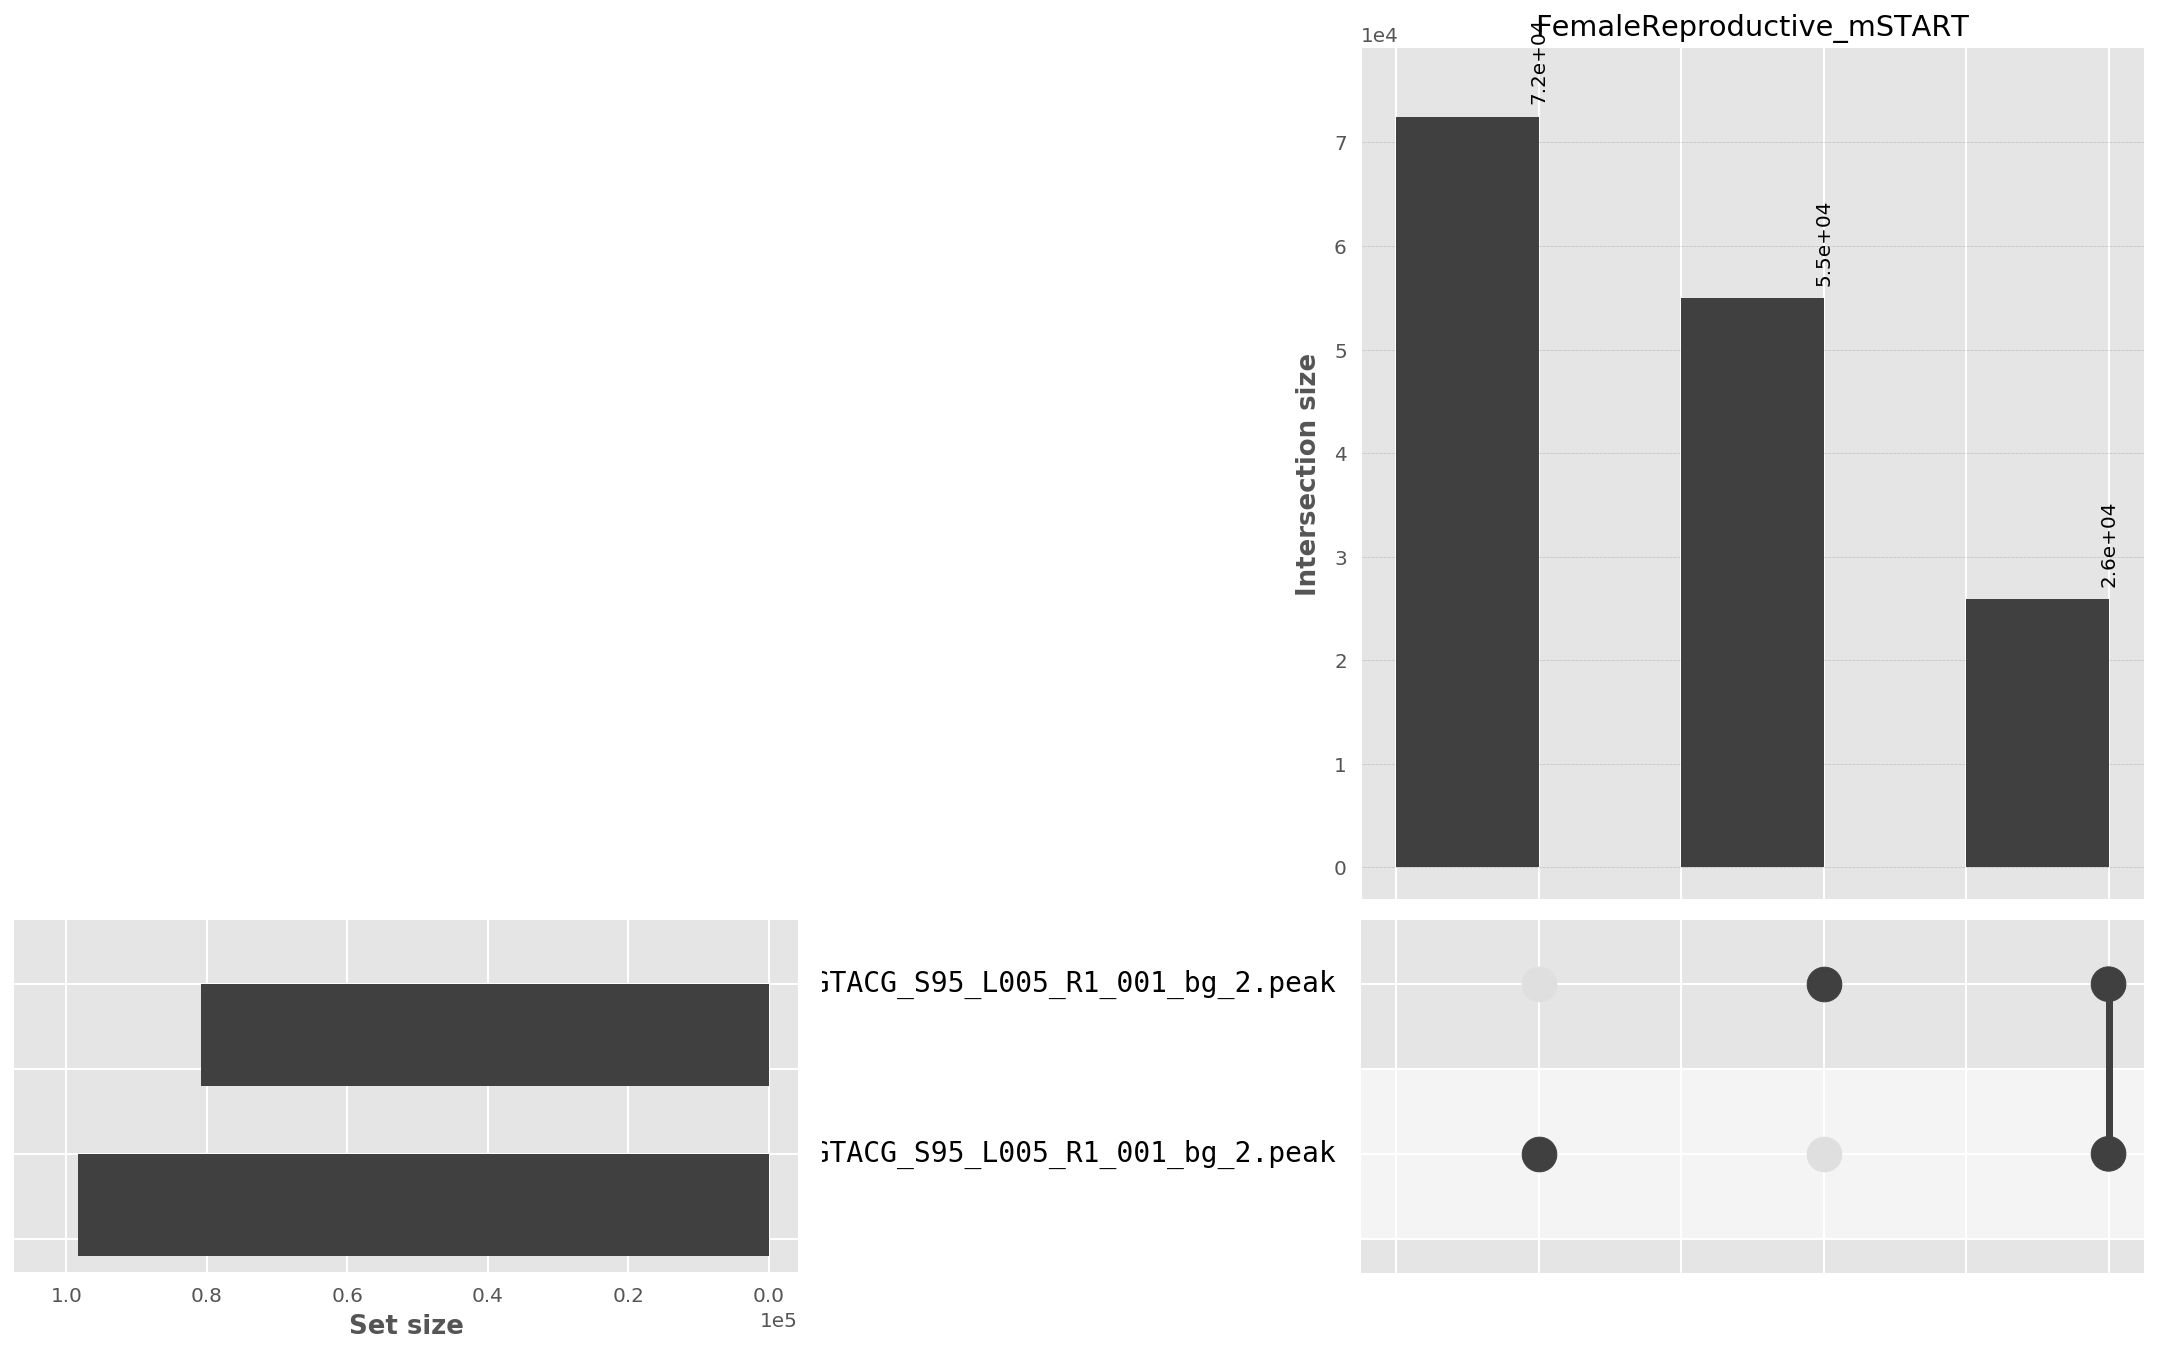

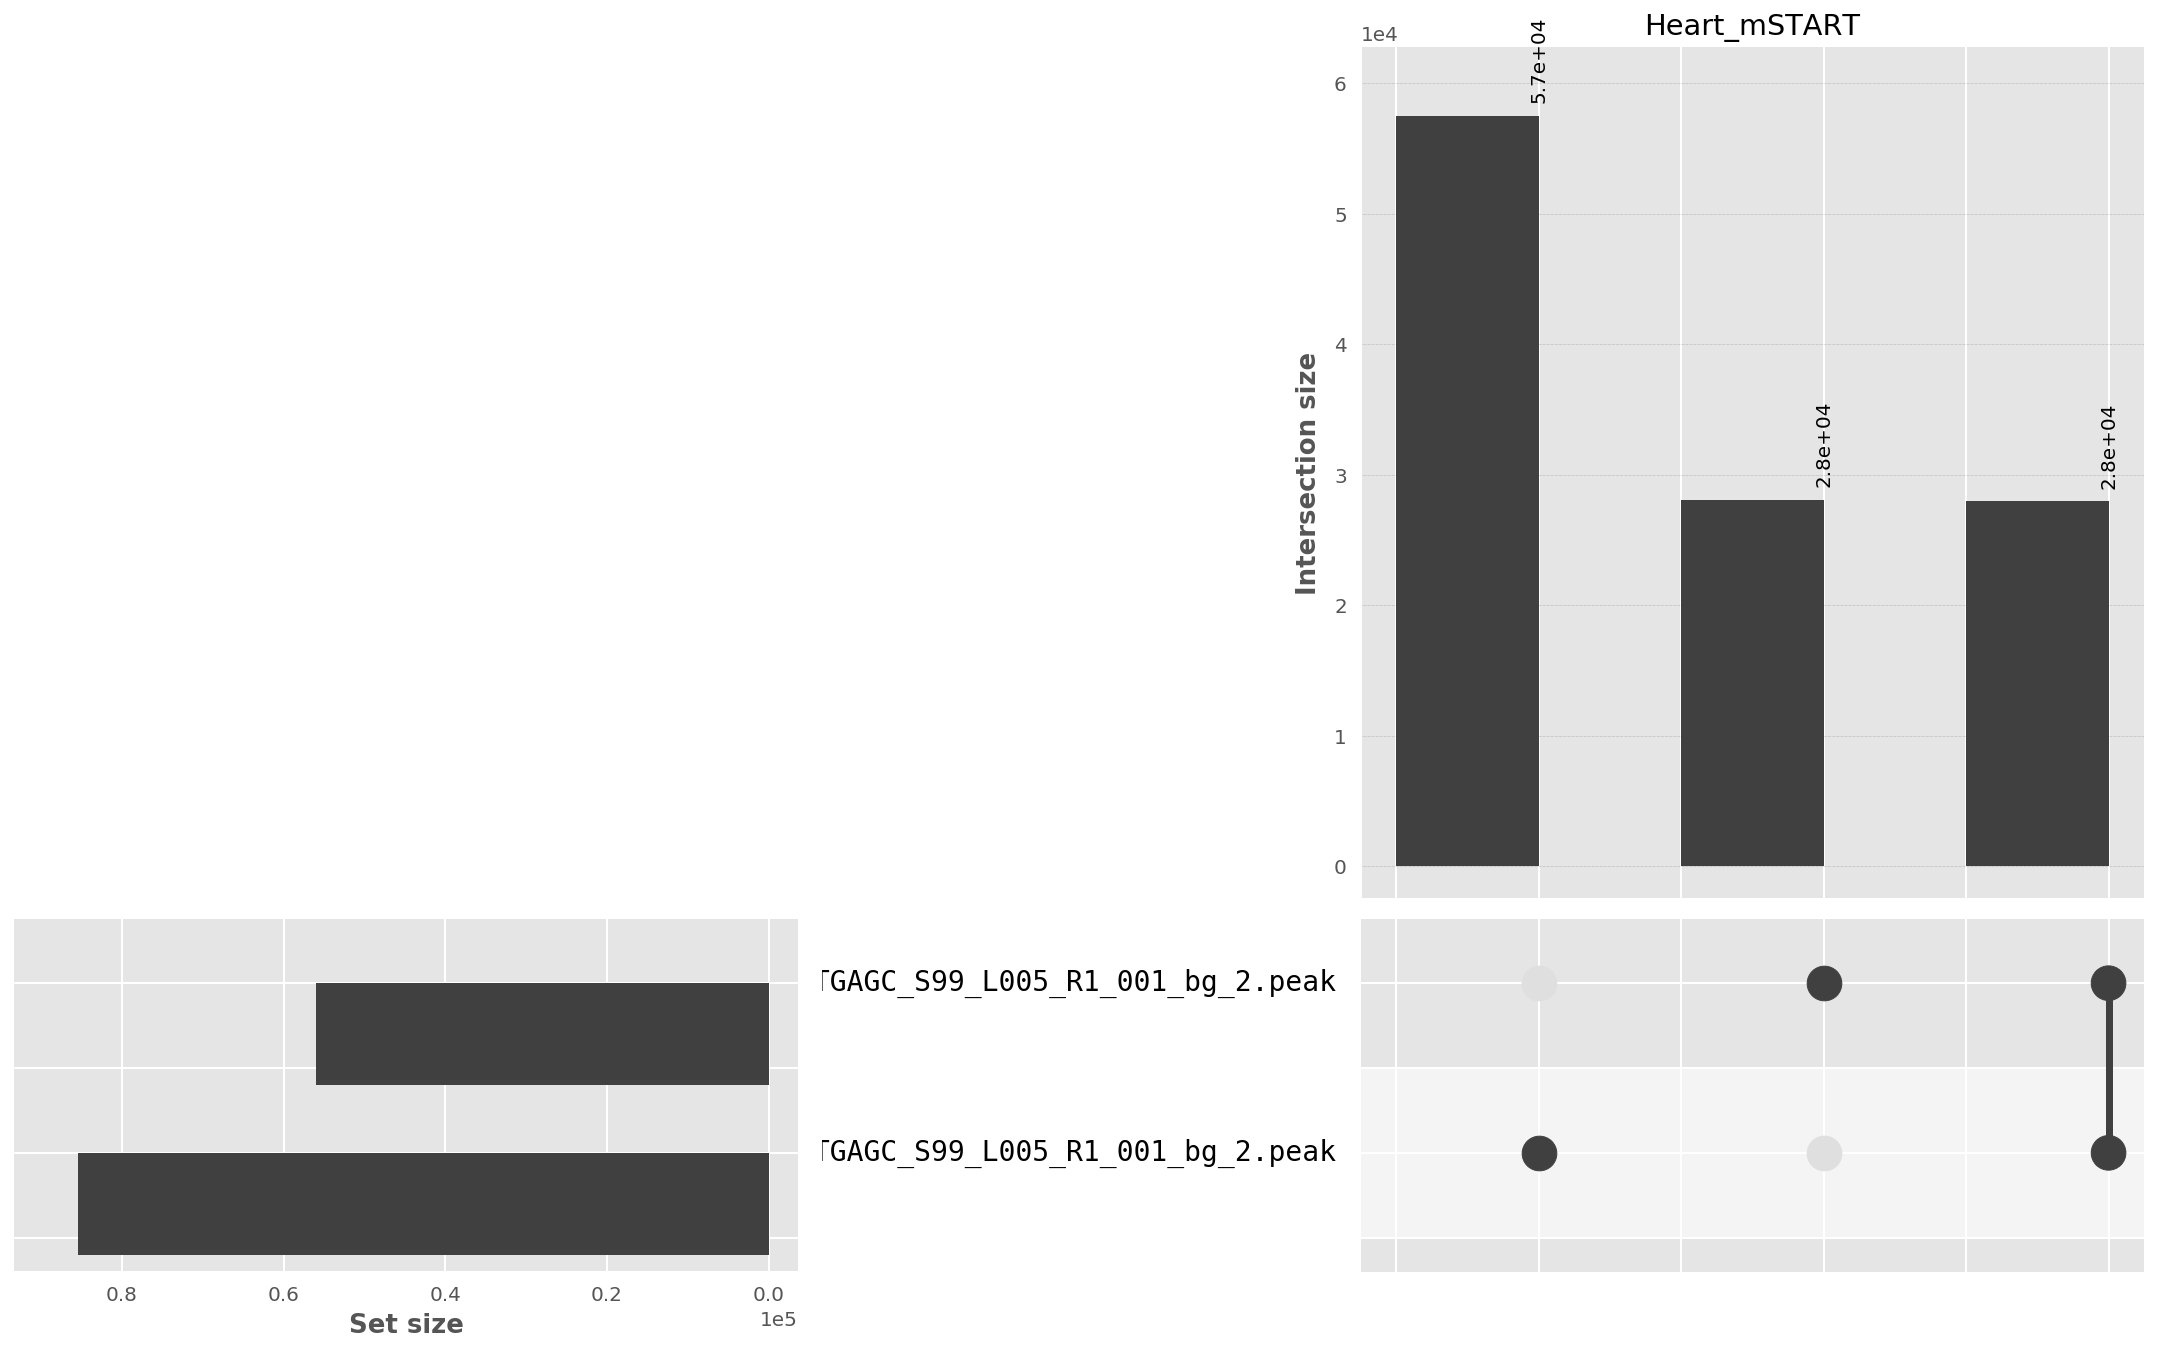

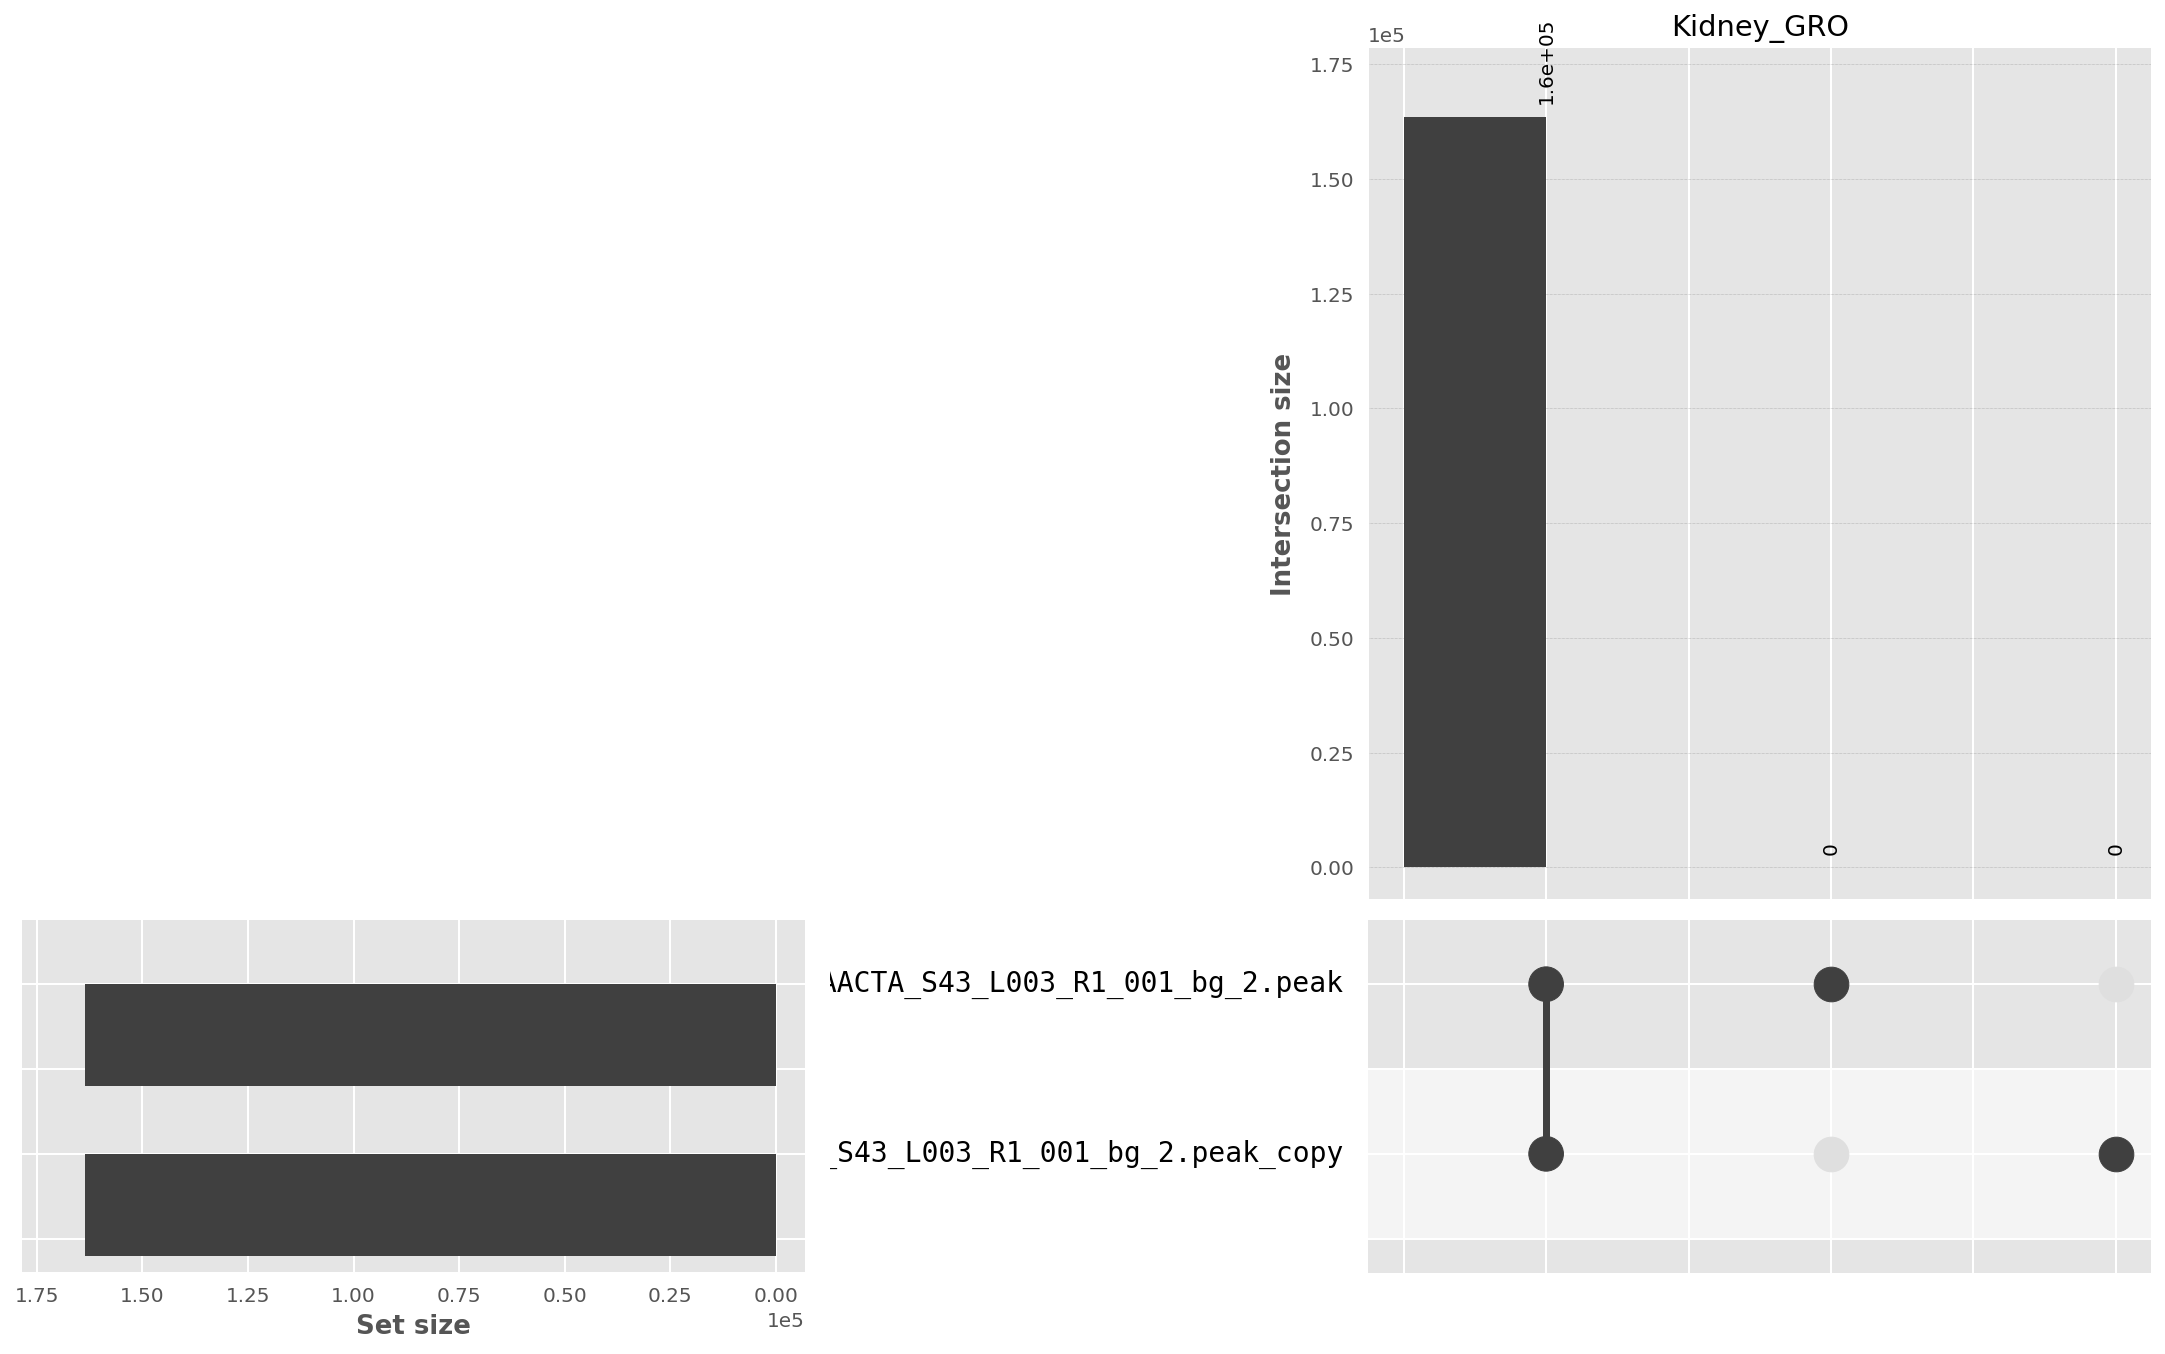

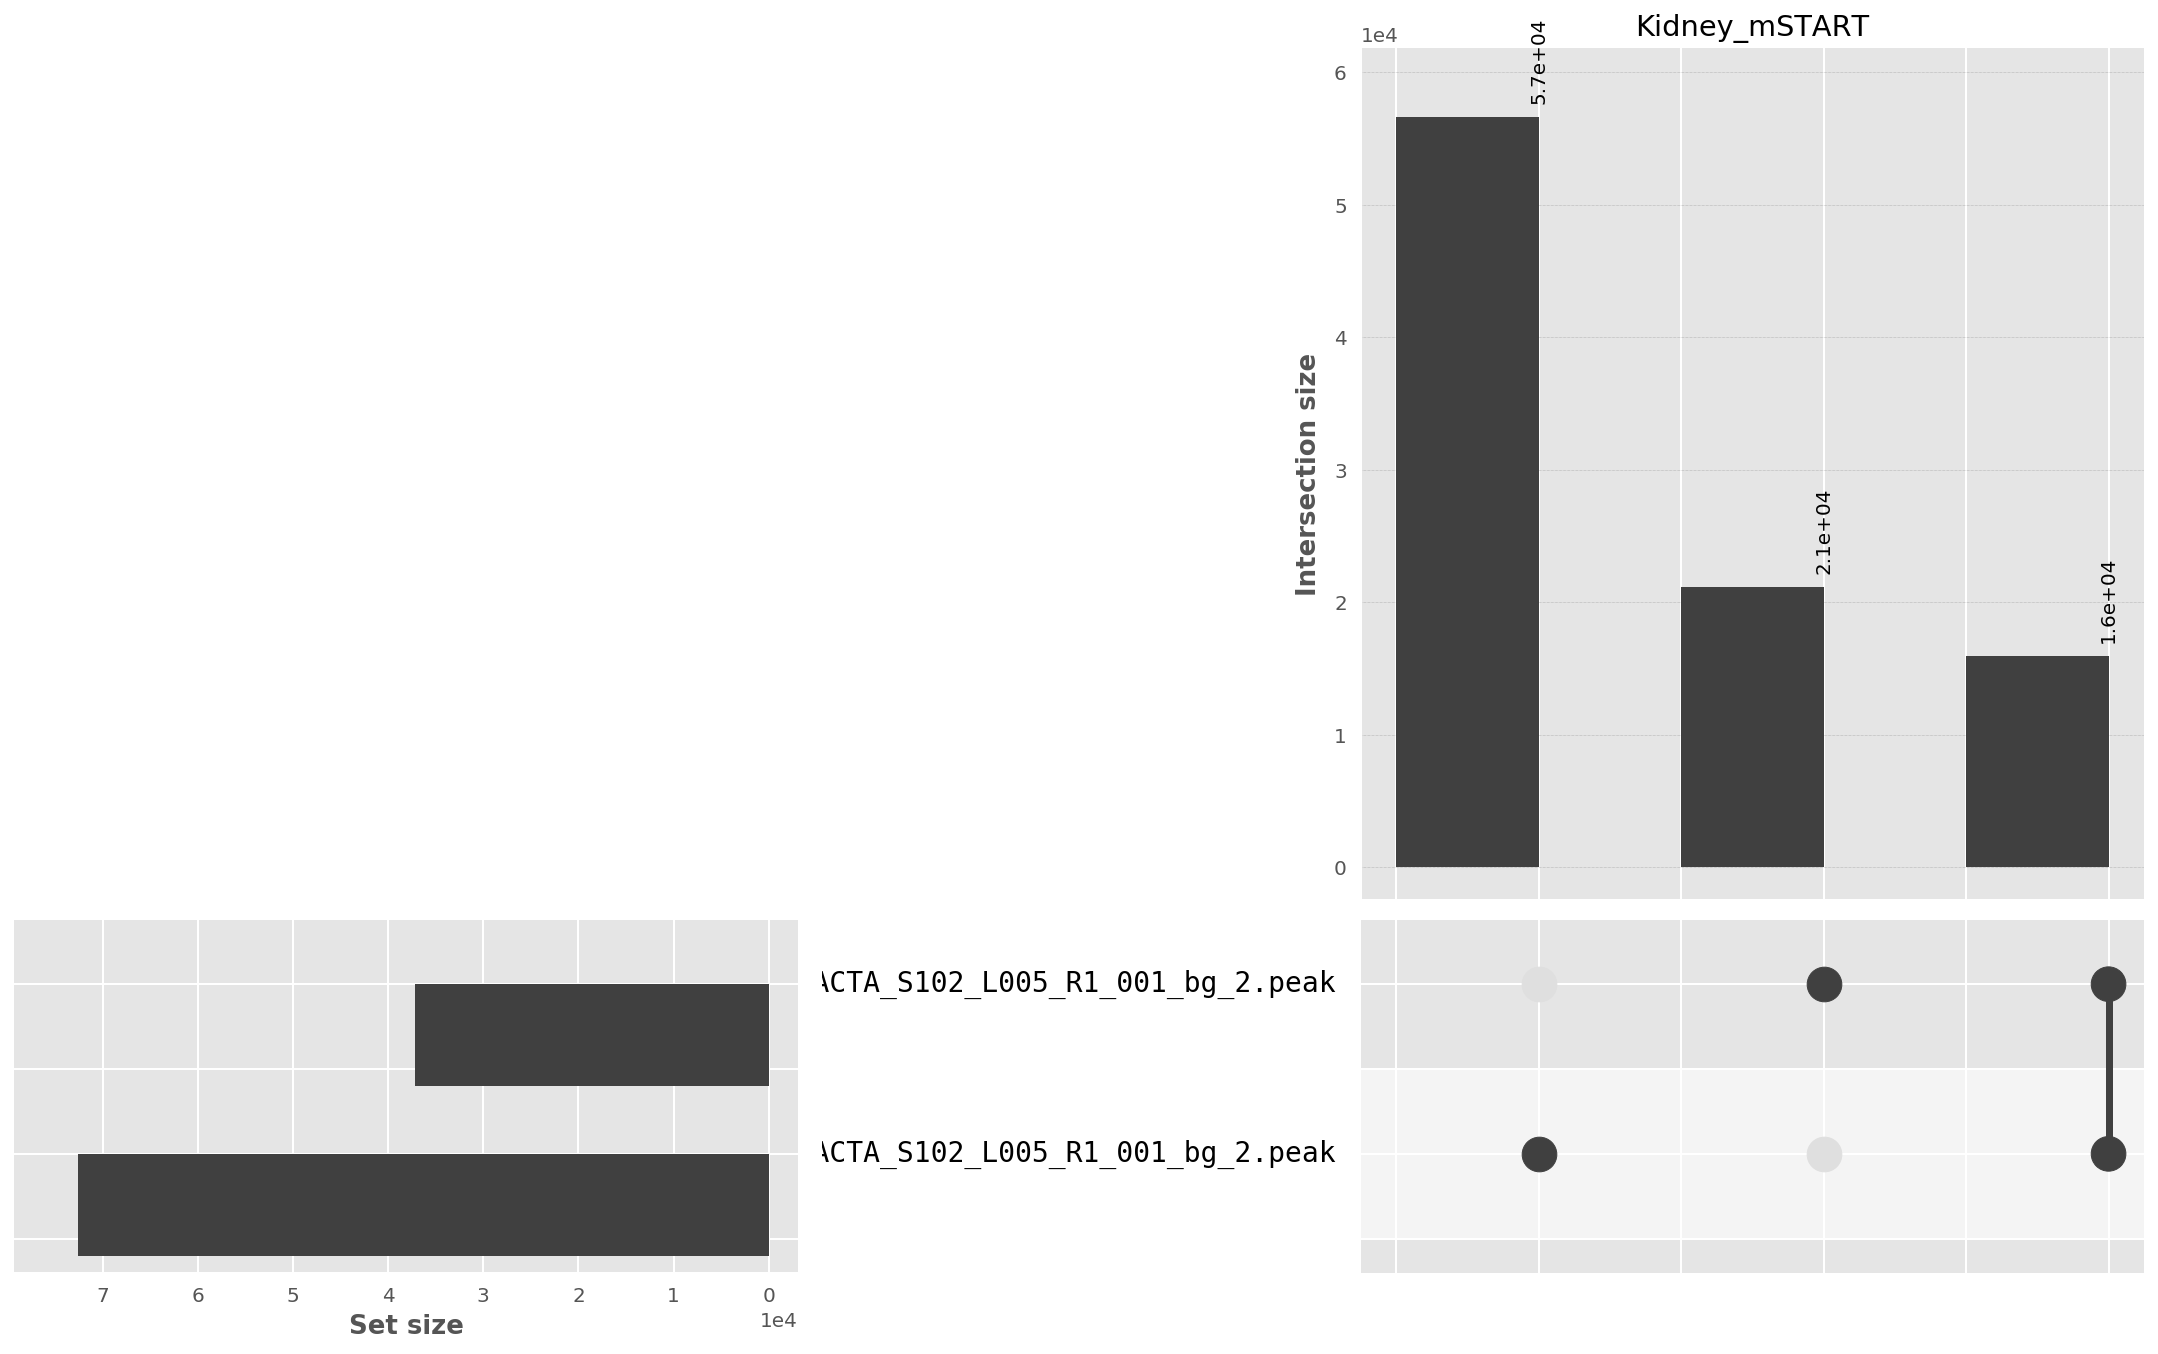

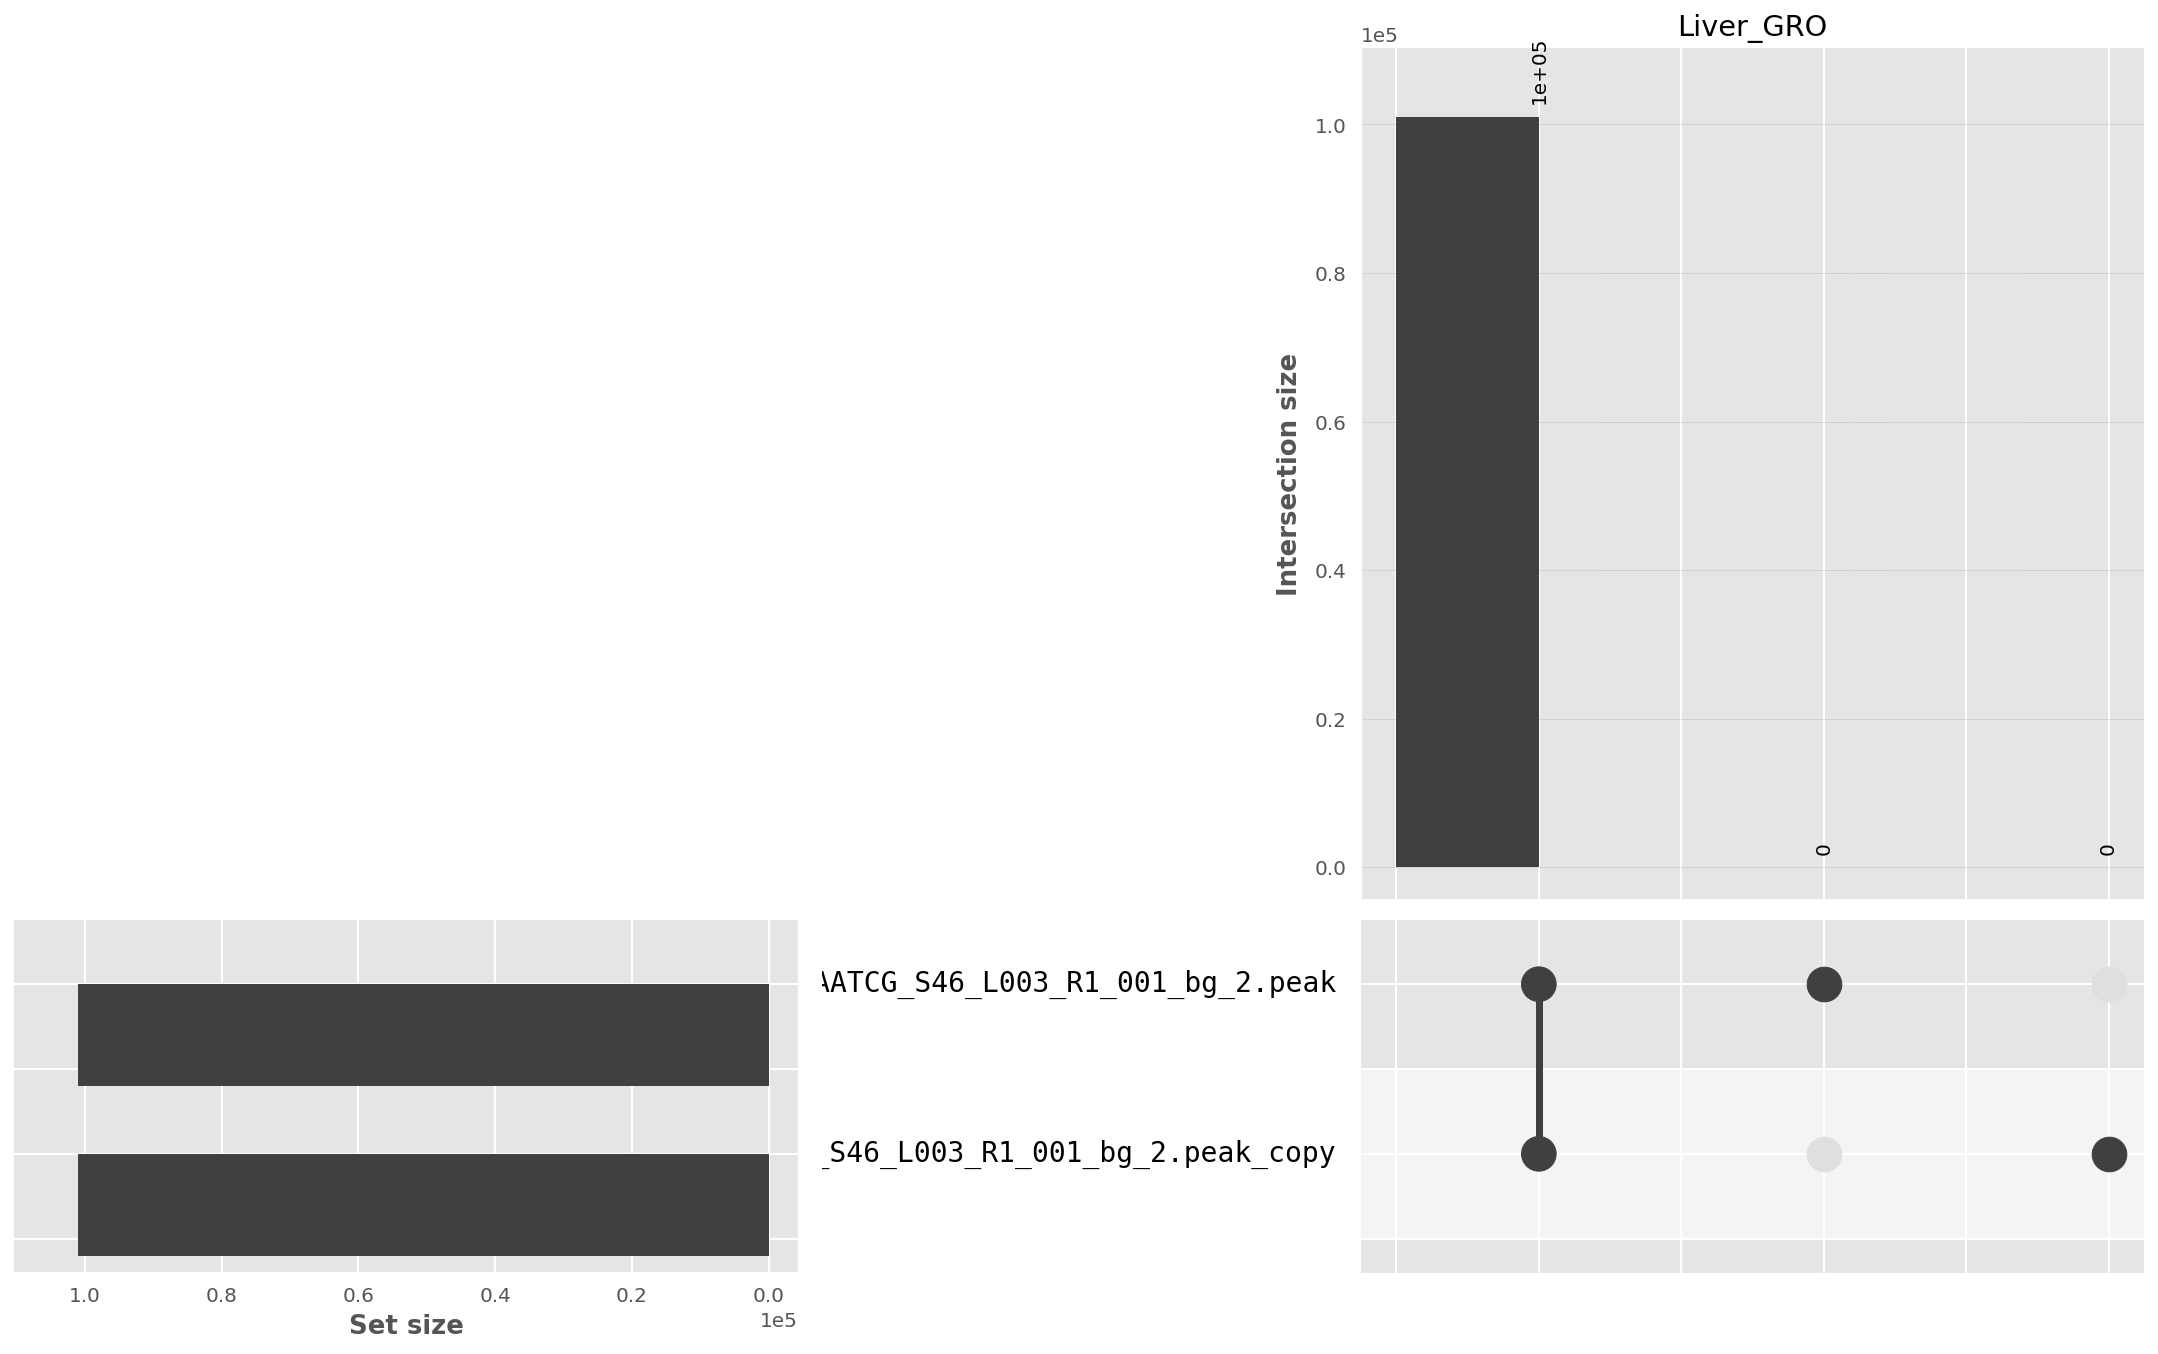

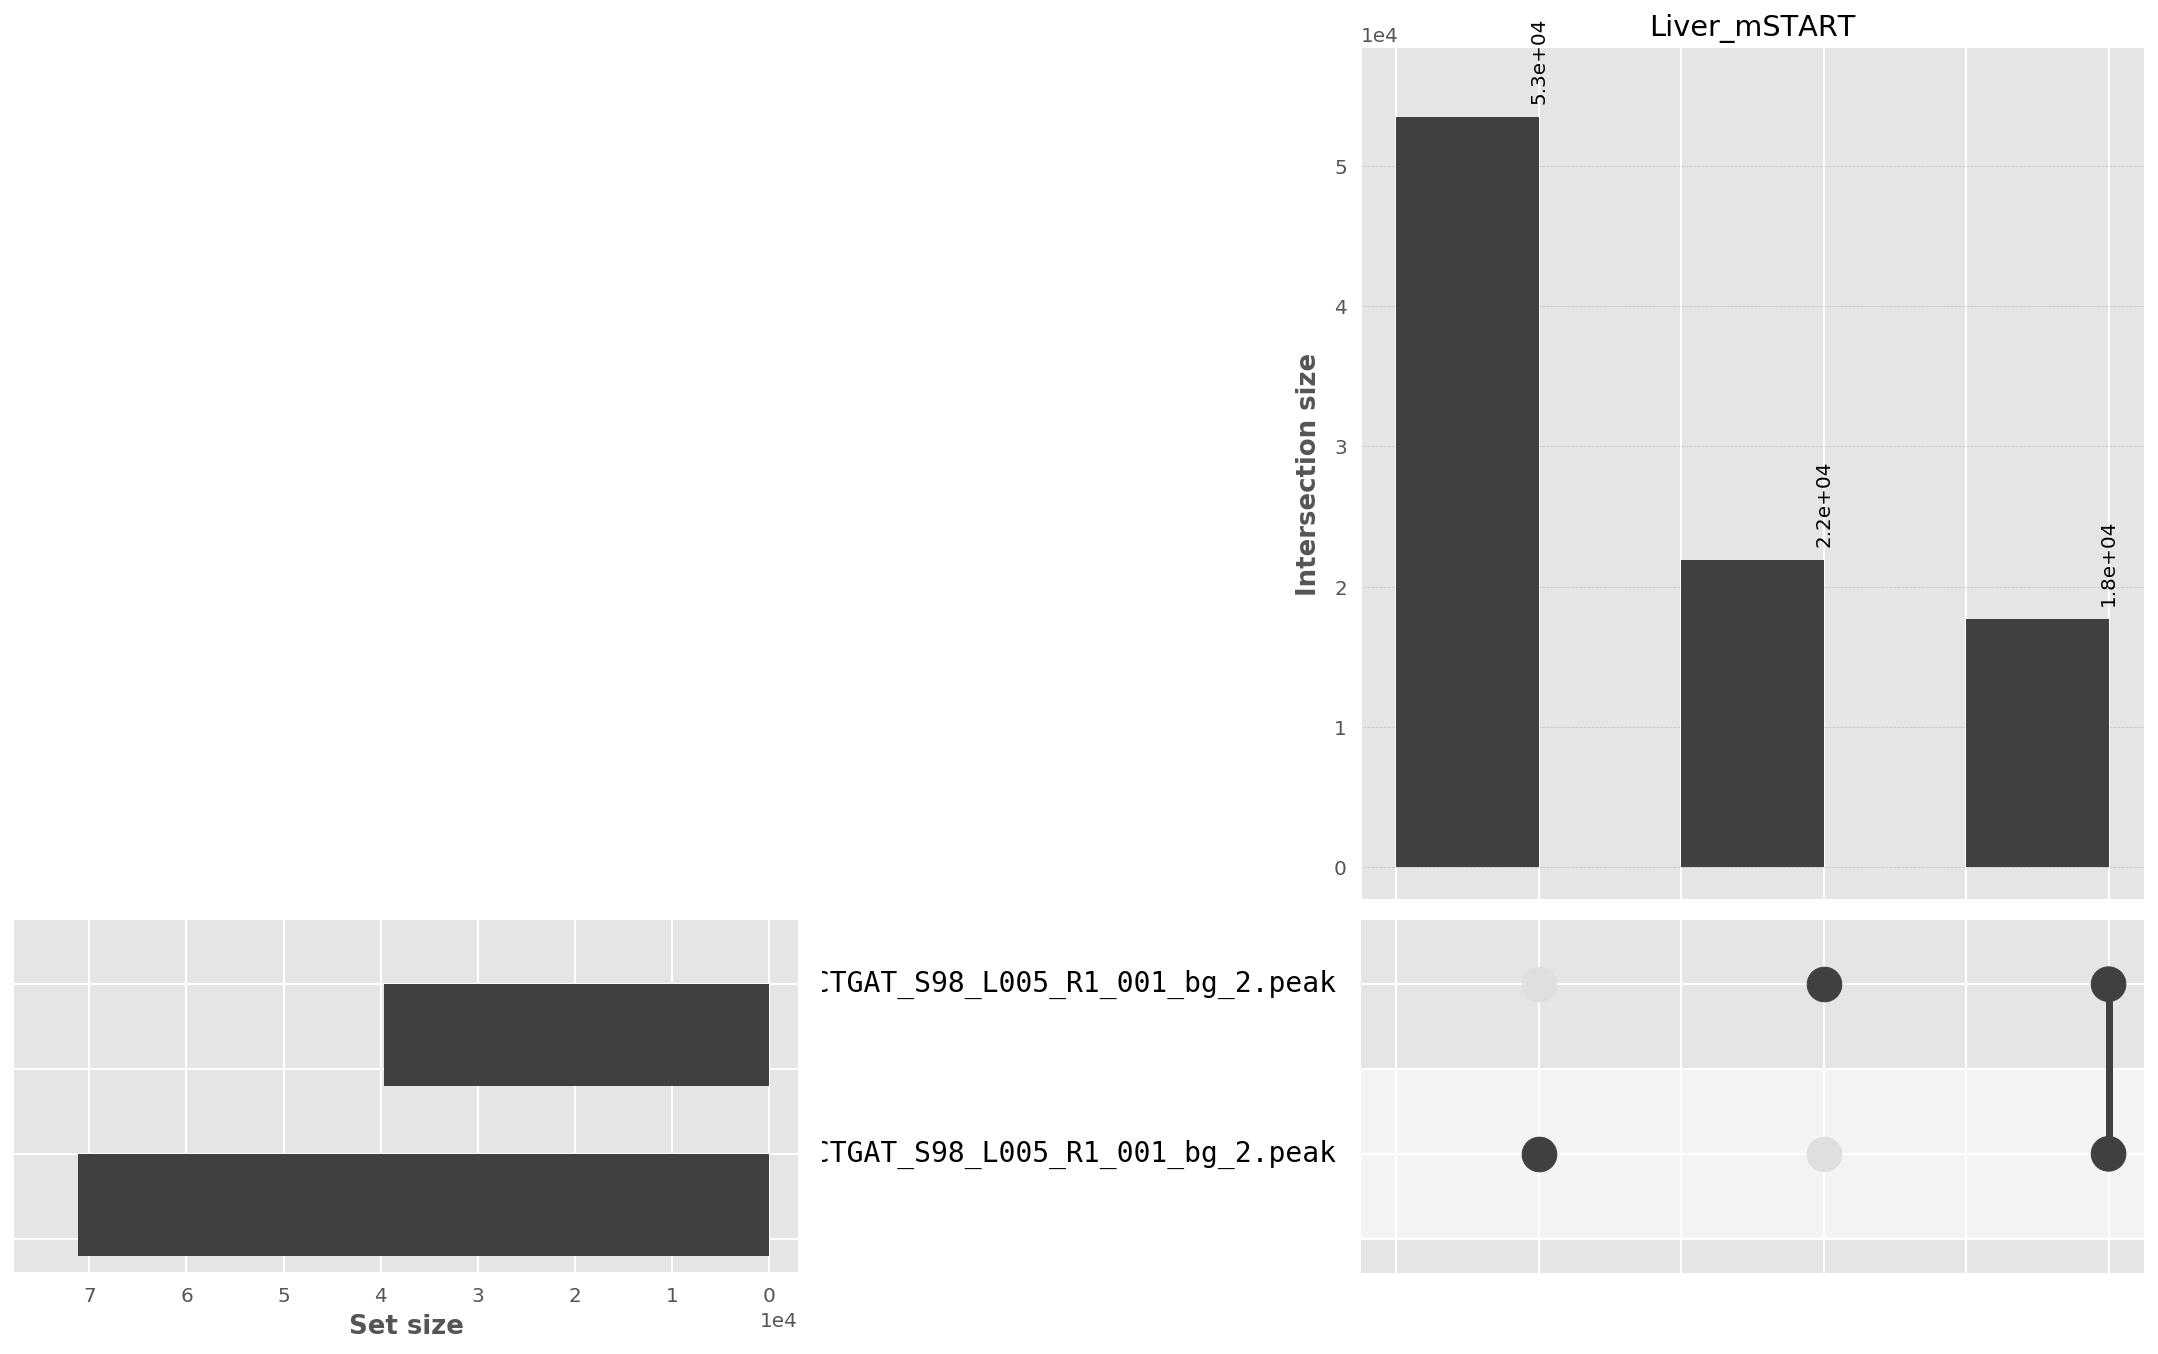

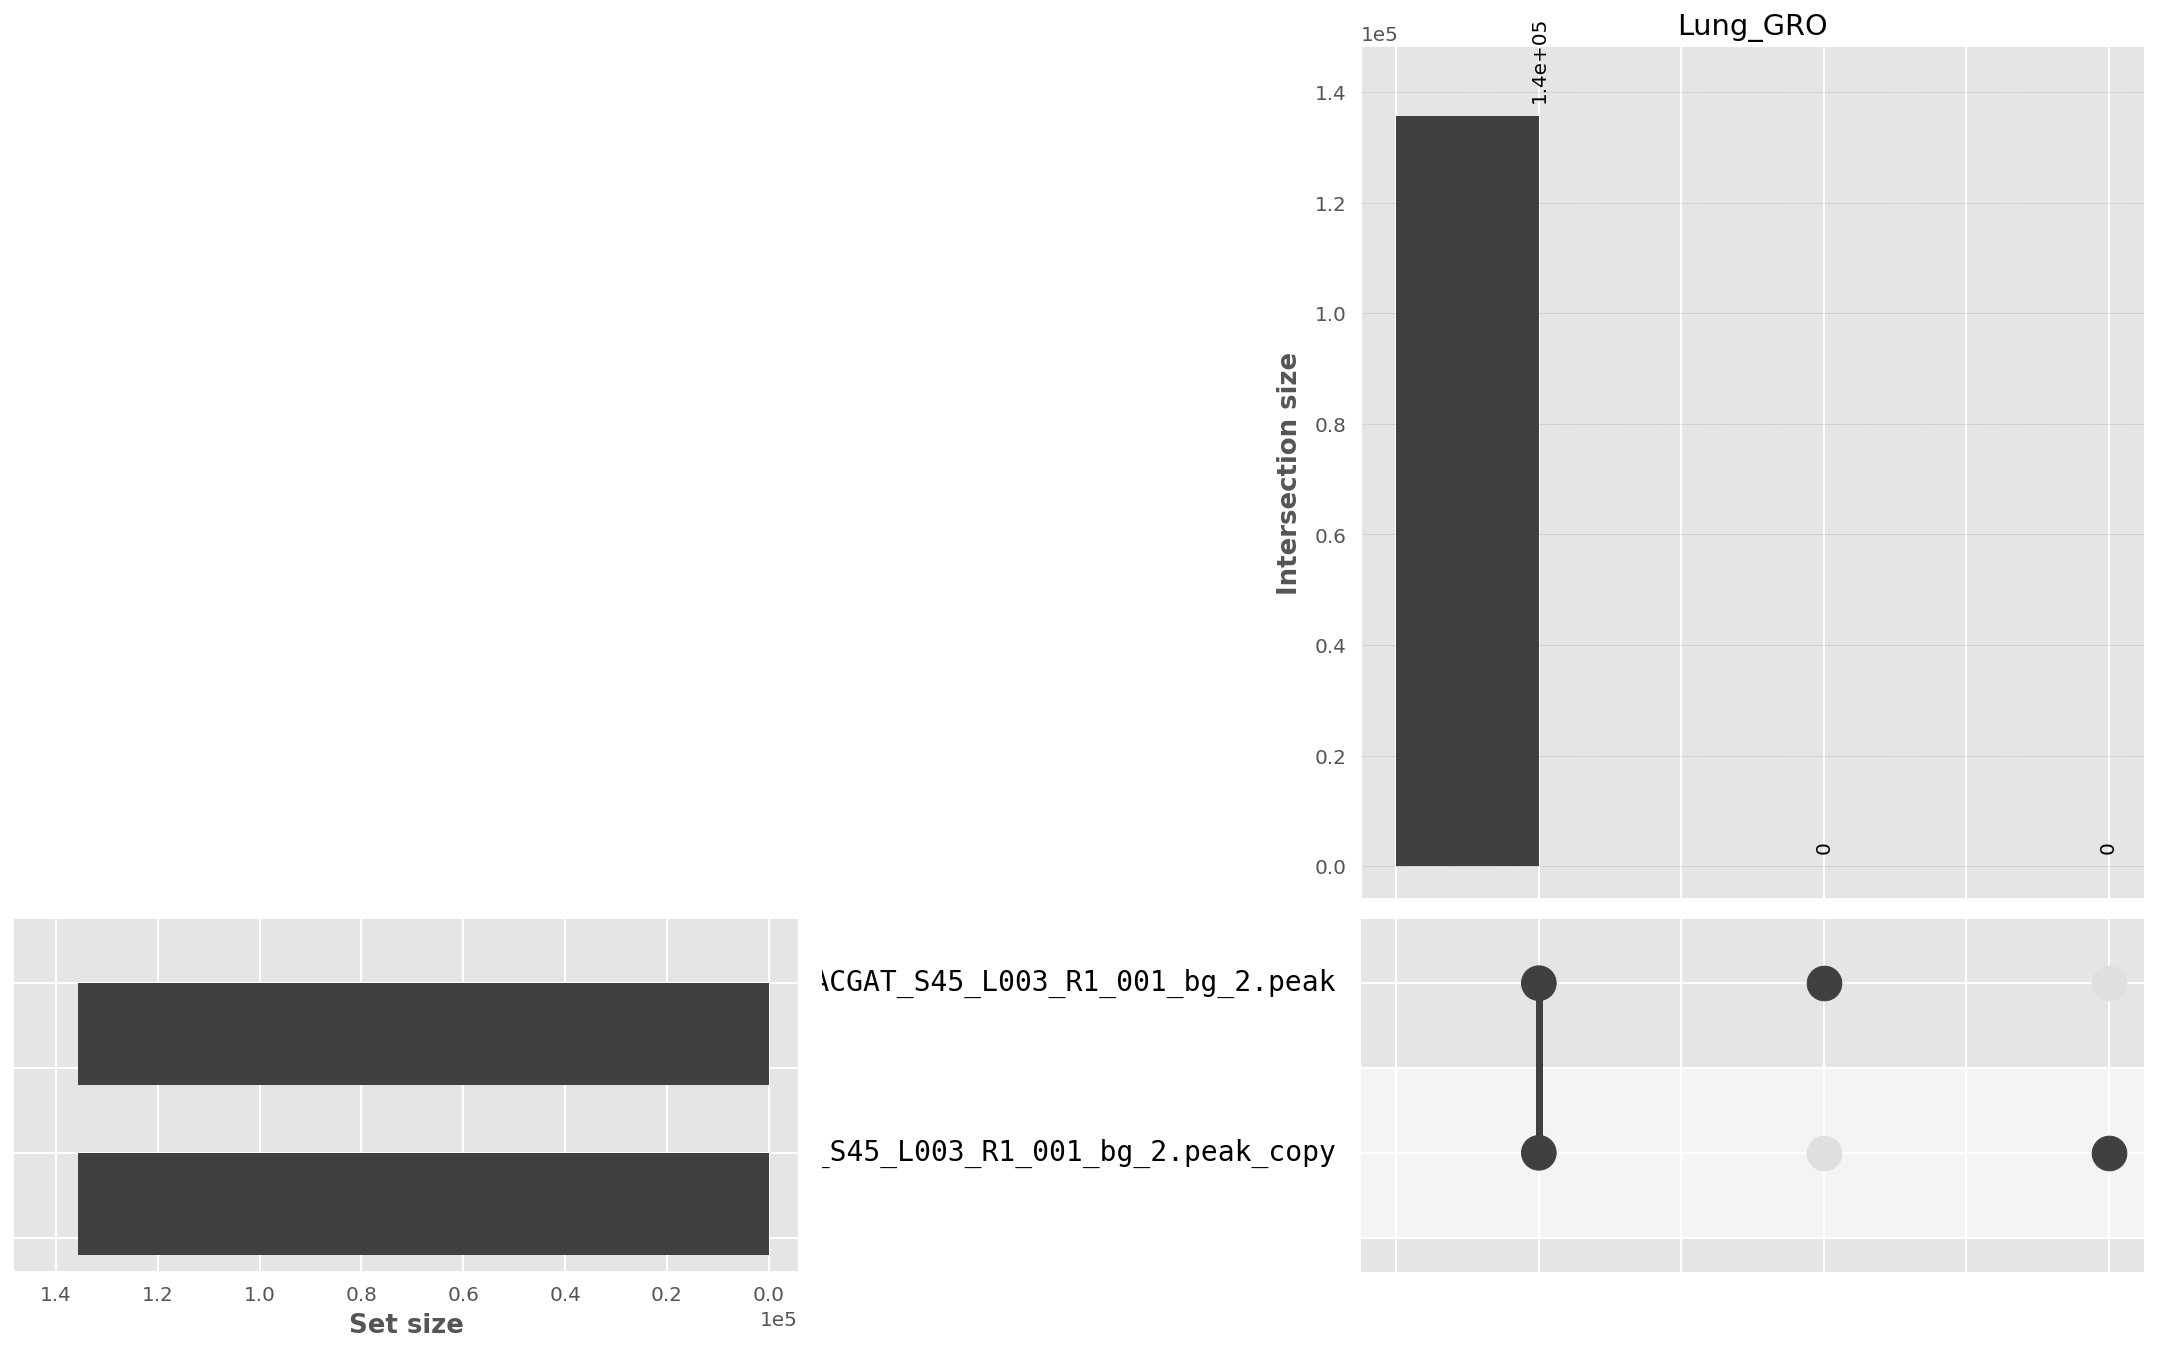

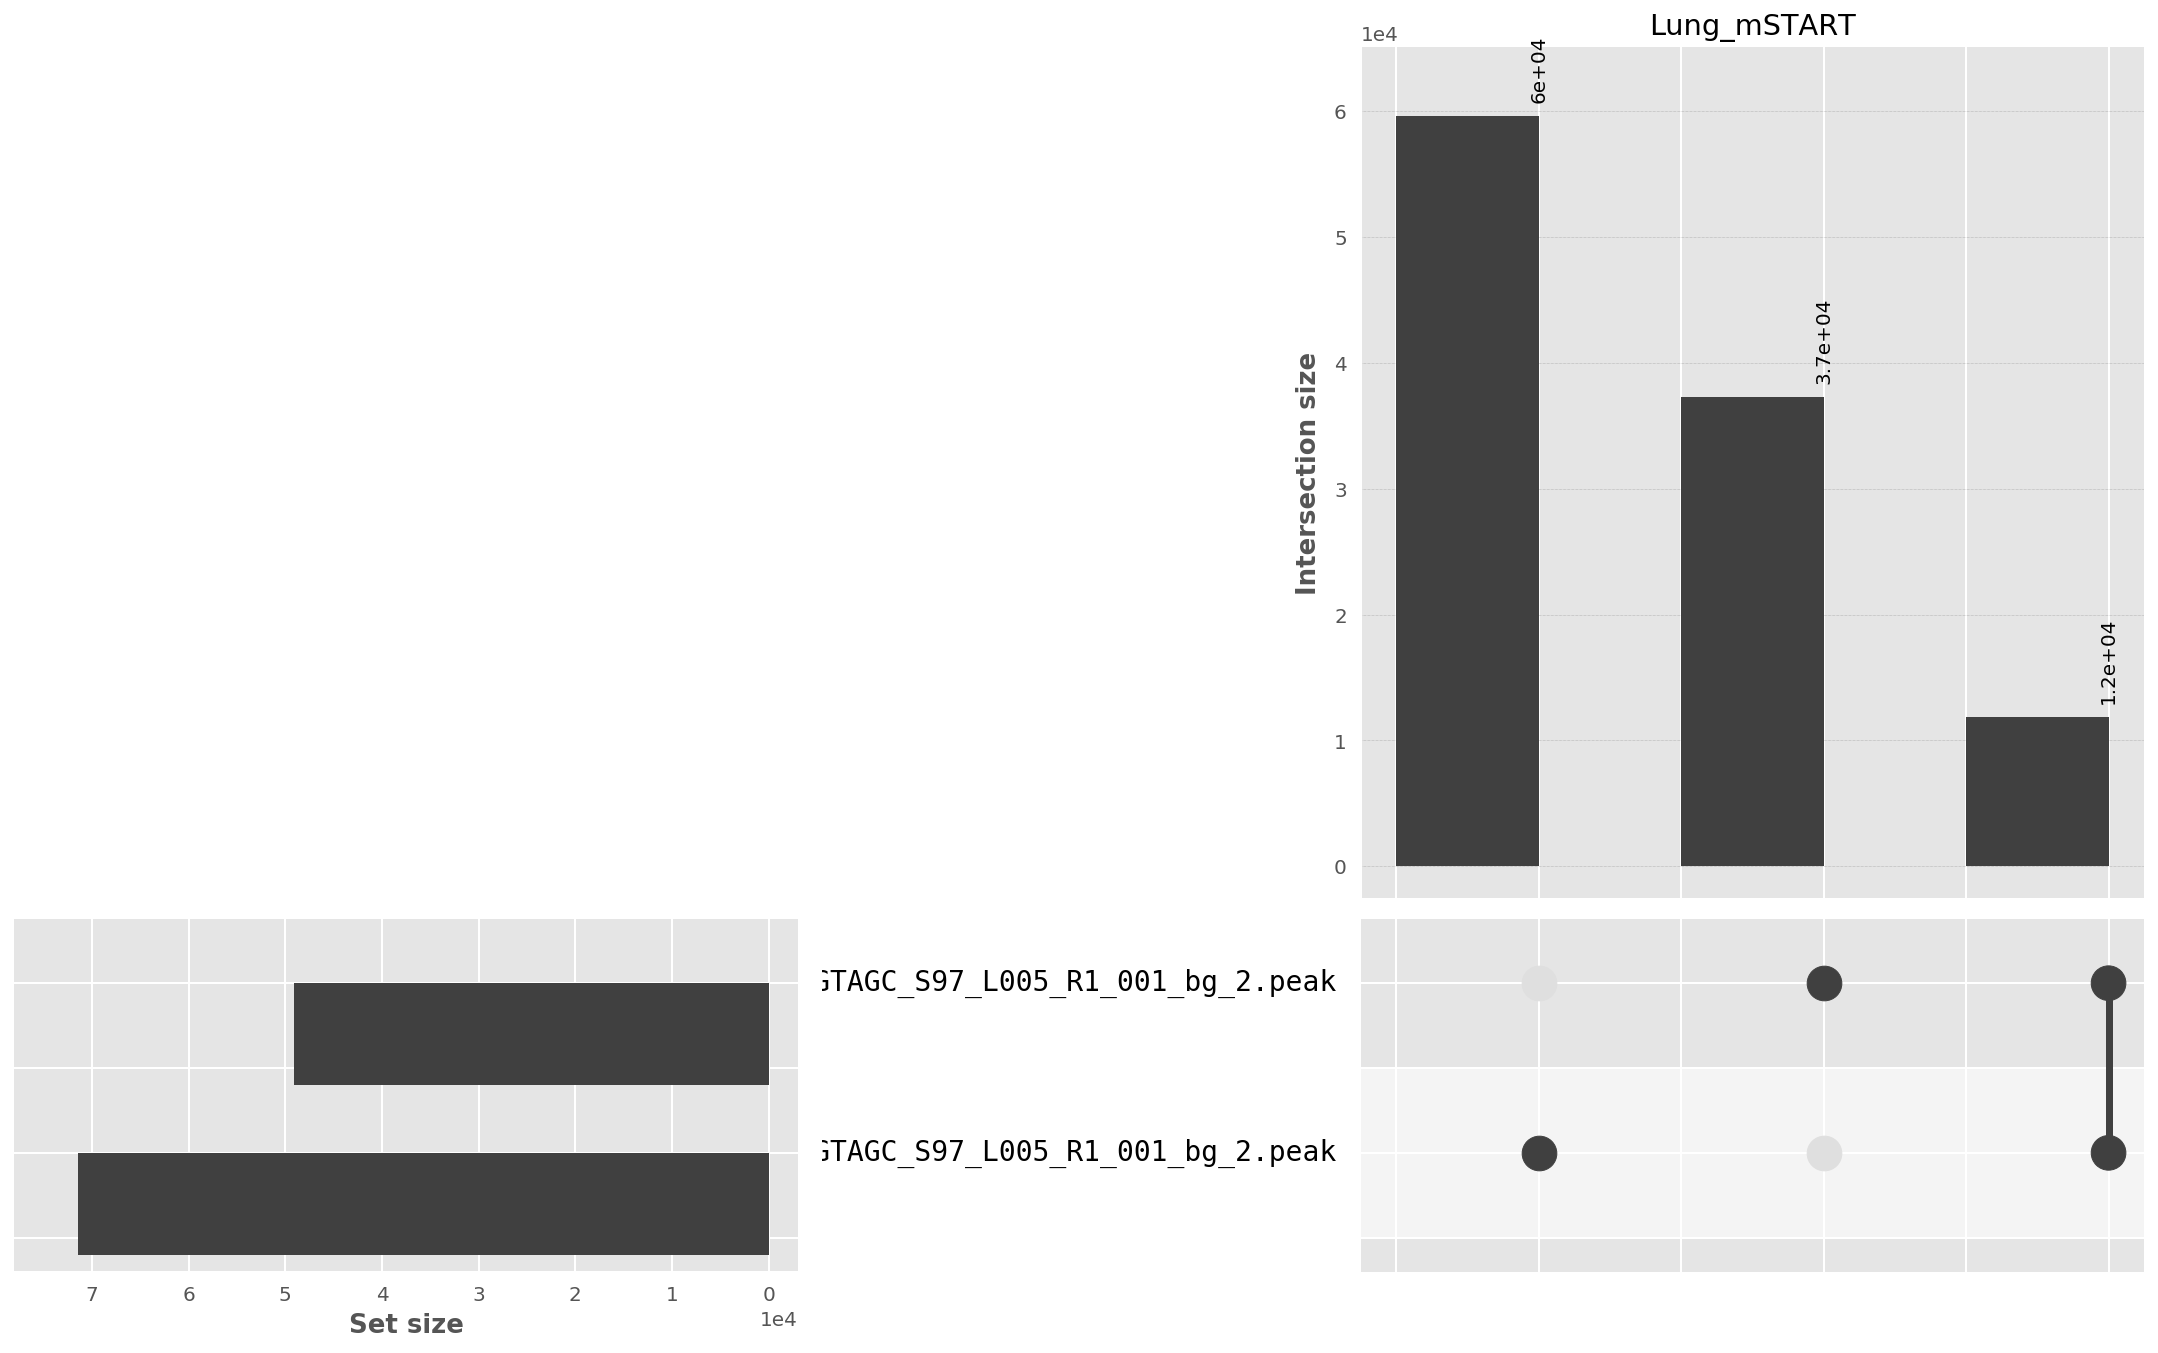

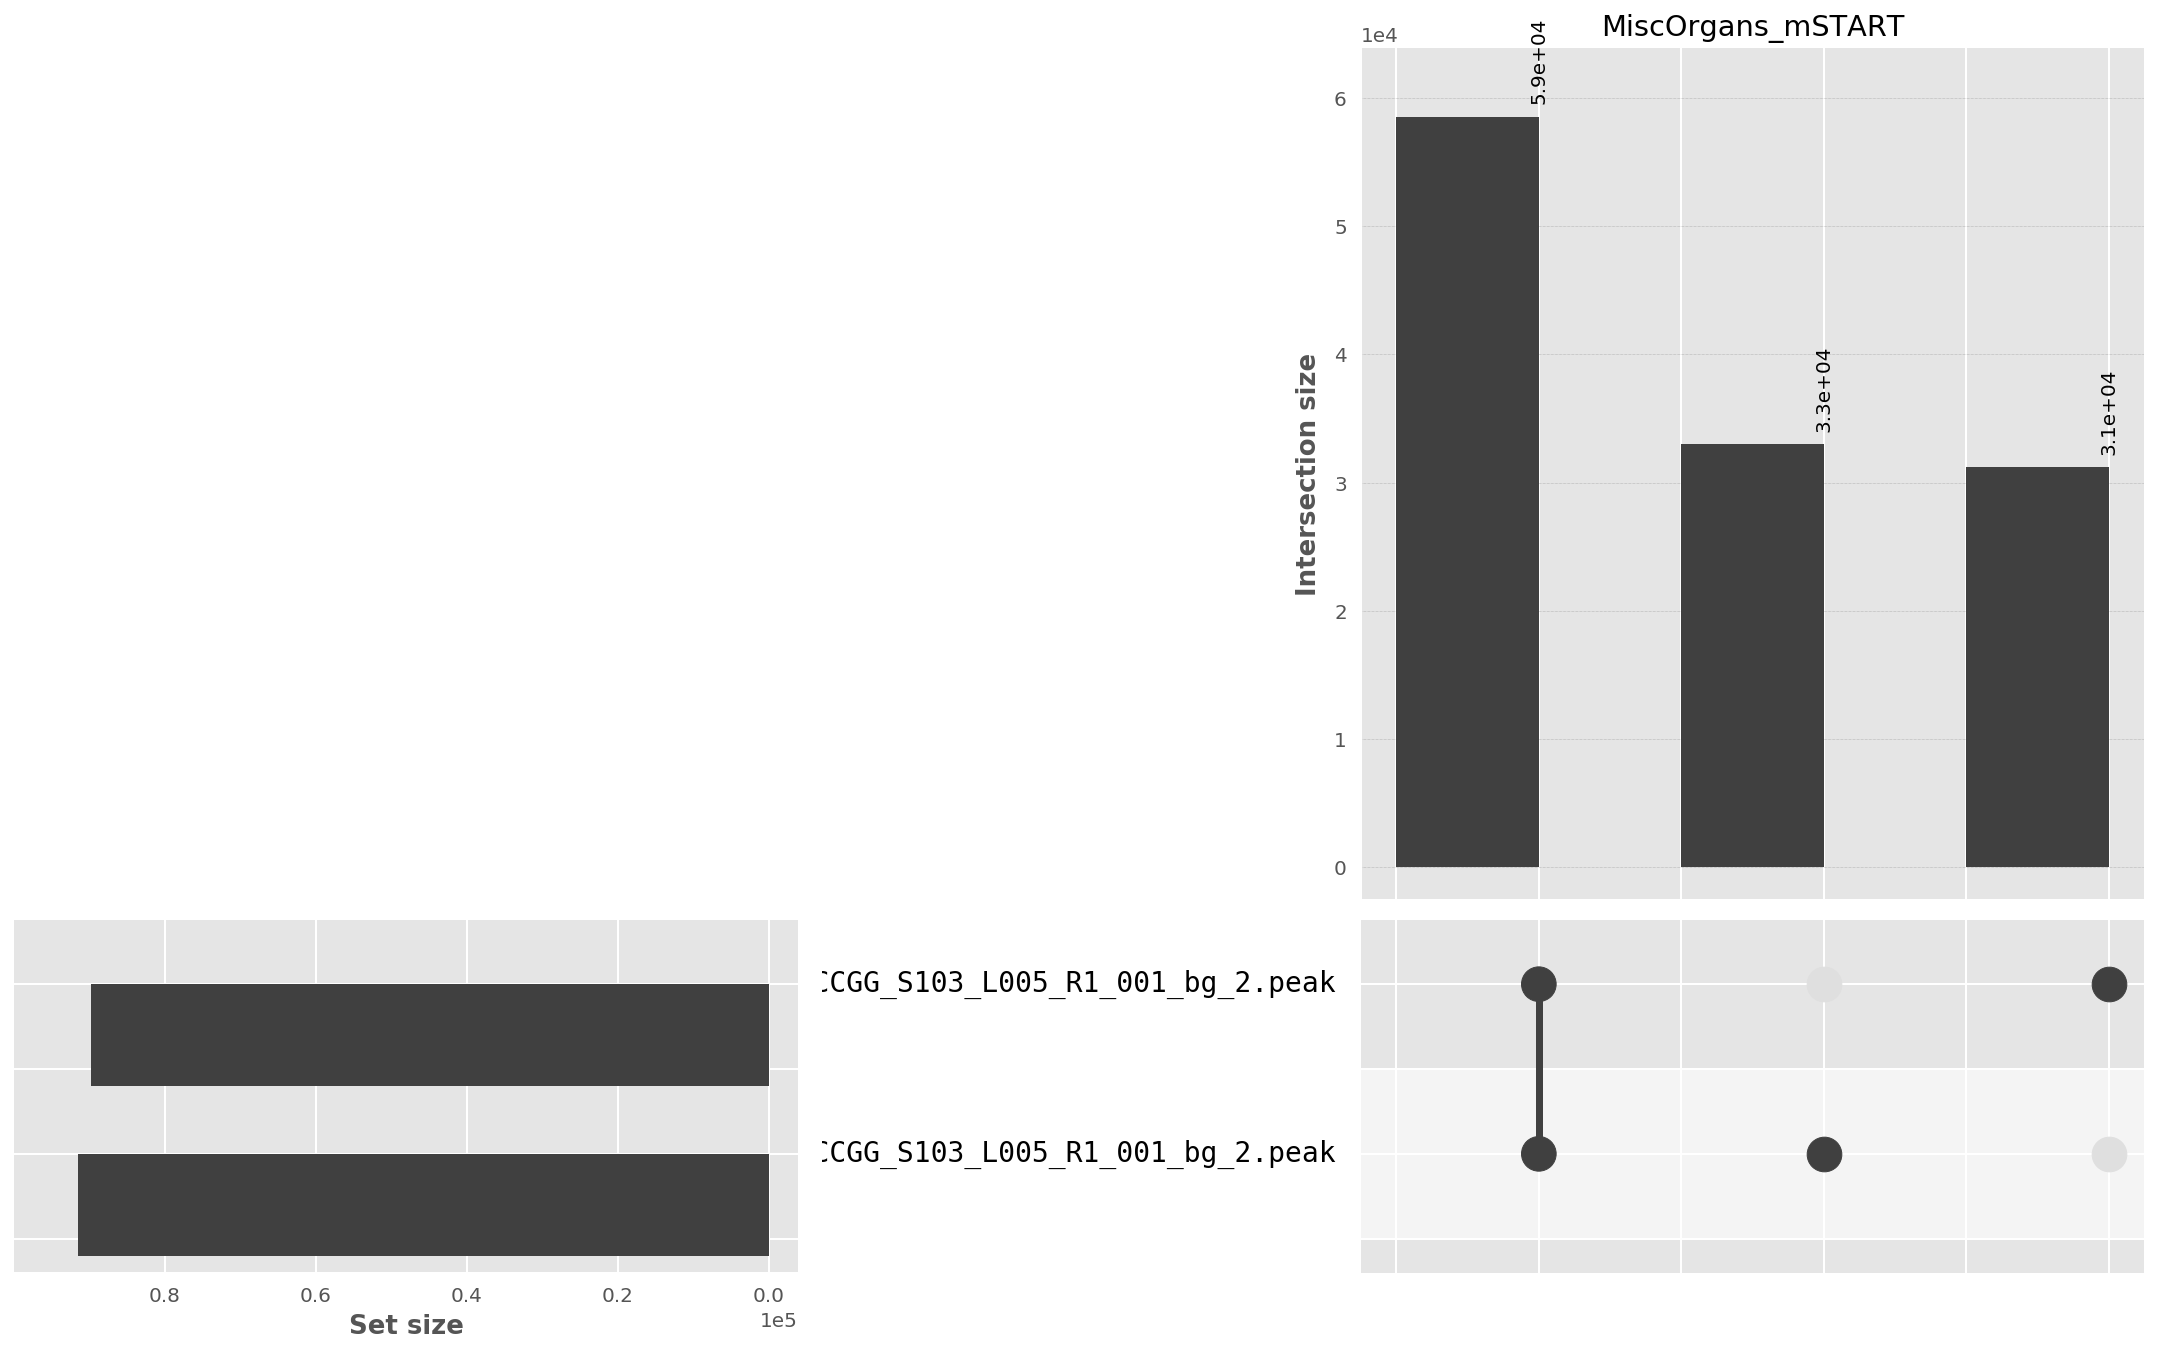

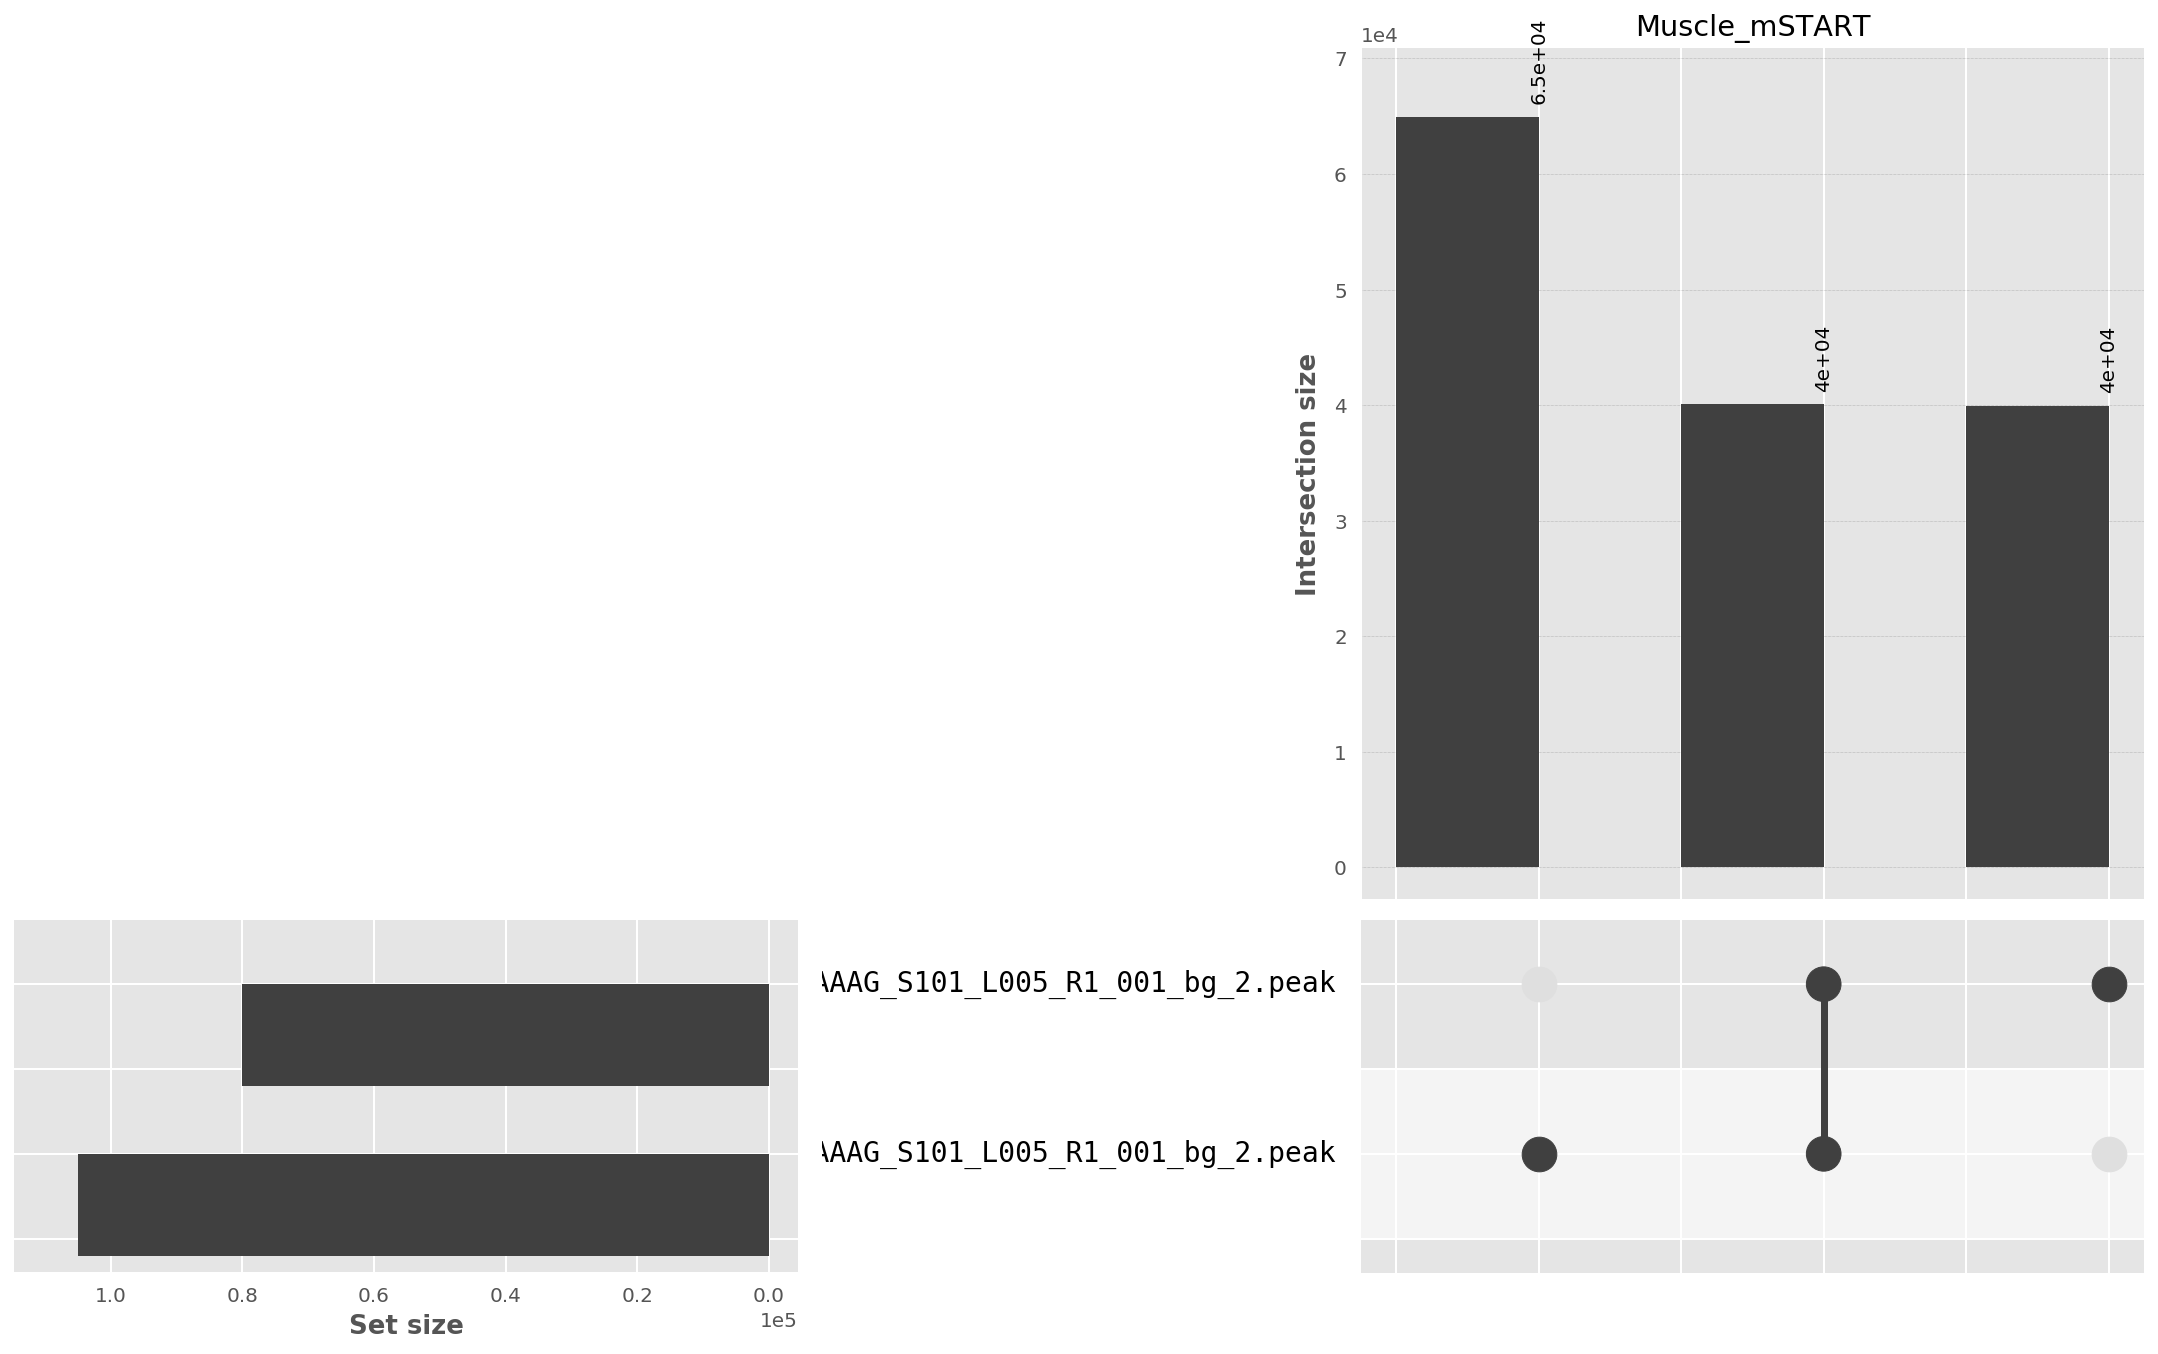

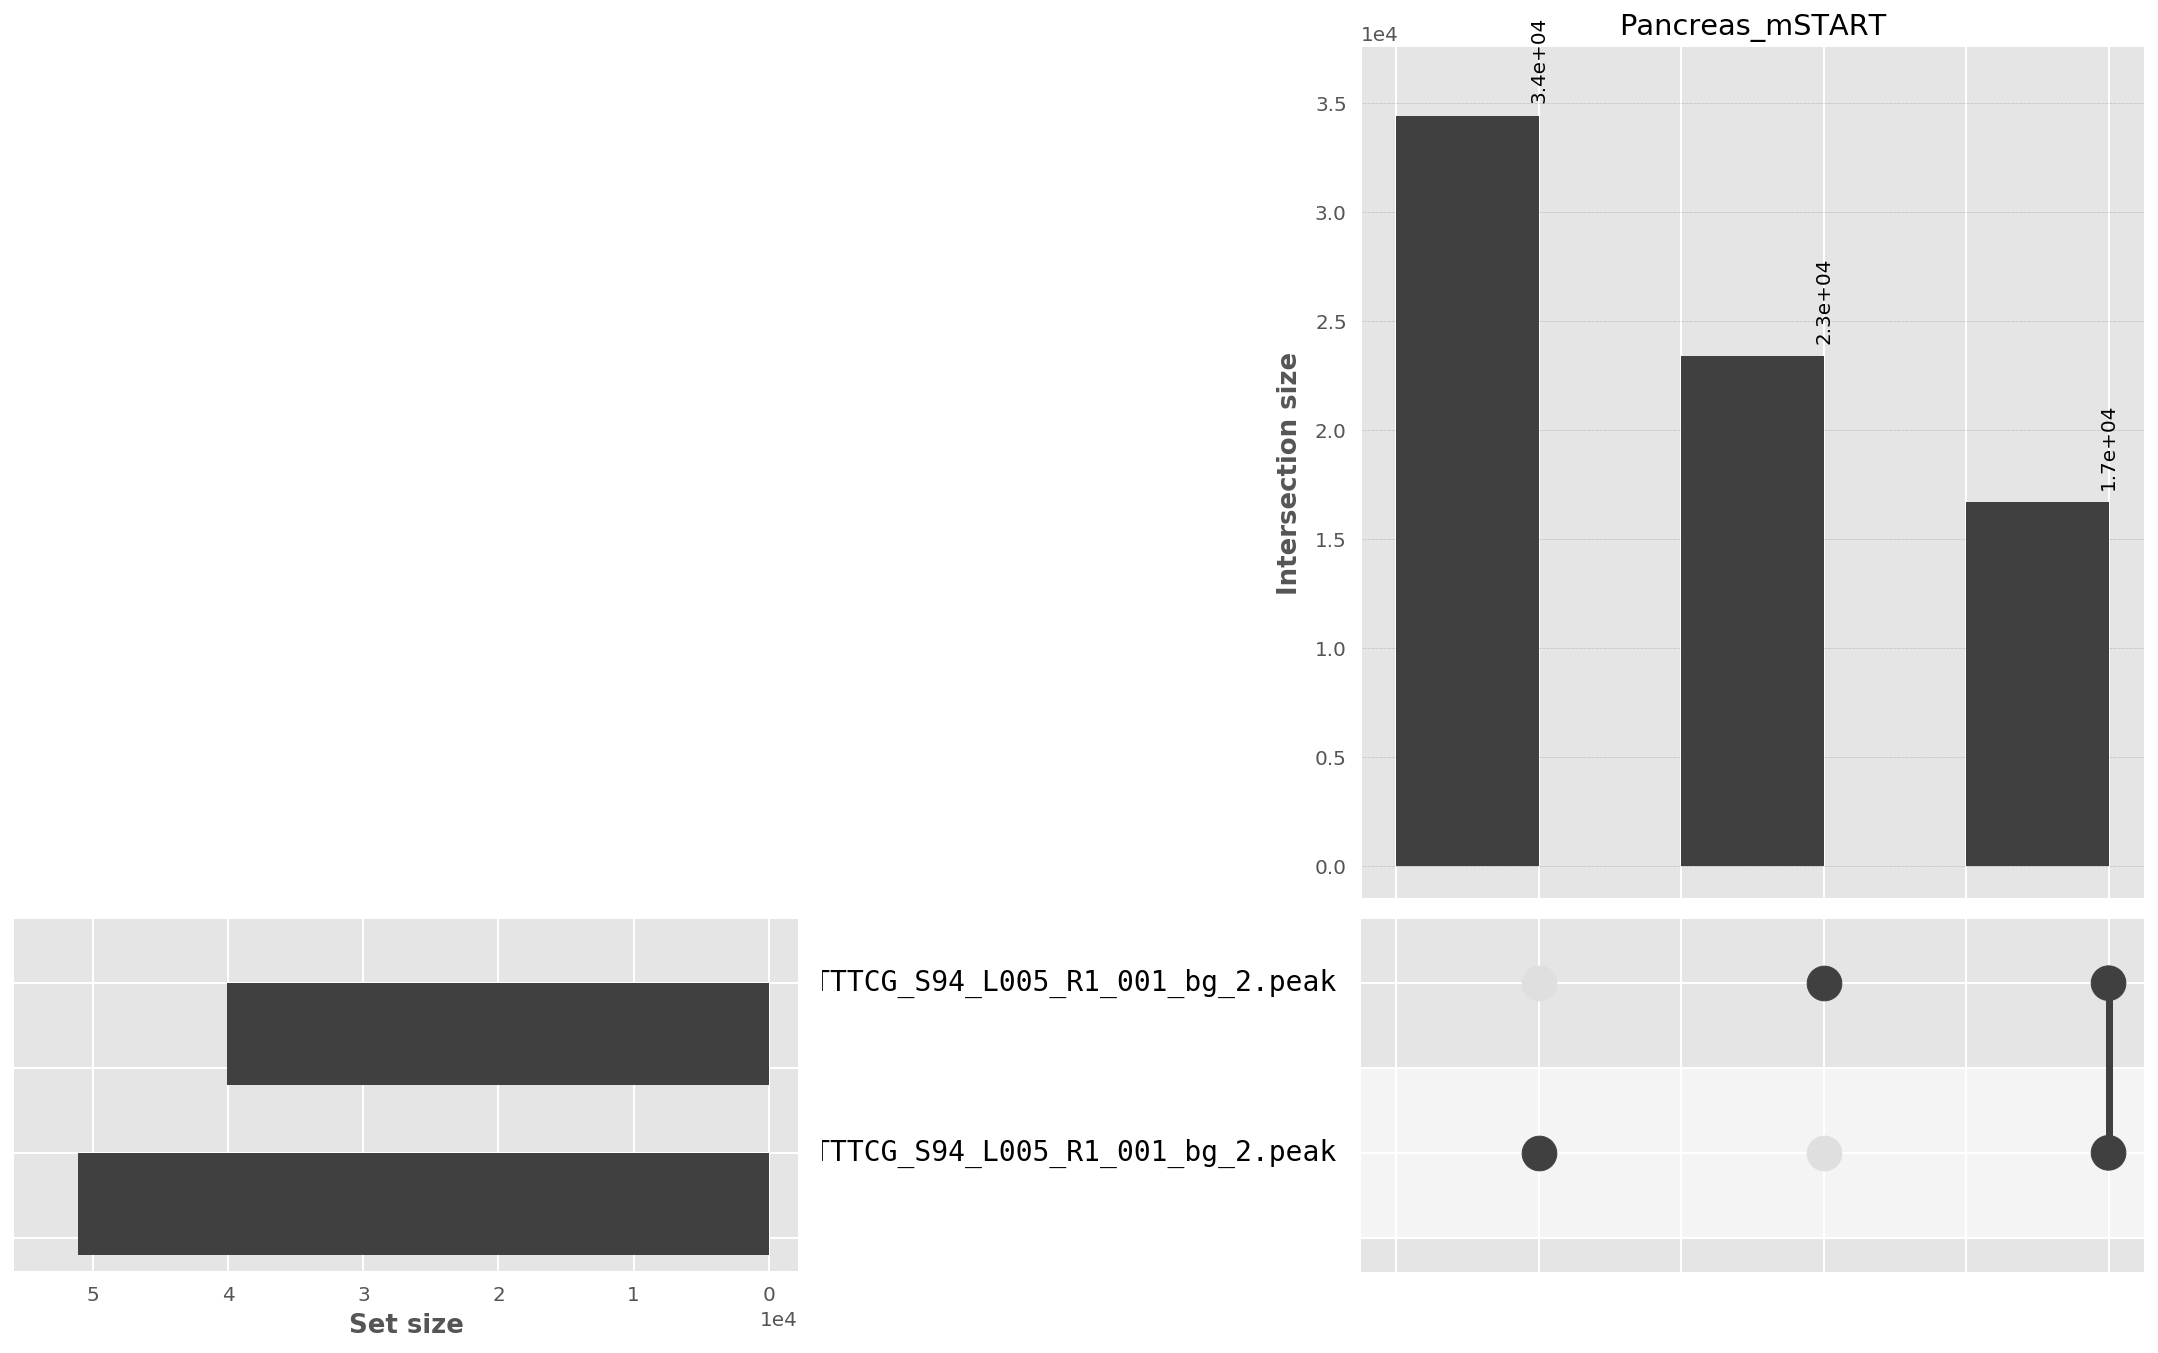

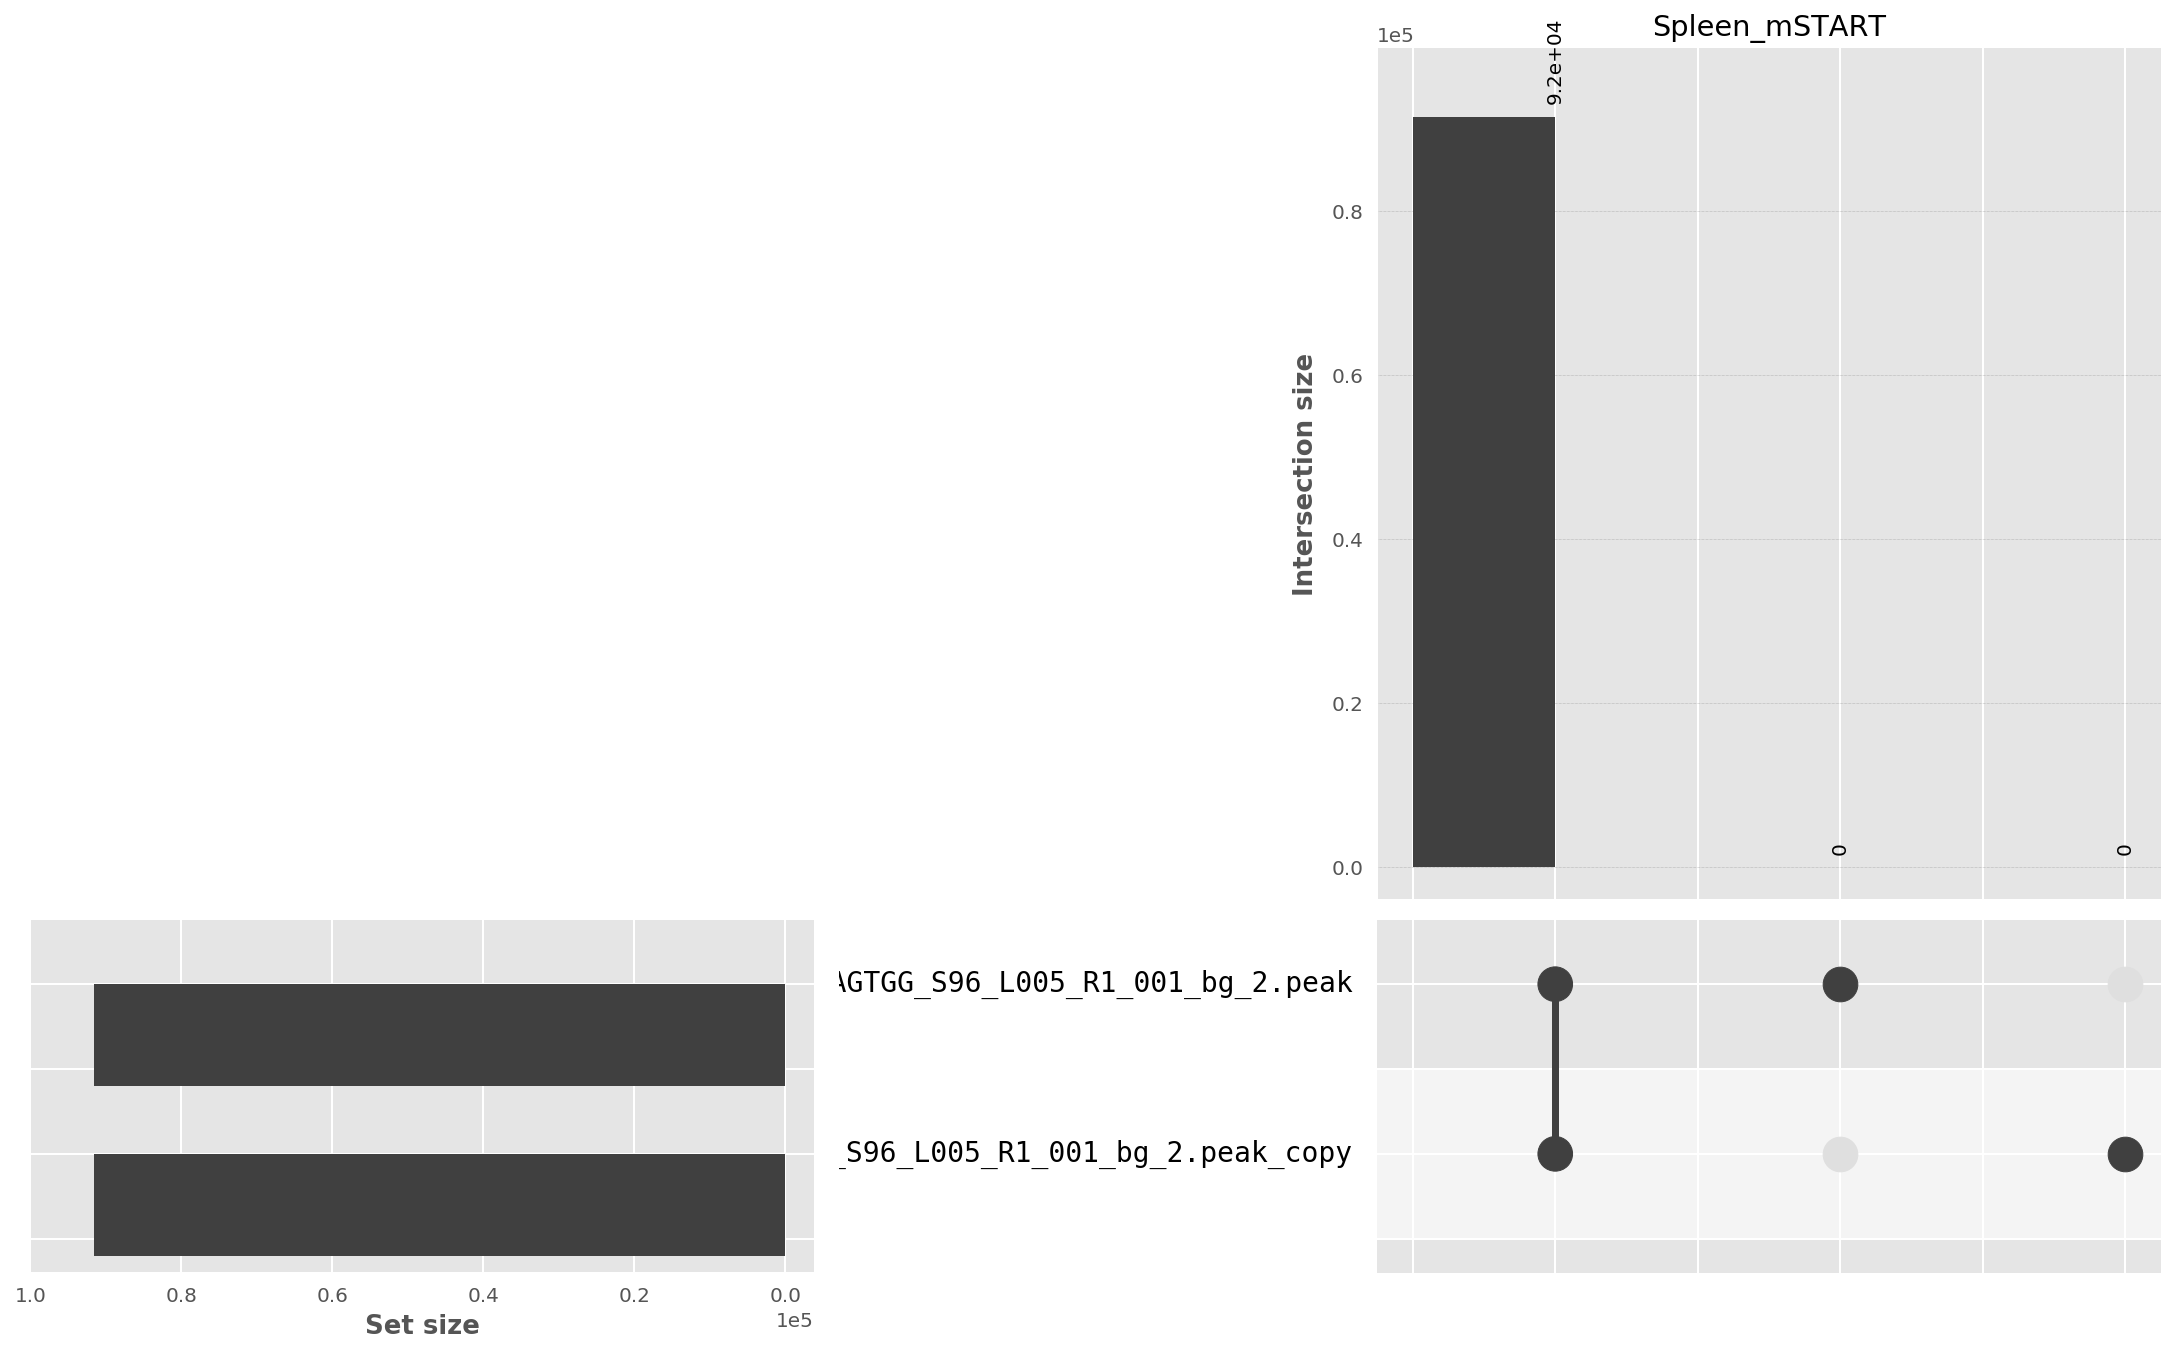

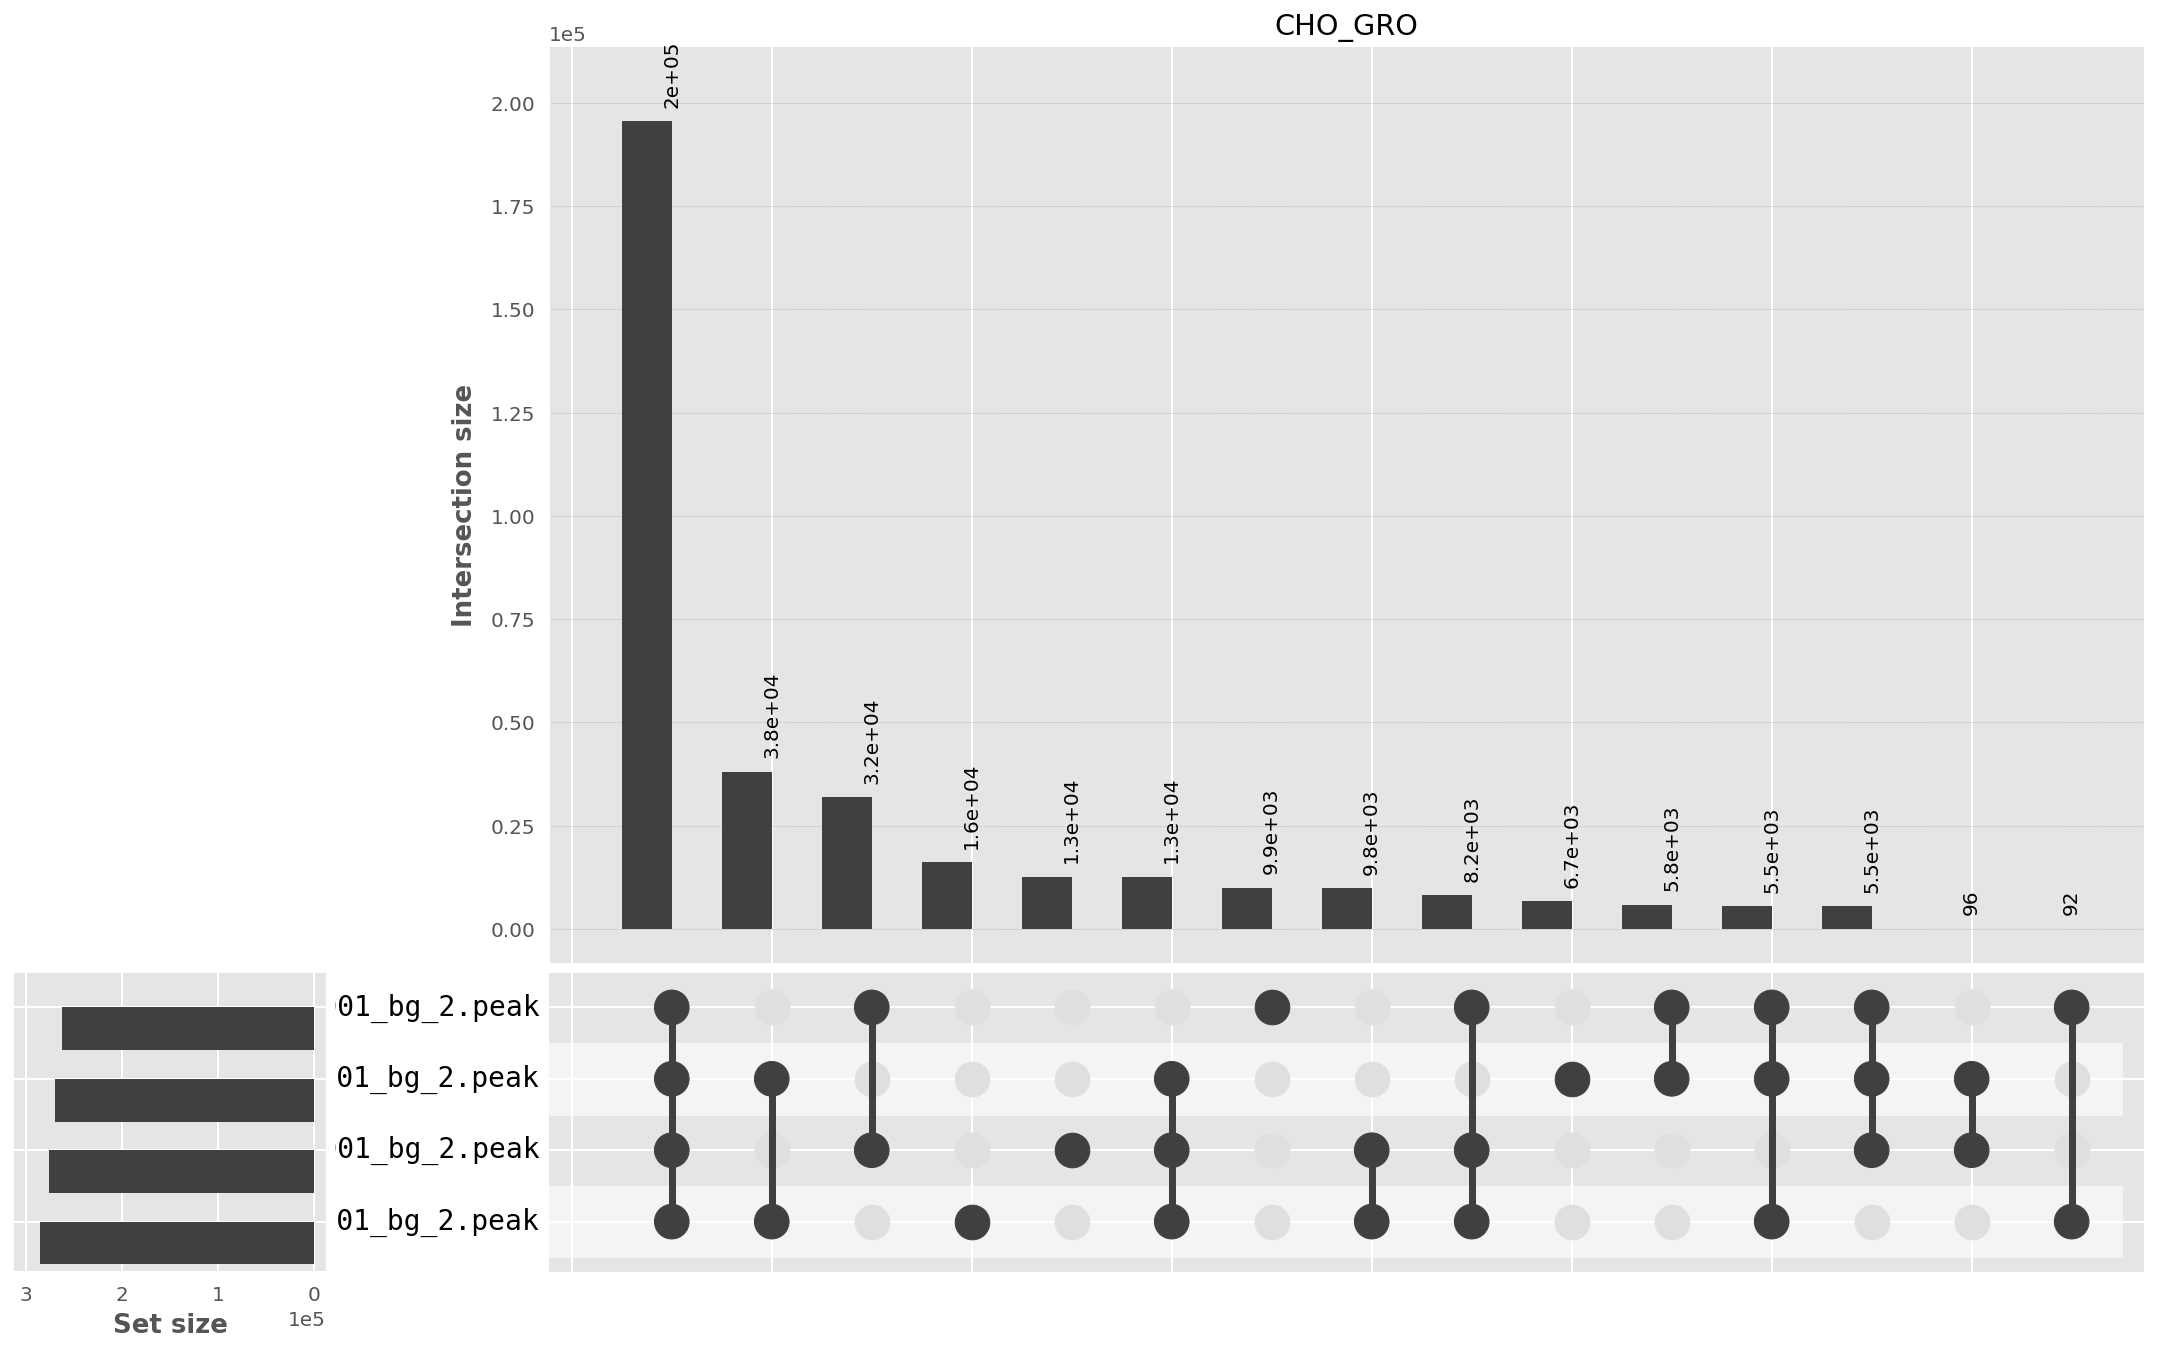

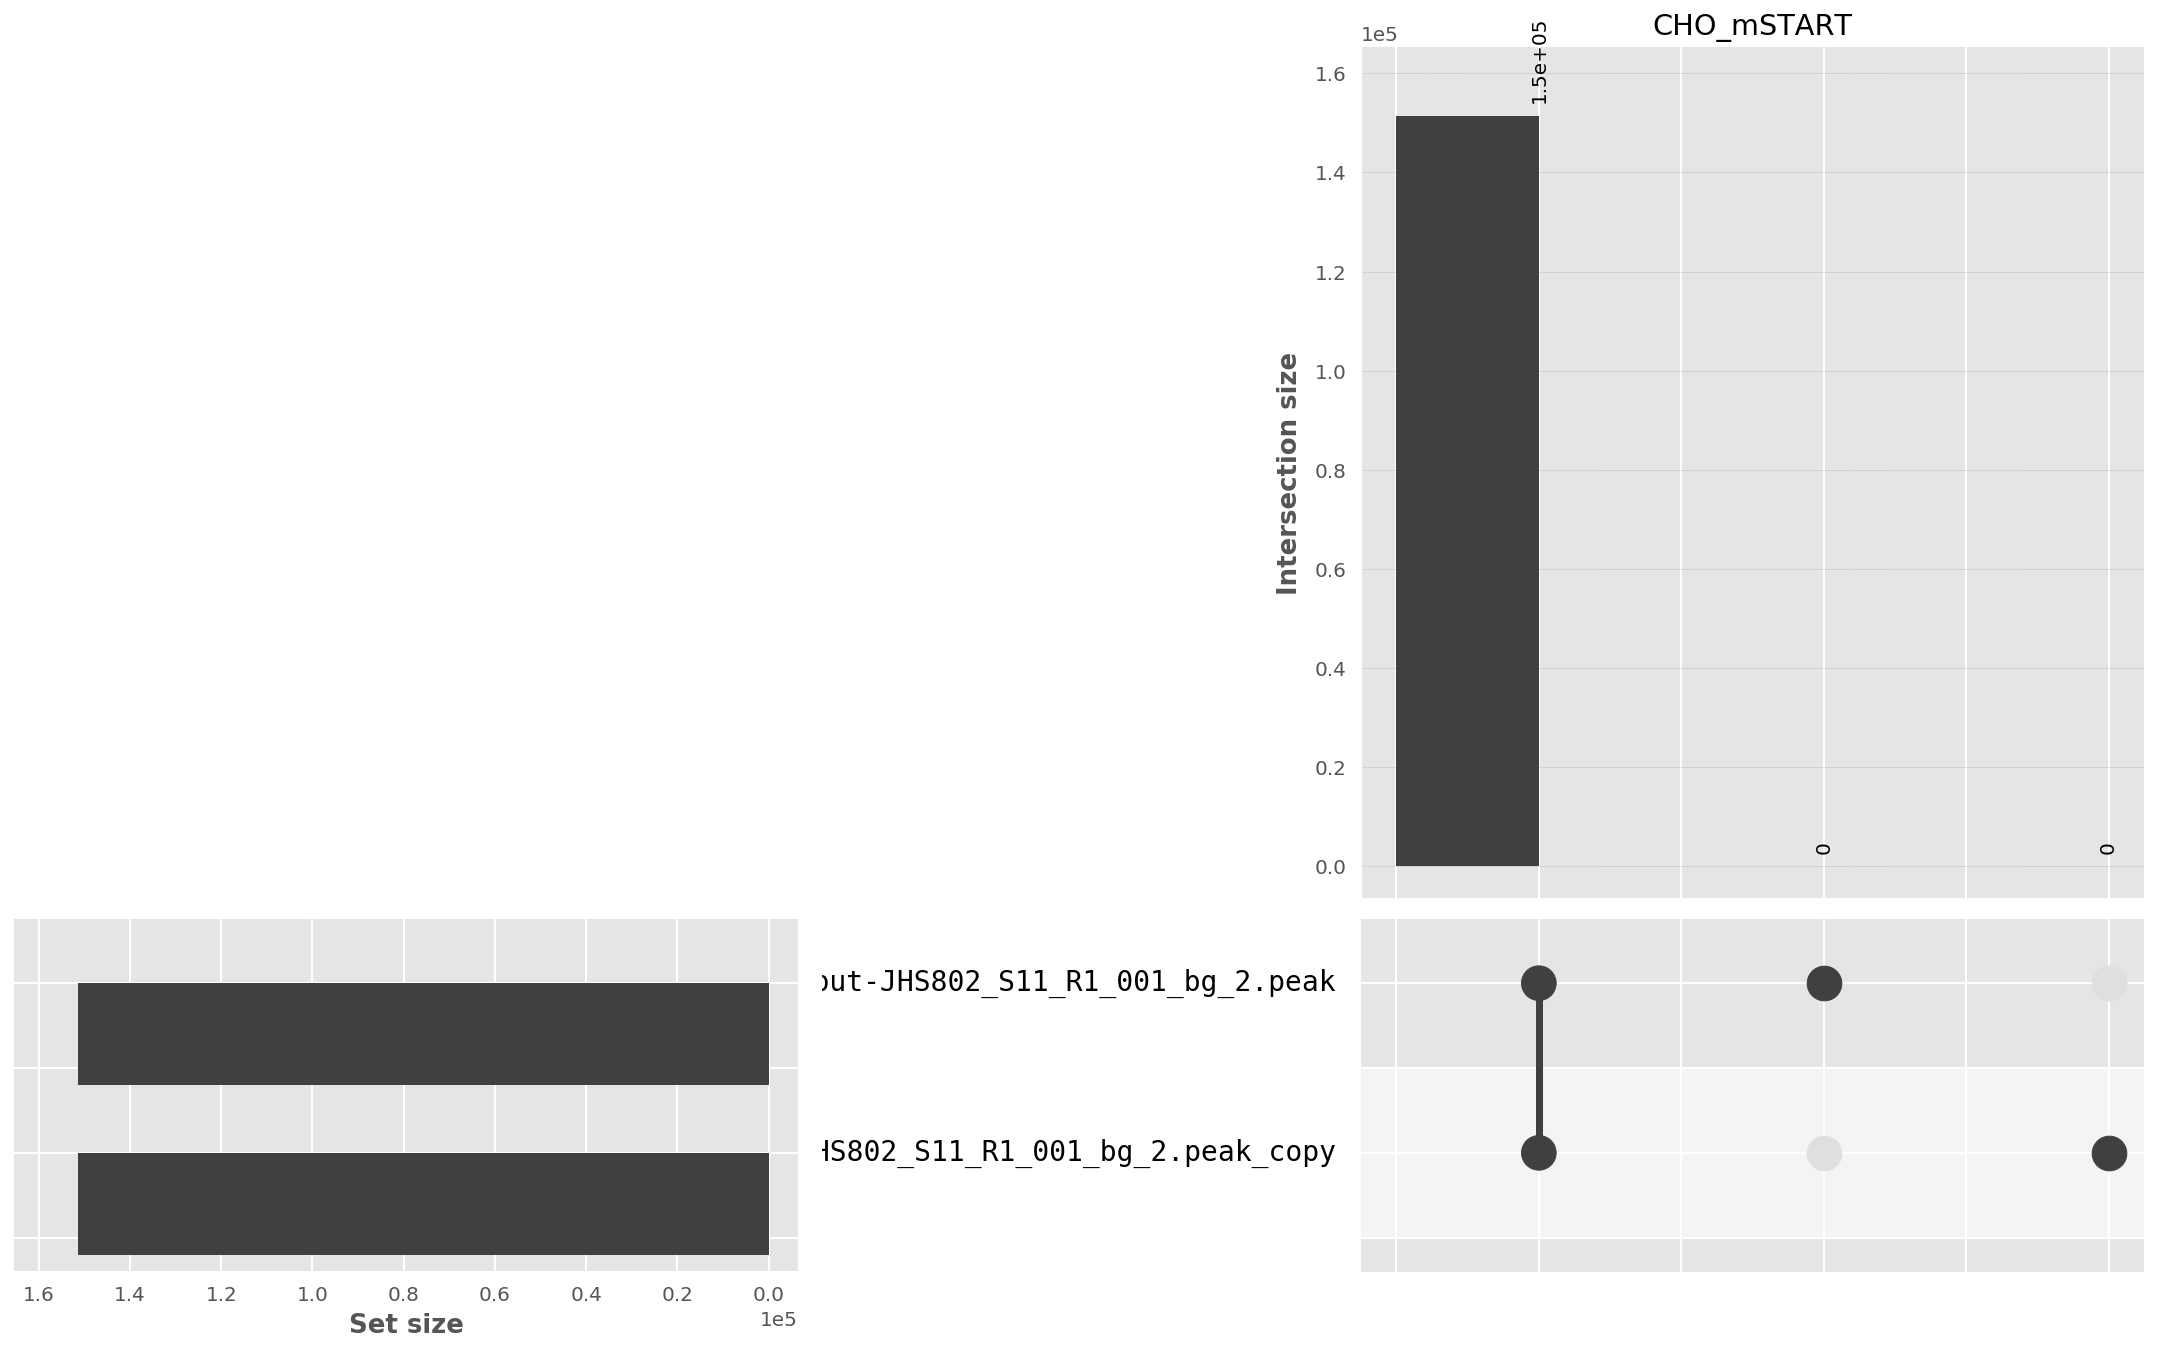

In [25]:
for curr_tissue in tissues:
    curr_raw = glob.glob(data_folder + curr_tissue + '/*/')
    for j in curr_raw:
        curr_type = j.split('/')[-2]  
        if not curr_type == 'ATAC':
            count = 1
            for f in  glob.glob(j + '*f04_peaks/merge*bg*peak*venn.tsv'):
                name = curr_tissue + '_' + curr_type
                df_out = convert_intersection_HOMER_to_pyupset(pd.read_csv(f,sep='\t'))
                out = pyu.plot(df_out)
                ax = out['figure'].gca()
                ax.set_title(curr_tissue + '_' + curr_type)
                